In [1]:
# Preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler

# train-test-split library
from sklearn.model_selection import train_test_split


#Machine Learning, Feature Importance and Evaluation Metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from numpy import mean
from sklearn.feature_selection import RFE
import pickle
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.linear_model import Lasso
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
import pandas as pd

# Read the CSV file using Pandas with ISO-8859-1 encoding
data = pd.read_csv('Global Energy Consumption Dataset.csv', encoding='ISO-8859-1')

# Display the DataFrame
print(data.head())

   Country  Year  Total Energy Consumption (TWh)  Per Capita Energy Use (kWh)  \
0   Canada  2018                         9525.38                     42301.43   
1  Germany  2020                         7922.08                     36601.38   
2   Russia  2002                         6630.01                     41670.20   
3   Brazil  2010                         8580.19                     10969.58   
4   Canada  2006                          848.88                     32190.85   

   Renewable Energy Share (%)  Fossil Fuel Dependency (%)  \
0                       13.70                       70.47   
1                       33.63                       41.95   
2                       10.82                       39.32   
3                       73.24                       16.71   
4                       73.60                       74.86   

   Industrial Energy Use (%)  Household Energy Use (%)  \
0                      45.18                     19.96   
1                      34.32  

In [4]:
!pip -q install -U pip setuptools wheel
!pip -q install -U numpy scipy pandas
!pip -q install --only-binary=:all: statsmodels==0.14.2


In [5]:
FILENAME = "Global Energy Consumption Dataset.csv"  # <-- change only if different
raw = pd.read_csv(FILENAME, encoding="ISO-8859-1")
print("Loaded:", FILENAME, "shape:", raw.shape)
display(raw.head(3))


Loaded: Global Energy Consumption Dataset.csv shape: (10000, 10)


Country  Year  Total Energy Consumption (TWh)  Per Capita Energy Use (kWh)  \
0   Canada  2018                         9525.38                     42301.43   
1  Germany  2020                         7922.08                     36601.38   
2   Russia  2002                         6630.01                     41670.20   

   Renewable Energy Share (%)  Fossil Fuel Dependency (%)  \
0                       13.70                       70.47   
1                       33.63                       41.95   
2                       10.82                       39.32   

   Industrial Energy Use (%)  Household Energy Use (%)  \
0                      45.18                     19.96   
1                      34.32                     22.27   
2                      53.66                     26.44   

   Carbon Emissions (Million Tons)  Energy Price Index (USD/kWh)  
0                          3766.11                          0.12  
1                          2713.12                          0.08  
2                           885.98                          0.26

In [6]:
df = raw.copy()

rename_map = {
    'Country':'country','Year':'year',
    'Total Energy Consumption (TWh)':'total_twh',
    'Per Capita Energy Use (kWh)':'per_capita_kwh',
    'Renewable Energy Share (%)':'renew_share_pct',
    'Fossil Fuel Dependency (%)':'fossil_share_pct',
    'Industrial Energy Use (%)':'industrial_pct',
    'Household Energy Use (%)':'household_pct',
    'Carbon Emissions (Million Tons)':'co2_mtons',
    'Energy Price Index (USD/kWh)':'price_usd_per_kwh'
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

# Required columns
req = {'country','year'}
missing = req - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns after rename: {missing}")

# Numerics
num_cols_all = ['year','total_twh','per_capita_kwh','renew_share_pct','fossil_share_pct',
                'industrial_pct','household_pct','co2_mtons','price_usd_per_kwh']
num_cols = [c for c in num_cols_all if c in df.columns]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Sanity filters
if {'total_twh','per_capita_kwh'}.issubset(df.columns):
    df = df[(df['total_twh'] >= 0) & (df['per_capita_kwh'] >= 0)]

# Year-median imputation (safe to comment out if you prefer raw)
for c in num_cols:
    df[c] = df.groupby('year')[c].transform(lambda s: s.fillna(s.median()))

# Derived intensity if possible
if {'co2_mtons','total_twh'}.issubset(df.columns):
    df['carbon_intensity_tons_per_twh'] = (df['co2_mtons']*1e6) / df['total_twh'].replace(0, np.nan)

print("Cleaned shape:", df.shape)
display(df.head(5))


Cleaned shape: (10000, 11)


country  year  total_twh  per_capita_kwh  renew_share_pct  \
0   Canada  2018    9525.38        42301.43            13.70   
1  Germany  2020    7922.08        36601.38            33.63   
2   Russia  2002    6630.01        41670.20            10.82   
3   Brazil  2010    8580.19        10969.58            73.24   
4   Canada  2006     848.88        32190.85            73.60   

   fossil_share_pct  industrial_pct  household_pct  co2_mtons  \
0             70.47           45.18          19.96    3766.11   
1             41.95           34.32          22.27    2713.12   
2             39.32           53.66          26.44     885.98   
3             16.71           30.55          27.60    1144.11   
4             74.86           42.39          23.43     842.39   

   price_usd_per_kwh  carbon_intensity_tons_per_twh  
0               0.12                  395376.352439  
1               0.08                  342475.713449  
2               0.26                  133631.774311  
3               0.47                  133343.201025  
4               0.48                  992354.631986

column                                  meaning
0                         country                             Country name
1                            year                            Calendar year
2                       total_twh     Total final energy consumption (TWh)
3                  per_capita_kwh       Per-capita energy use (kWh/person)
4                 renew_share_pct                      Renewable share (%)
5                fossil_share_pct                         Fossil share (%)
6                  industrial_pct                       Industry share (%)
7                   household_pct                      Household share (%)
8                       co2_mtons          Carbon emissions (million tons)
9               price_usd_per_kwh             Energy price index (USD/kWh)
10  carbon_intensity_tons_per_twh  Emissions per energy (tons CO2 per TWh)

column  missing_pct
0                           year          0.0
1                      total_twh          0.0
2                 per_capita_kwh          0.0
3                renew_share_pct          0.0
4               fossil_share_pct          0.0
5                 industrial_pct          0.0
6                  household_pct          0.0
7                      co2_mtons          0.0
8              price_usd_per_kwh          0.0
9  carbon_intensity_tons_per_twh          0.0

column    count          mean           std  \
0                           year  10000.0  2.012151e+03  7.155236e+00   
1                      total_twh  10000.0  5.142564e+03  2.848754e+03   
2                 per_capita_kwh  10000.0  2.503995e+04  1.420566e+04   
3                renew_share_pct  10000.0  4.732292e+01  2.460377e+01   
4               fossil_share_pct  10000.0  4.493285e+01  2.020280e+01   
5                 industrial_pct  10000.0  4.005758e+01  1.153876e+01   
6                  household_pct  10000.0  2.504329e+01  8.597024e+00   
7                      co2_mtons  10000.0  2.536148e+03  1.424105e+03   
8              price_usd_per_kwh  10000.0  2.734660e-01  1.307821e-01   
9  carbon_intensity_tons_per_twh  10000.0  1.145368e+06  2.680554e+06   

           min            25%            50%            75%           max  
0  2000.000000    2006.000000    2012.000000    2018.000000  2.024000e+03  
1   100.480000    2713.882500    5190.850000    7579.977500  9.999260e+03  
2   500.270000   12683.220000   25098.770000   37113.282500  4.998957e+04  
3     5.000000      26.110000      47.150000      68.682500  9.000000e+01  
4    10.010000      27.337500      45.110000      62.430000  8.000000e+01  
5    20.000000      30.217500      39.980000      50.150000  6.000000e+01  
6    10.000000      17.610000      25.090000      32.570000  4.000000e+01  
7    50.640000    1293.330000    2568.015000    3766.182500  4.999340e+03  
8     0.050000       0.160000       0.270000       0.390000  5.000000e-01  
9  5904.007921  253228.558716  493480.699559  942993.817068  4.731813e+07

year  total_twh  per_capita_kwh  \
year                           1.000      0.009          -0.010   
total_twh                      0.009      1.000          -0.017   
per_capita_kwh                -0.010     -0.017           1.000   
renew_share_pct                0.001     -0.021           0.008   
fossil_share_pct              -0.002     -0.009           0.006   
industrial_pct                 0.010      0.003          -0.008   
household_pct                  0.011     -0.006          -0.007   
co2_mtons                      0.013      0.014          -0.003   
price_usd_per_kwh              0.001      0.005           0.021   
carbon_intensity_tons_per_twh -0.006     -0.439           0.009   

                               renew_share_pct  fossil_share_pct  \
year                                     0.001            -0.002   
total_twh                               -0.021            -0.009   
per_capita_kwh                           0.008             0.006   
renew_share_pct                          1.000             0.001   
fossil_share_pct                         0.001             1.000   
industrial_pct                          -0.004            -0.009   
household_pct                           -0.018             0.009   
co2_mtons                                0.001             0.004   
price_usd_per_kwh                       -0.016            -0.005   
carbon_intensity_tons_per_twh            0.004             0.007   

                               industrial_pct  household_pct  co2_mtons  \
year                                    0.010          0.011      0.013   
total_twh                               0.003         -0.006      0.014   
per_capita_kwh                         -0.008         -0.007     -0.003   
renew_share_pct                        -0.004         -0.018      0.001   
fossil_share_pct                       -0.009          0.009      0.004   
industrial_pct                          1.000         -0.006      0.018   
household_pct                          -0.006          1.000     -0.014   
co2_mtons                               0.018         -0.014      1.000   
price_usd_per_kwh                       0.017          0.004     -0.003   
carbon_intensity_tons_per_twh           0.008         -0.005      0.253   

                               price_usd_per_kwh  \
year                                       0.001   
total_twh                                  0.005   
per_capita_kwh                             0.021   
renew_share_pct                           -0.016   
fossil_share_pct                          -0.005   
industrial_pct                             0.017   
household_pct                              0.004   
co2_mtons                                 -0.003   
price_usd_per_kwh                          1.000   
carbon_intensity_tons_per_twh             -0.015   

                               carbon_intensity_tons_per_twh  
year                                                  -0.006  
total_twh                                             -0.439  
per_capita_kwh                                         0.009  
renew_share_pct                                        0.004  
fossil_share_pct                                       0.007  
industrial_pct                                         0.008  
household_pct                                         -0.005  
co2_mtons                                              0.253  
price_usd_per_kwh                                     -0.015  
carbon_intensity_tons_per_twh                          1.000

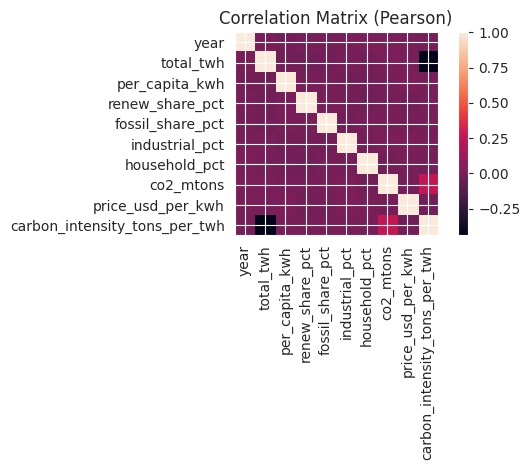

In [7]:
meaning_map = {
 "country":"Country name","year":"Calendar year",
 "total_twh":"Total final energy consumption (TWh)",
 "per_capita_kwh":"Per-capita energy use (kWh/person)",
 "renew_share_pct":"Renewable share (%)","fossil_share_pct":"Fossil share (%)",
 "industrial_pct":"Industry share (%)","household_pct":"Household share (%)",
 "co2_mtons":"Carbon emissions (million tons)",
 "price_usd_per_kwh":"Energy price index (USD/kWh)",
 "carbon_intensity_tons_per_twh":"Emissions per energy (tons CO2 per TWh)"
}
cols_in_df = [c for c in meaning_map if c in df.columns]
data_dict = pd.DataFrame({"column": cols_in_df})
data_dict["meaning"] = data_dict["column"].map(meaning_map)
display(data_dict)

present_cols = [c for c in [
    'year','total_twh','per_capita_kwh','renew_share_pct','fossil_share_pct',
    'industrial_pct','household_pct','co2_mtons','price_usd_per_kwh','carbon_intensity_tons_per_twh'
] if c in df.columns]

missing = df[present_cols].isna().mean().mul(100).round(2).reset_index()
missing.columns = ["column","missing_pct"]; display(missing)

desc = df[present_cols].describe().T.reset_index().rename(columns={"index":"column"})
display(desc)

corr = df[present_cols].corr().round(3)
display(corr)

# Optional heatmap (matplotlib only)
fig, ax = plt.subplots()
im = ax.imshow(corr, interpolation='nearest')
ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticks(range(len(corr.columns))); ax.set_yticklabels(corr.columns)
ax.set_title("Correlation Matrix (Pearson)")
fig.colorbar(im); plt.tight_layout(); plt.show()


World aggregates table:


year   total_twh   co2_mtons  price_usd_per_kwh  renew_share_pct  \
0  2000  1818935.94   935111.45           0.283868        48.543263   
1  2001  1974854.60   973735.34           0.268677        49.247023   
2  2002  1908410.61   915015.85           0.276344        45.772177   
3  2003  2092794.51  1045909.32           0.271325        47.445650   
4  2004  1994830.95   938743.12           0.273583        46.401471   
5  2005  2024460.81   991805.79           0.287041        46.685408   
6  2006  1938927.85   989940.14           0.257386        48.791929   
7  2007  2164026.58  1052348.20           0.273478        46.865797   
8  2008  1996911.00   974748.77           0.272396        45.556536   
9  2009  2079832.67  1061041.60           0.266593        46.364632   

   fossil_share_pct  
0         45.155895  
1         45.917405  
2         44.483575  
3         44.887000  
4         44.978824  
5         45.628673  
6         46.583147  
7         44.704686  
8         43.175781  
9         44.674093

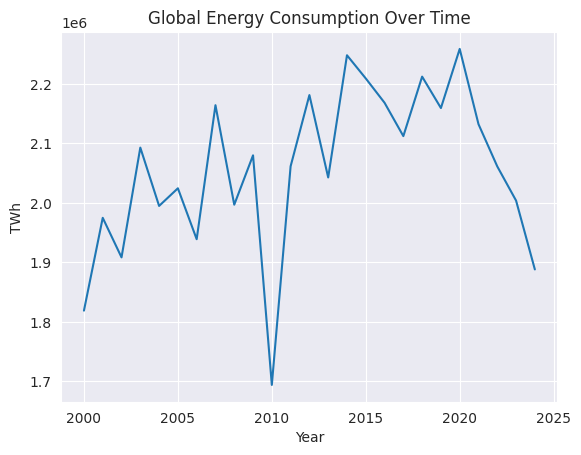

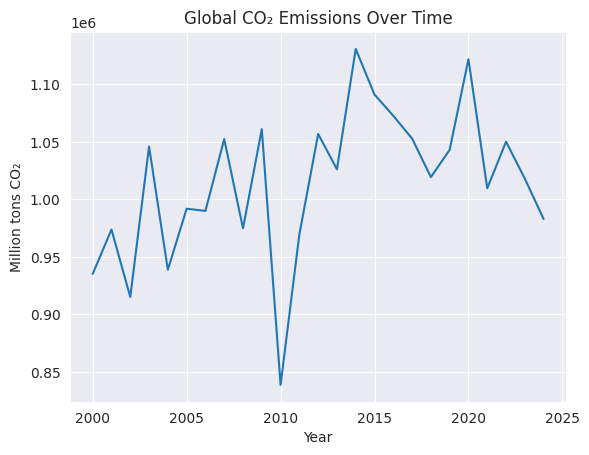

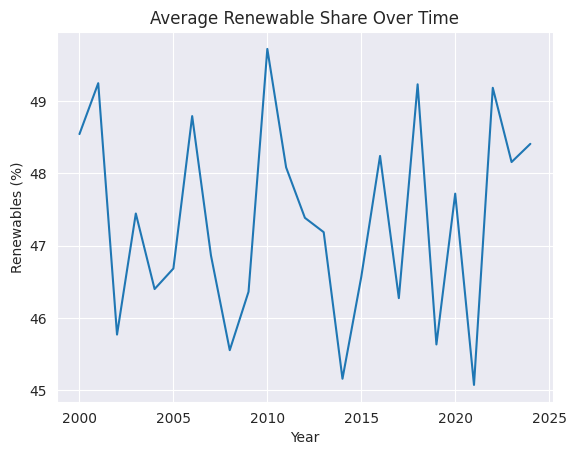

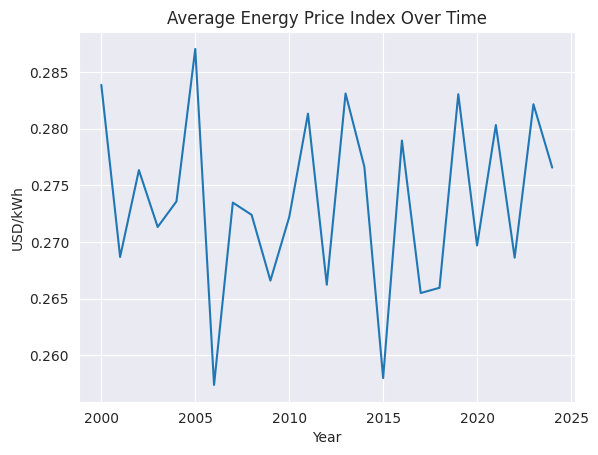

In [8]:
agg_map = {}
for col, func in [('total_twh','sum'), ('co2_mtons','sum'), ('price_usd_per_kwh','mean'),
                  ('renew_share_pct','mean'), ('fossil_share_pct','mean')]:
    if col in df.columns:
        agg_map[col] = func

world = df.groupby('year', as_index=False).agg(agg_map).sort_values('year')
print("World aggregates table:"); display(world.head(10))

if 'total_twh' in world:
    plt.figure(); plt.plot(world['year'], world['total_twh'])
    plt.xlabel("Year"); plt.ylabel("TWh"); plt.title("Global Energy Consumption Over Time"); plt.show()

if 'co2_mtons' in world:
    plt.figure(); plt.plot(world['year'], world['co2_mtons'])
    plt.xlabel("Year"); plt.ylabel("Million tons CO₂"); plt.title("Global CO₂ Emissions Over Time"); plt.show()

if 'renew_share_pct' in world:
    plt.figure(); plt.plot(world['year'], world['renew_share_pct'])
    plt.xlabel("Year"); plt.ylabel("Renewables (%)"); plt.title("Average Renewable Share Over Time"); plt.show()

if 'price_usd_per_kwh' in world:
    plt.figure(); plt.plot(world['year'], world['price_usd_per_kwh'])
    plt.xlabel("Year"); plt.ylabel("USD/kWh"); plt.title("Average Energy Price Index Over Time"); plt.show()


In [9]:
def compute_cagr_safe(g, years=10):
    g = g.copy()
    # Make sure year is numeric and sorted
    g['year'] = pd.to_numeric(g['year'], errors='coerce')
    g = g.dropna(subset=['year']).sort_values('year')

    # Need at least two distinct years and total_twh present
    if g['year'].nunique() < 2 or 'total_twh' not in g.columns:
        return np.nan

    end_year = int(g['year'].max())
    start_year = end_year - years

    # Restrict to the last `years` window (or less if not available)
    sub = g[g['year'].between(start_year, end_year)].dropna(subset=['total_twh'])
    if sub.empty or sub['year'].nunique() < 2:
        return np.nan

    # Use index positions of min/max year within the window (robust)
    i_start = sub['year'].idxmin()
    i_end   = sub['year'].idxmax()

    start_val = sub.loc[i_start, 'total_twh']
    end_val   = sub.loc[i_end,   'total_twh']
    start_yr  = int(sub.loc[i_start, 'year'])
    end_yr    = int(sub.loc[i_end,   'year'])

    # Validate inputs
    if pd.isna(start_val) or pd.isna(end_val) or start_val <= 0:
        return np.nan
    n = end_yr - start_yr
    if n <= 0:
        return np.nan

    # CAGR
    return (end_val / start_val) ** (1 / n) - 1

# Recompute the growth table with the fixed function
growth = (
    df.groupby('country', group_keys=True)
      .apply(compute_cagr_safe, years=10)
      .reset_index()
      .rename(columns={0: 'cagr_10y_total_twh'})
      .dropna()
      .sort_values('cagr_10y_total_twh', ascending=False)
      .head(20)
)
display(growth)


country  cagr_10y_total_twh
7     Russia            0.115978
3      China            0.113247
1     Brazil            0.107216
0  Australia            0.066115
5      India            0.063905
2     Canada            0.045013
8         UK            0.004985
4    Germany           -0.062104
9        USA           -0.156407
6      Japan           -0.179088

In [10]:
fe = df.sort_values(['country','year']).copy()

# Derived levels
if {'total_twh','renew_share_pct'}.issubset(fe.columns):
    fe['renew_twh'] = fe['total_twh'] * fe['renew_share_pct'] / 100.0
if {'total_twh','fossil_share_pct'}.issubset(fe.columns):
    fe['fossil_twh'] = fe['total_twh'] * fe['fossil_share_pct'] / 100.0
if {'industrial_pct','household_pct'}.issubset(fe.columns):
    fe['ind_to_house_ratio'] = fe['industrial_pct'] / fe['household_pct']

# Dynamics
if 'total_twh' in fe: fe['yoy_total_twh'] = fe.groupby('country')['total_twh'].pct_change()
if 'per_capita_kwh' in fe: fe['yoy_per_capita'] = fe.groupby('country')['per_capita_kwh'].pct_change()
if 'price_usd_per_kwh' in fe: fe['yoy_price'] = fe.groupby('country')['price_usd_per_kwh'].pct_change()
if 'renew_share_pct' in fe: fe['yoy_renew_share'] = fe.groupby('country')['renew_share_pct'].pct_change()

# Smoothing (3-year)
if 'total_twh' in fe: fe['ma3_total_twh'] = fe.groupby('country')['total_twh'].transform(lambda s: s.rolling(3, min_periods=1).mean())
if 'price_usd_per_kwh' in fe: fe['ma3_price'] = fe.groupby('country')['price_usd_per_kwh'].transform(lambda s: s.rolling(3, min_periods=1).mean())

# Lags
for c in ['total_twh','per_capita_kwh','price_usd_per_kwh','renew_share_pct','fossil_share_pct','co2_mtons']:
    if c in fe:
        fe[f'{c}_lag1'] = fe.groupby('country')[c].shift(1)
        fe[f'{c}_lag2'] = fe.groupby('country')[c].shift(2)

display(fe.head(30))


country  year  total_twh  per_capita_kwh  renew_share_pct  \
108   Australia  2000    5892.49        32333.13            29.01   
554   Australia  2000    3982.07        34832.51            57.65   
729   Australia  2000    3493.13        27097.18            56.51   
1027  Australia  2000    2592.27        24447.77            47.42   
1420  Australia  2000    1079.63        34928.05            64.12   
1500  Australia  2000     936.98        23021.20            19.32   
1538  Australia  2000     506.56         2427.91            24.68   
1599  Australia  2000     689.49        37230.62            61.16   
1605  Australia  2000    3678.74        46559.34             7.70   
1711  Australia  2000    5761.80        48882.31            18.23   
1761  Australia  2000    6827.56        18246.85            17.94   
2076  Australia  2000    6986.29        40843.42            54.96   
2478  Australia  2000     468.59        38708.44            83.97   
2832  Australia  2000    3589.60        47382.40            39.68   
2976  Australia  2000     172.37        36357.95            14.93   
3042  Australia  2000     751.19        28525.64            23.17   
3048  Australia  2000    1193.30         2043.45            34.38   
3675  Australia  2000    9508.21        19773.38            77.86   
3687  Australia  2000    1471.62         9860.03            78.69   
4305  Australia  2000    5447.06        15790.43            63.06   
4336  Australia  2000    8632.91        30389.26             8.36   
4812  Australia  2000    2440.40        27972.62            81.92   
4819  Australia  2000    5478.60         9860.01            87.00   
5410  Australia  2000    8810.22         5928.52            17.89   
5618  Australia  2000     991.08        12551.53            87.28   
5899  Australia  2000    5127.42        47741.87            52.88   
5965  Australia  2000    2929.11        45335.74            75.60   
6327  Australia  2000    3230.16        32275.74            89.70   
6418  Australia  2000    7145.51        44205.88            73.32   
6817  Australia  2000    7067.43        24987.42            78.43   

      fossil_share_pct  industrial_pct  household_pct  co2_mtons  \
108              38.07           59.32          15.82    2781.88   
554              66.14           53.42          34.44    4873.59   
729              72.36           53.01          37.47     586.80   
1027             20.03           45.36          31.30     146.16   
1420             24.62           39.52          34.89    3546.03   
1500             45.10           33.90          22.29    4093.80   
1538             73.25           52.84          17.45    3213.21   
1599             36.93           28.59          26.34    1246.94   
1605             54.24           40.68          35.64    3401.52   
1711             19.14           20.04          15.04    4006.78   
1761             10.62           30.47          30.63    2302.15   
2076             29.58           45.86          12.82     950.36   
2478             35.63           32.27          33.17    2094.46   
2832             61.40           31.22          28.92    4492.52   
2976             71.92           52.14          36.01    4637.37   
3042             67.19           36.19          13.05    4622.19   
3048             75.40           47.98          21.90    4254.44   
3675             71.03           59.27          27.54    3093.46   
3687             57.43           25.20          34.86    1258.44   
4305             23.48           41.96          27.86    4700.82   
4336             18.58           26.01          18.56     928.45   
4812             66.82           48.88          19.58    4748.27   
4819             10.88           28.15          28.78    1368.69   
5410             75.83           24.66          37.41    2975.69   
5618             52.00           59.25          23.27    2913.48   
5899             15.07           48.55          24.72     398.76   
5965             41.07          

Rows: 10000
Countries: 10
Years span: 2000 → 2024
Exact duplicate rows: 0
Duplicate (country,year) pairs: 9750

Missingness by column (%):


column  missing_pct
0                           year          0.0
1                      total_twh          0.0
2                 per_capita_kwh          0.0
3                renew_share_pct          0.0
4               fossil_share_pct          0.0
5                 industrial_pct          0.0
6                  household_pct          0.0
7                      co2_mtons          0.0
8              price_usd_per_kwh          0.0
9  carbon_intensity_tons_per_twh          0.0

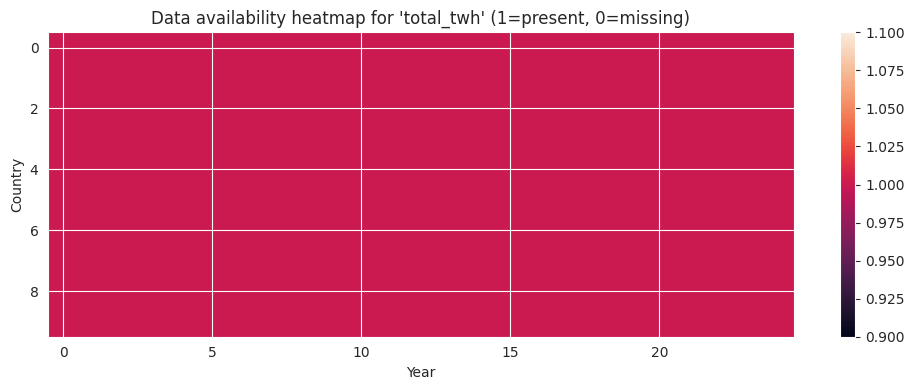


IQR outlier share (%):


variable  pct_outliers
0          total_twh           0.0
1     per_capita_kwh           0.0
2          co2_mtons           0.0
3  price_usd_per_kwh           0.0

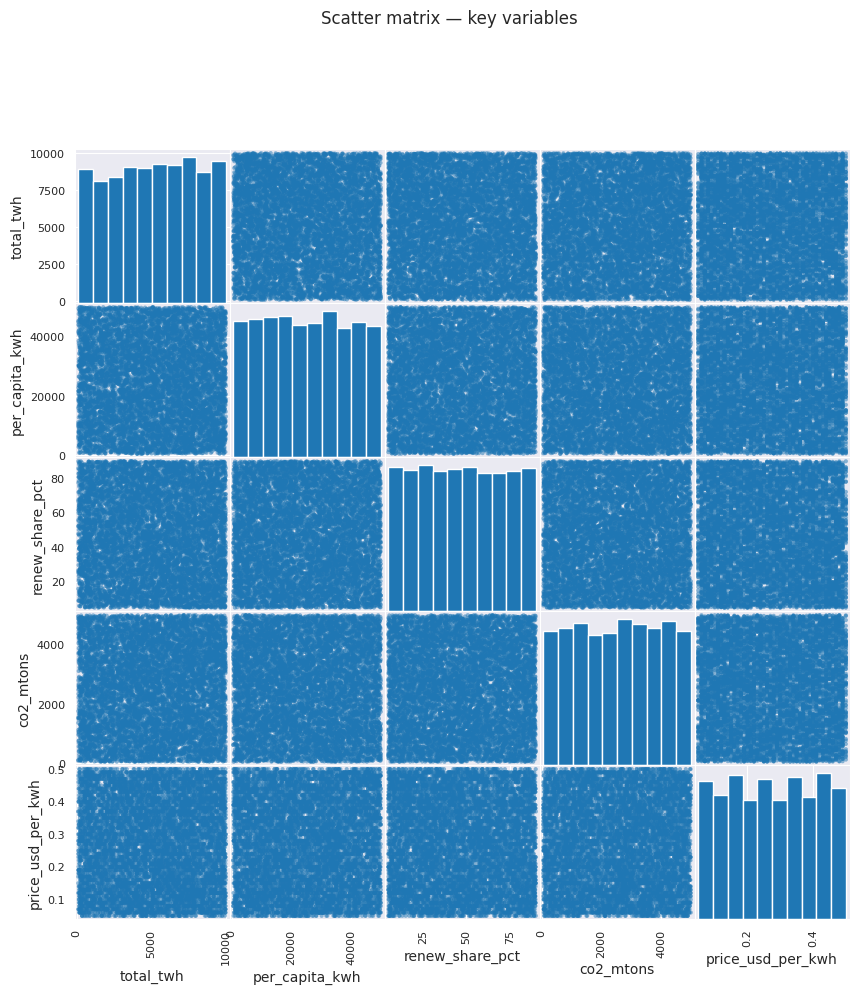


PCA — explained variance ratio:


component  explained_variance_ratio
0       PC1                     0.167
1       PC2                     0.115
2       PC3                     0.114
3       PC4                     0.114
4       PC5                     0.111

VIF (higher => more collinearity):


feature       vif
8  carbon_intensity_tons_per_twh  1.352115
0                      total_twh  1.266169
6                      co2_mtons  1.091575
7              price_usd_per_kwh  1.001241
2                renew_share_pct  1.001133
1                 per_capita_kwh  1.000946
4                 industrial_pct  1.000871
5                  household_pct  1.000773
3               fossil_share_pct  1.000320


Engineered feature sample:


country  year  total_twh  per_capita_kwh  renew_share_pct  \
108   Australia  2000    5892.49        32333.13            29.01   
554   Australia  2000    3982.07        34832.51            57.65   
729   Australia  2000    3493.13        27097.18            56.51   
1027  Australia  2000    2592.27        24447.77            47.42   
1420  Australia  2000    1079.63        34928.05            64.12   
1500  Australia  2000     936.98        23021.20            19.32   
1538  Australia  2000     506.56         2427.91            24.68   
1599  Australia  2000     689.49        37230.62            61.16   
1605  Australia  2000    3678.74        46559.34             7.70   
1711  Australia  2000    5761.80        48882.31            18.23   
1761  Australia  2000    6827.56        18246.85            17.94   
2076  Australia  2000    6986.29        40843.42            54.96   

      fossil_share_pct  industrial_pct  household_pct  co2_mtons  \
108              38.07           59.32          15.82    2781.88   
554              66.14           53.42          34.44    4873.59   
729              72.36           53.01          37.47     586.80   
1027             20.03           45.36          31.30     146.16   
1420             24.62           39.52          34.89    3546.03   
1500             45.10           33.90          22.29    4093.80   
1538             73.25           52.84          17.45    3213.21   
1599             36.93           28.59          26.34    1246.94   
1605             54.24           40.68          35.64    3401.52   
1711             19.14           20.04          15.04    4006.78   
1761             10.62           30.47          30.63    2302.15   
2076             29.58           45.86          12.82     950.36   

      price_usd_per_kwh  ...  per_capita_kwh_lag1  per_capita_kwh_lag2  \
108                0.15  ...                  NaN                  NaN   
554                0.31  ...             32333.13                  NaN   
729                0.38  ...             34832.51             32333.13   
1027               0.16  ...             27097.18             34832.51   
1420               0.37  ...             24447.77             27097.18   
1500               0.38  ...             34928.05             24447.77   
1538               0.38  ...             23021.20             34928.05   
1599               0.42  ...              2427.91             23021.20   
1605               0.32  ...             37230.62              2427.91   
1711               0.13  ...             46559.34             37230.62   
1761               0.48  ...             48882.31             46559.34   
2076               0.15  ...             18246.85             48882.31   

      price_usd_per_kwh_lag1  price_usd_per_kwh_lag2  renew_share_pct_lag1  \
108                      NaN                     NaN                   NaN   
554                     0.15                     NaN                 29.01   
729                     0.31                    0.15                 57.65   
1027                    0.38                    0.31                 56.51   
1420                    0.16                    0.38                 47.42   
1500                    0.37                    0.16                 64.12   
1538                    0.38                    0.37                 19.32   
1599                    0.38                    0.38                 24.68   
1605                    0.42                    0.38                 61.16   
1711                    0.32                    0.42                  7.70   
1761                    0.13                    0.32                 18.23   
2076                    0.48                    0.13                 17.94   

      renew_share_pct_lag2  fossil_share_pct_lag1  fossil_share_pct_lag2  \
108                    NaN                    NaN                    NaN   
554                    NaN                  38.07                    NaN   
729                

Saved engineered features to: /content/energy_outputs/eda/engineered_features_eda.csv


In [11]:
# ============================================================
# Advanced EDA & Feature Engineering (no models, no forecasting)
# - Quality checks & coverage diagnostics
# - Outlier scans (IQR-based)
# - Bivariate EDA (scatter matrix for key vars)
# - Collinearity diagnostics (PCA & VIF)
# - Richer engineered features (ratios, logs, per-capita)
# - Saves a tidy feature set for later modeling
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

EDA_OUT = Path("/content/energy_outputs/eda")
EDA_OUT.mkdir(parents=True, exist_ok=True)

# ---------- 0) Helpers ----------
def safe_cols(cols):
    "Return only columns that actually exist in df."
    return [c for c in cols if c in df.columns]

def iqr_outlier_flags(s, k=1.5):
    "Return a boolean Series where True marks outliers under Tukey's rule."
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    if pd.isna(iqr) or iqr == 0:
        return pd.Series(False, index=s.index)
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return (s < lower) | (s > upper)

def compute_vif(df_num):
    """
    Variance Inflation Factor per column using sklearn LinearRegression.
    VIF = 1 / (1 - R^2) when regressing each variable on the others.
    """
    cols = df_num.columns.tolist()
    vif_rows = []
    for i, col in enumerate(cols):
        X = df_num.drop(columns=[col]).values
        y = df_num[col].values
        # Skip if constant or insufficient data
        if np.nanstd(y) == 0 or X.shape[1] == 0:
            vif_rows.append((col, np.nan))
            continue
        # Drop rows with NaNs
        mask = ~np.isnan(y) & ~np.isnan(X).any(axis=1)
        if mask.sum() < max(10, X.shape[1] + 2):
            vif_rows.append((col, np.nan))
            continue
        reg = LinearRegression().fit(X[mask], y[mask])
        r2 = reg.score(X[mask], y[mask])
        vif = np.inf if (1 - r2) <= 1e-9 else 1.0 / max(1e-9, (1 - r2))
        vif_rows.append((col, vif))
    return pd.DataFrame(vif_rows, columns=["feature","vif"])

# ---------- 1) Quality checks ----------
print("Rows:", len(df))
print("Countries:", df['country'].nunique() if 'country' in df else "NA")
print("Years span:", int(df['year'].min()), "→", int(df['year'].max()))

# Duplicates (exact duplicate rows)
dupes = df.duplicated().sum()
print("Exact duplicate rows:", dupes)

# Duplicates by (country, year)
if {'country','year'}.issubset(df.columns):
    dup_key = df.duplicated(subset=['country','year']).sum()
    print("Duplicate (country,year) pairs:", dup_key)

# ---------- 2) Coverage diagnostics ----------
# 2a) Missingness by column (again, to store)
present_cols = safe_cols([
    'year','total_twh','per_capita_kwh','renew_share_pct','fossil_share_pct',
    'industrial_pct','household_pct','co2_mtons','price_usd_per_kwh',
    'carbon_intensity_tons_per_twh'
])
missing = df[present_cols].isna().mean().mul(100).round(2).reset_index()
missing.columns = ["column","missing_pct"]
print("\nMissingness by column (%):")
display(missing)

# 2b) Completeness heatmap (country × year) for a key variable (choose total_twh if present)
key_var = 'total_twh' if 'total_twh' in df.columns else present_cols[0]
if {'country','year'}.issubset(df.columns) and key_var in df.columns:
    comp = df.pivot_table(index='country', columns='year', values=key_var, aggfunc='size')
    comp = comp.notna().astype(int)  # 1 if data present in that year for that country
    # Plot a simple heatmap (many countries => tall figure)
    plt.figure(figsize=(10, min(12, 0.2*comp.shape[0] + 2)))
    plt.imshow(comp, aspect='auto', interpolation='nearest')
    plt.title(f"Data availability heatmap for '{key_var}' (1=present, 0=missing)")
    plt.xlabel("Year"); plt.ylabel("Country")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# ---------- 3) Outlier scans (IQR) ----------
# We scan per variable globally (you can also scan per-year to account for trend)
scan_vars = safe_cols(['total_twh','per_capita_kwh','co2_mtons','price_usd_per_kwh'])
outlier_report = []
for v in scan_vars:
    flags = iqr_outlier_flags(df[v].dropna())
    share = 100 * flags.mean().round(4) if len(flags) else 0.0
    outlier_report.append((v, share))
outlier_df = pd.DataFrame(outlier_report, columns=['variable','pct_outliers'])
print("\nIQR outlier share (%):")
display(outlier_df)

# ---------- 4) Bivariate EDA: pairwise scatter for key variables ----------
pair_vars = safe_cols(['total_twh','per_capita_kwh','renew_share_pct','co2_mtons','price_usd_per_kwh'])
if len(pair_vars) >= 2:
    pd.plotting.scatter_matrix(df[pair_vars].dropna(), figsize=(10, 10))
    plt.suptitle("Scatter matrix — key variables", y=1.02)
    plt.show()

# ---------- 5) Collinearity: PCA + VIF ----------
# (a) PCA on standardized numeric variables to visualize redundancy
num_for_pca = safe_cols(['total_twh','per_capita_kwh','renew_share_pct','fossil_share_pct',
                         'industrial_pct','household_pct','co2_mtons','price_usd_per_kwh',
                         'carbon_intensity_tons_per_twh'])
num_df = df[num_for_pca].dropna()
if len(num_for_pca) >= 2 and len(num_df) >= 50:
    X_std = StandardScaler().fit_transform(num_df.values)
    pca = PCA(n_components=min(5, X_std.shape[1]))
    pca.fit(X_std)
    pca_var = pd.DataFrame({
        'component': [f'PC{i+1}' for i in range(pca.n_components_)],
        'explained_variance_ratio': np.round(pca.explained_variance_ratio_, 3)
    })
    print("\nPCA — explained variance ratio:")
    display(pca_var)
else:
    print("\nPCA skipped (not enough numeric data).")

# (b) VIF to quantify multicollinearity
if len(num_for_pca) >= 2:
    # Use a lighter subset for VIF to avoid trivial multicollinearity (e.g., total_twh & fossil/renew TWh later)
    vif_input = df[num_for_pca].dropna()
    if len(vif_input) > 50:
        vif_table = compute_vif(vif_input)
        print("VIF (higher => more collinearity):")
        display(vif_table.sort_values('vif', ascending=False))
    else:
        print("VIF skipped (insufficient rows after dropna).")

# ---------- 6) Richer Feature Engineering ----------
fe2 = df.sort_values(['country','year']).copy()

# 6a) Shares & ratios
if {'renew_share_pct','fossil_share_pct'}.issubset(fe2.columns):
    fe2['renew_to_fossil_ratio'] = np.where(fe2['fossil_share_pct'] > 0,
                                            fe2['renew_share_pct'] / fe2['fossil_share_pct'],
                                            np.nan)

if {'industrial_pct','household_pct'}.issubset(fe2.columns):
    fe2['ind_to_house_ratio'] = np.where(fe2['household_pct'] > 0,
                                         fe2['industrial_pct'] / fe2['household_pct'],
                                         np.nan)
    # Residual/other sector share if % do not sum to 100
    fe2['other_sector_pct'] = 100.0 - (fe2['industrial_pct'].fillna(0) + fe2['household_pct'].fillna(0))

# 6b) Level decompositions (TWh equivalents)
if {'total_twh','renew_share_pct'}.issubset(fe2.columns):
    fe2['renew_twh'] = fe2['total_twh'] * fe2['renew_share_pct'] / 100.0
if {'total_twh','fossil_share_pct'}.issubset(fe2.columns):
    fe2['fossil_twh'] = fe2['total_twh'] * fe2['fossil_share_pct'] / 100.0

# 6c) Per-capita CO2 if population implied (not present) — we can't compute true per-capita CO2 without population.
#     But we can compute CO2 per kWh per capita as a proxy if both exist:
if {'co2_mtons','per_capita_kwh'}.issubset(fe2.columns):
    # CO2 per kWh per-capita proxy (million tons / kWh-per-capita) — purely diagnostic, not a standard metric
    fe2['co2_mtons_per_kwh_per_capita'] = np.where(fe2['per_capita_kwh'] > 0,
                                                   fe2['co2_mtons'] / fe2['per_capita_kwh'],
                                                   np.nan)

# 6d) Logs (handle non-positive safely)
for c in ['total_twh','per_capita_kwh','co2_mtons','price_usd_per_kwh']:
    if c in fe2.columns:
        fe2[f'log_{c}'] = np.where(fe2[c] > 0, np.log(fe2[c]), np.nan)

# 6e) Country-standardized z-scores (how far a point is from its own country's norm)
for c in ['total_twh','per_capita_kwh','co2_mtons','price_usd_per_kwh','renew_share_pct','fossil_share_pct']:
    if c in fe2.columns:
        fe2[f'z_{c}_within_country'] = fe2.groupby('country')[c].transform(
            lambda s: (s - s.mean()) / s.std(ddof=0) if s.std(ddof=0) not in [0, np.nan] else 0
        )

# 6f) Rolling (3-year) within-country smoothers
for c in ['total_twh','per_capita_kwh','price_usd_per_kwh','co2_mtons','renew_share_pct']:
    if c in fe2.columns:
        fe2[f'ma3_{c}'] = fe2.groupby('country')[c].transform(lambda s: s.rolling(3, min_periods=1).mean())

# 6g) Lags (1, 2) for key variables
for c in ['total_twh','per_capita_kwh','price_usd_per_kwh','renew_share_pct','fossil_share_pct','co2_mtons']:
    if c in fe2.columns:
        fe2[f'{c}_lag1'] = fe2.groupby('country')[c].shift(1)
        fe2[f'{c}_lag2'] = fe2.groupby('country')[c].shift(2)

print("\nEngineered feature sample:")
display(fe2.head(12))

# Save engineered features (EDA version)
fe2_path = EDA_OUT / "engineered_features_eda.csv"
fe2.to_csv(fe2_path, index=False)
print("Saved engineered features to:", fe2_path)


/tmp/ipython-input-2894424069.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


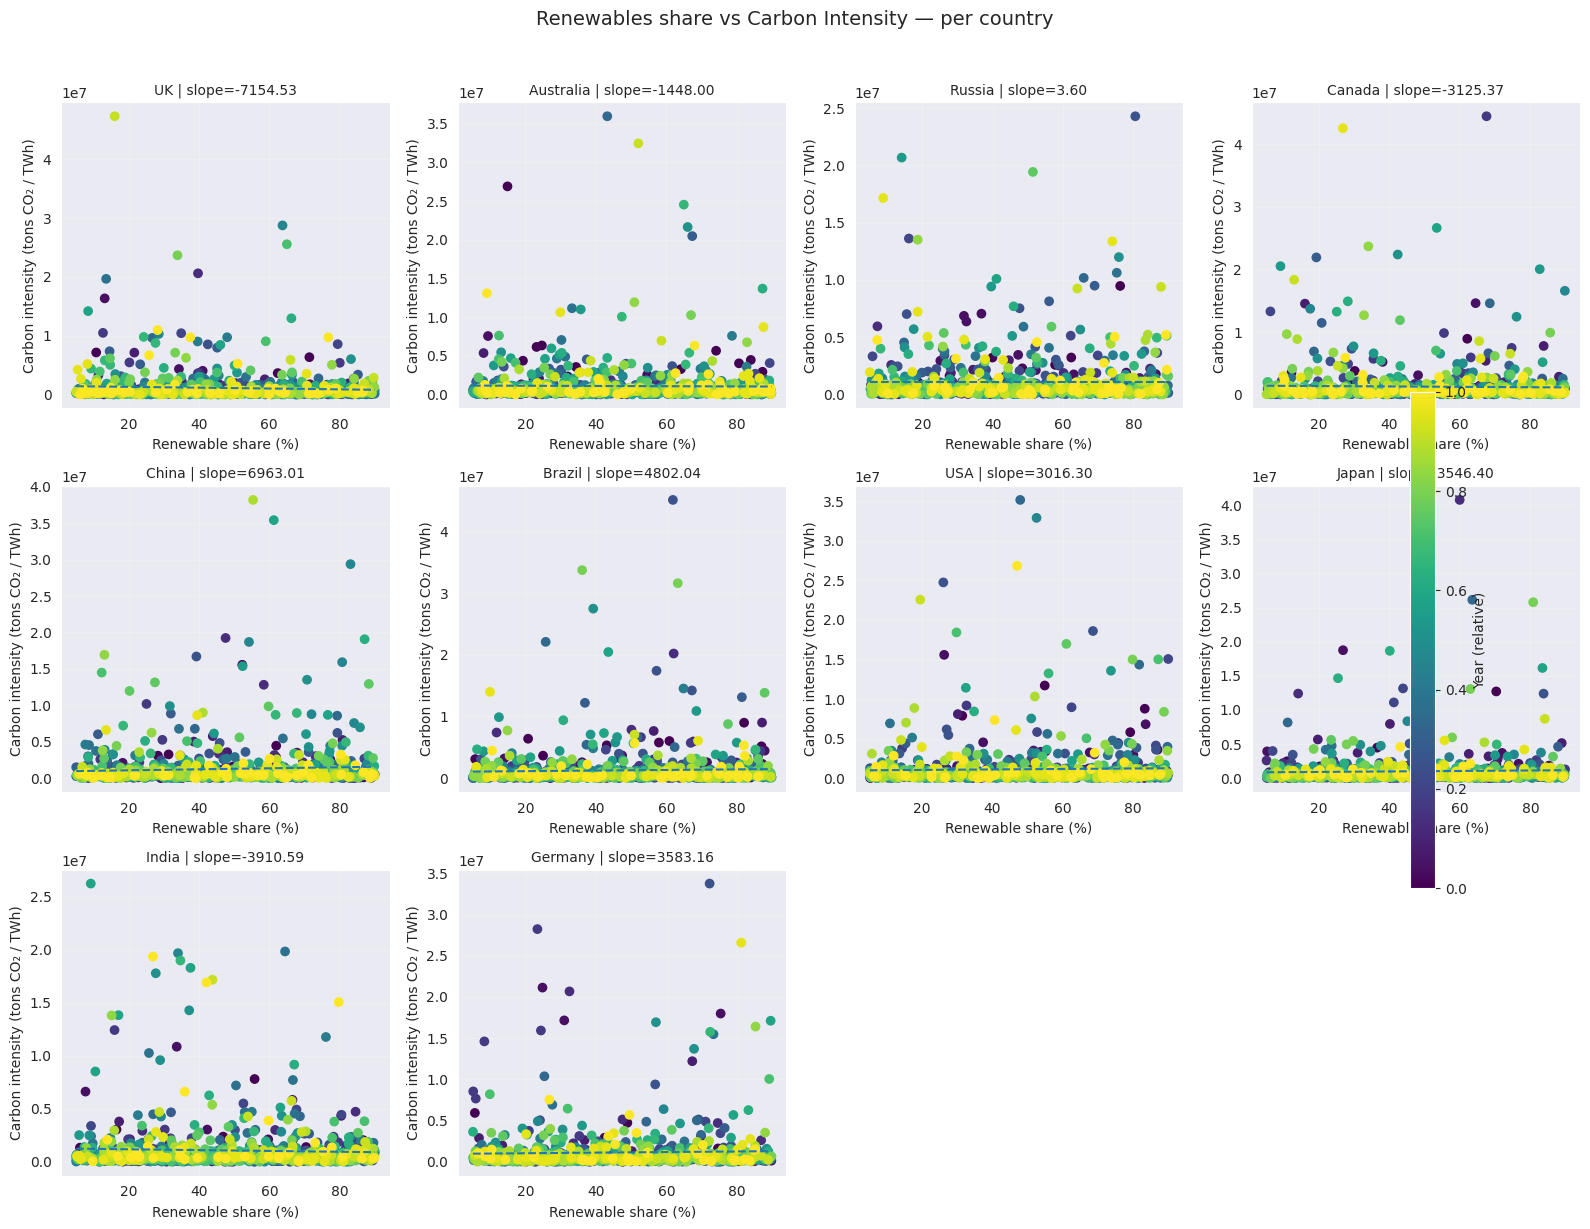

Saved figure: /content/energy_outputs/eda/panels_renew_vs_intensity.png


/tmp/ipython-input-2894424069.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


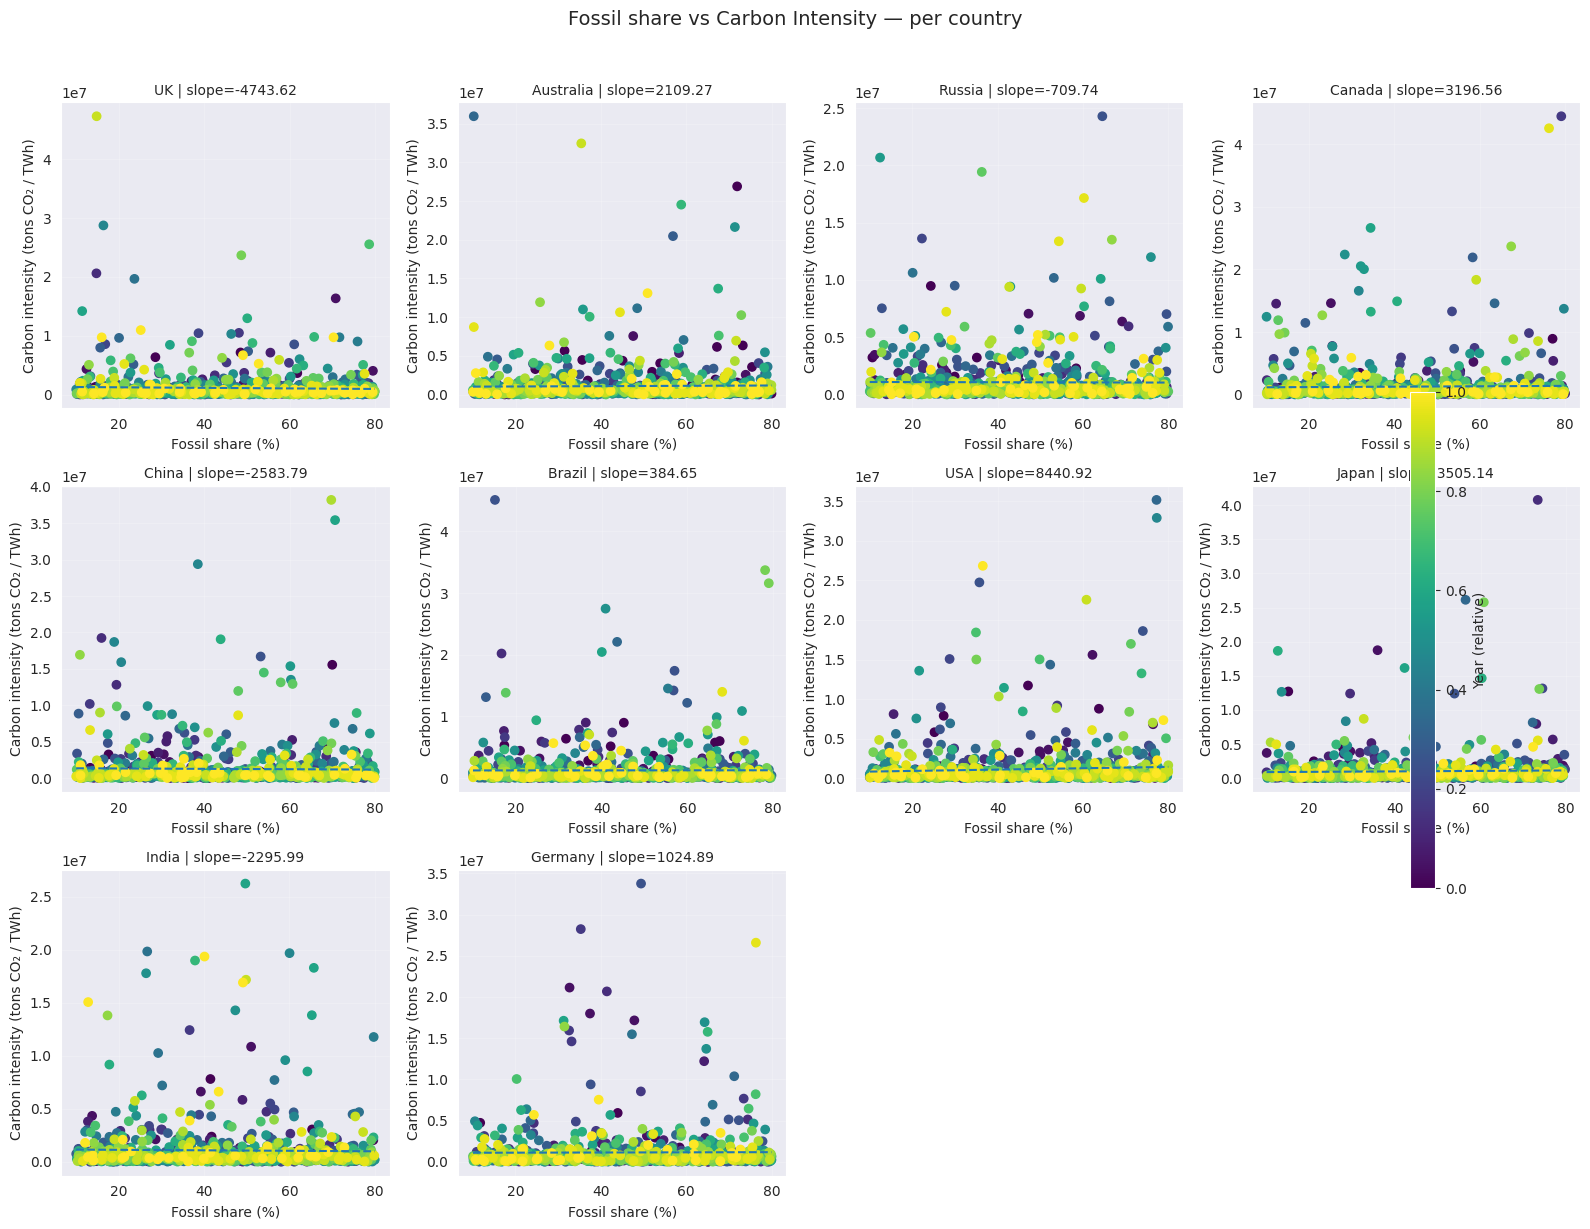

Saved figure: /content/energy_outputs/eda/panels_fossil_vs_intensity.png


In [12]:
# ============================================================
# Sector mix vs Carbon Intensity — Panel Charts (Matplotlib)
# - Panels per country (auto: top-K by latest total_twh)
# - X: renew_share_pct or fossil_share_pct
# - Y: carbon_intensity_tons_per_twh
# - Optional year-coloring; lightweight linear trend per panel
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

EDA_OUT = Path("/content/energy_outputs/eda")
EDA_OUT.mkdir(parents=True, exist_ok=True)

# 0) Ensure required columns exist / derive if needed
needed_cols = {'country','year','renew_share_pct','fossil_share_pct','total_twh'}
missing = [c for c in needed_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns for sector-mix panels: {missing}")

if 'carbon_intensity_tons_per_twh' not in df.columns:
    if {'co2_mtons','total_twh'}.issubset(df.columns):
        df['carbon_intensity_tons_per_twh'] = (df['co2_mtons']*1e6) / df['total_twh'].replace(0, np.nan)
    else:
        raise ValueError("Need co2_mtons & total_twh to compute carbon_intensity_tons_per_twh.")

# 1) Helper: choose countries (top-K by latest total_twh)
def top_k_countries_by_latest_total_twh(k=12):
    latest_year = int(df['year'].max())
    latest = df[df['year'] == latest_year]
    if latest.empty:
        # fallback: use overall mean if latest-year sparse
        by_avg = df.groupby('country', as_index=False)['total_twh'].mean().sort_values('total_twh', ascending=False)
        return by_avg['country'].head(k).tolist()
    picks = (latest.groupby('country', as_index=False)['total_twh']
                   .sum()
                   .sort_values('total_twh', ascending=False)['country']
                   .head(k)
                   .tolist())
    return picks

# 2) Core plotting function
def plot_mix_vs_intensity_panels(countries=None, k=12, color_by_year=True, ncols=4, figsize=(16,12),
                                 add_linear_fit=True, x_var='renew_share_pct', title_prefix='Renewables'):
    """
    Make a panel chart: x_var (% share) vs carbon intensity, one subplot per country.
    x_var: 'renew_share_pct' or 'fossil_share_pct'
    """
    assert x_var in ['renew_share_pct','fossil_share_pct'], "x_var must be renew_share_pct or fossil_share_pct"

    if countries is None:
        countries = top_k_countries_by_latest_total_twh(k=k)

    sub = df[df['country'].isin(countries)].copy()
    sub = sub.dropna(subset=[x_var, 'carbon_intensity_tons_per_twh', 'year']).sort_values(['country','year'])

    # Grid size
    n = len(countries)
    ncols = min(ncols, n) if n > 0 else ncols
    nrows = int(np.ceil(n / ncols)) if n > 0 else 1

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes = axes.ravel()

    # Normalize years for coloring if needed
    if color_by_year:
        years = sub['year'].values.astype(float)
        year_min, year_max = float(np.nanmin(years)), float(np.nanmax(years))
        denom = (year_max - year_min) if year_max > year_min else 1.0

    for i, ctry in enumerate(countries):
        ax = axes[i]
        d = sub[sub['country'] == ctry].dropna(subset=[x_var, 'carbon_intensity_tons_per_twh'])
        if d.empty:
            ax.set_title(f"{ctry} — no data")
            ax.axis('off')
            continue

        x = d[x_var].values
        y = d['carbon_intensity_tons_per_twh'].values

        # Scatter (optionally color by year)
        if color_by_year:
            colors = (d['year'].astype(float) - year_min) / denom
            sc = ax.scatter(x, y, c=colors, cmap='viridis')
        else:
            ax.scatter(x, y)

        # Lightweight linear fit if enough points
        slope_text = ""
        if add_linear_fit and len(d) >= 3 and np.isfinite(x).sum() >= 3 and np.isfinite(y).sum() >= 3:
            try:
                m, b = np.polyfit(x, y, 1)
                xs = np.linspace(np.nanmin(x), np.nanmax(x), 50)
                ax.plot(xs, m*xs + b, linestyle='--')
                slope_text = f" | slope={m:.2f}"
            except Exception:
                pass

        ax.set_xlabel(f"{'Renewable' if x_var=='renew_share_pct' else 'Fossil'} share (%)")
        ax.set_ylabel("Carbon intensity (tons CO₂ / TWh)")
        ax.set_title(f"{ctry}{slope_text}", fontsize=10)
        ax.grid(True, alpha=0.2)

    # Hide any extra axes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    # Colorbar for years
    if color_by_year:
        cbar = fig.colorbar(sc, ax=axes[:n], orientation='vertical', fraction=0.02, pad=0.02)
        cbar.set_label("Year (relative)")

    fig.suptitle(f"{title_prefix} share vs Carbon Intensity — per country", y=1.02, fontsize=14)
    fig.tight_layout()

    # Save
    fname = f"panels_{'renew' if x_var=='renew_share_pct' else 'fossil'}_vs_intensity.png"
    out_path = EDA_OUT / fname
    fig.savefig(out_path, bbox_inches='tight', dpi=150)
    plt.show()
    print("Saved figure:", out_path)

# 3) RUN: Renewables vs Intensity panels (auto top-12 countries)
plot_mix_vs_intensity_panels(countries=None, k=12, color_by_year=True, ncols=4,
                             figsize=(16,12), add_linear_fit=True,
                             x_var='renew_share_pct', title_prefix='Renewables')

# 4) RUN: Fossils vs Intensity panels (same countries for easy comparison)
plot_mix_vs_intensity_panels(countries=None, k=12, color_by_year=True, ncols=4,
                             figsize=(16,12), add_linear_fit=True,
                             x_var='fossil_share_pct', title_prefix='Fossil')


/tmp/ipython-input-312121733.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


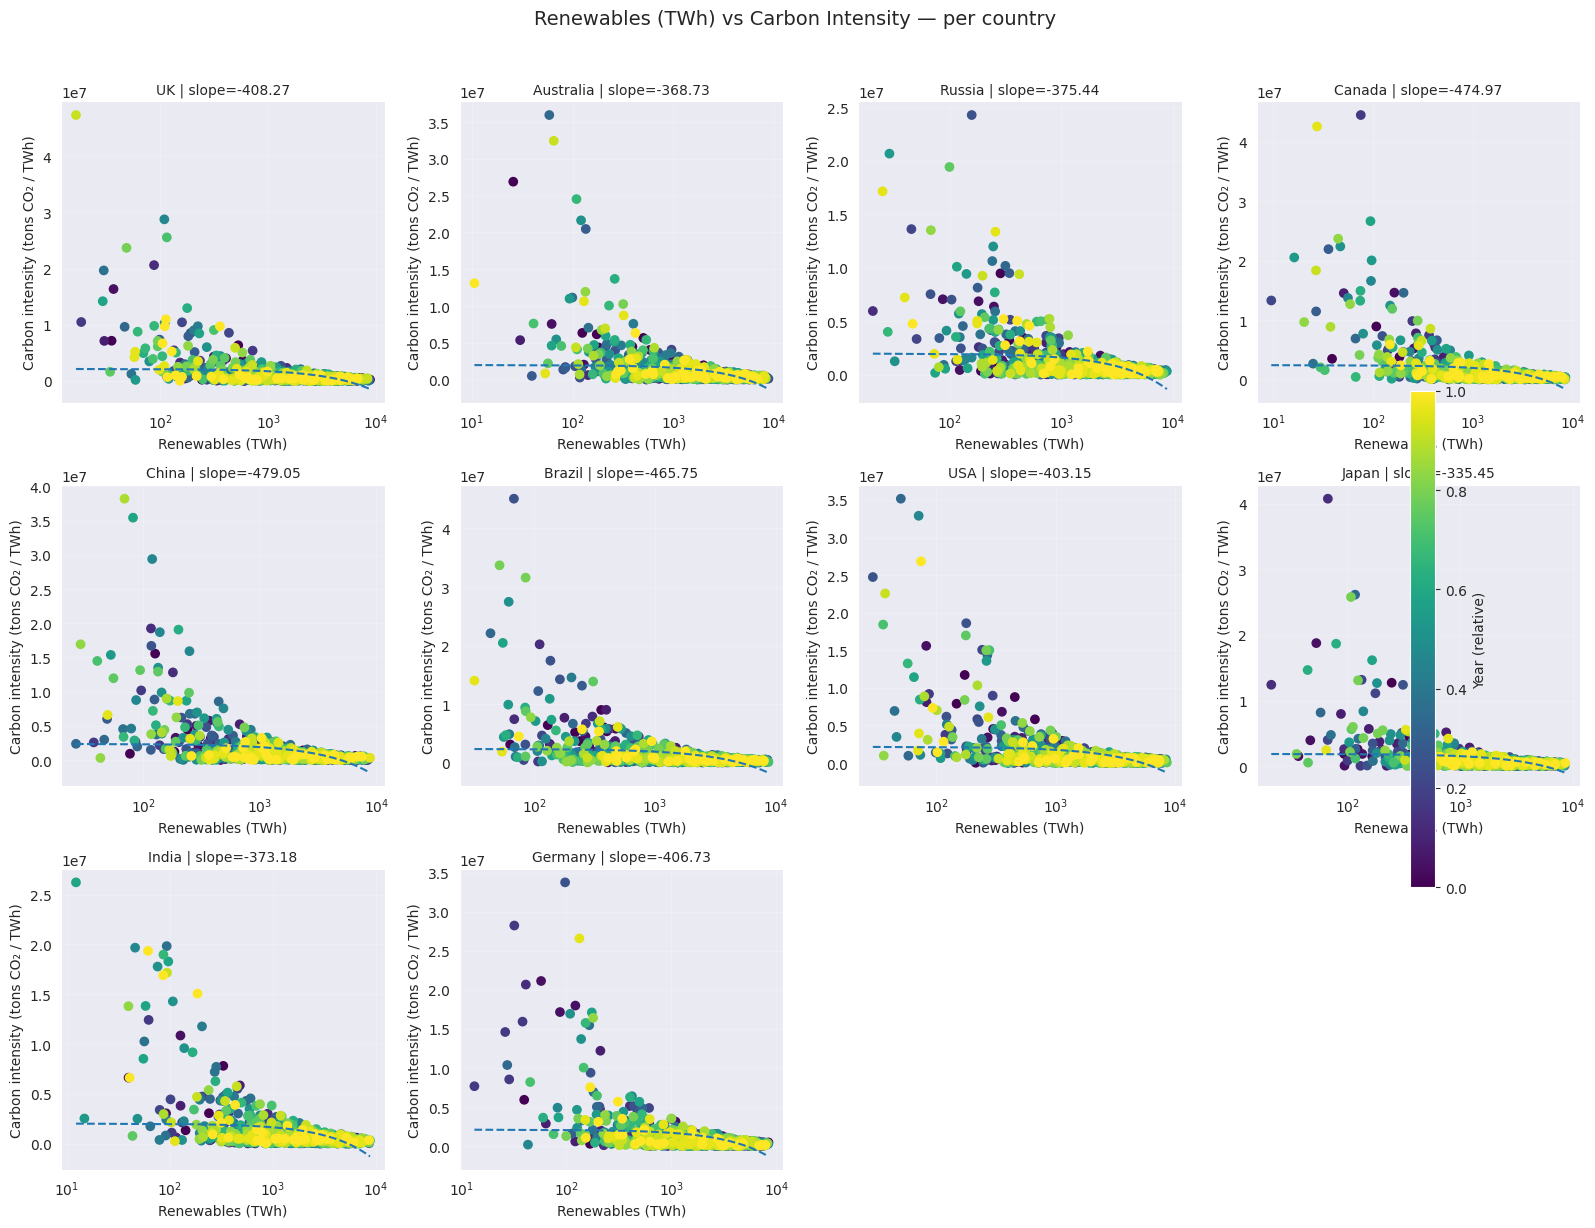

Saved figure: /content/energy_outputs/eda/panels_renew_twh_vs_intensity.png


/tmp/ipython-input-312121733.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


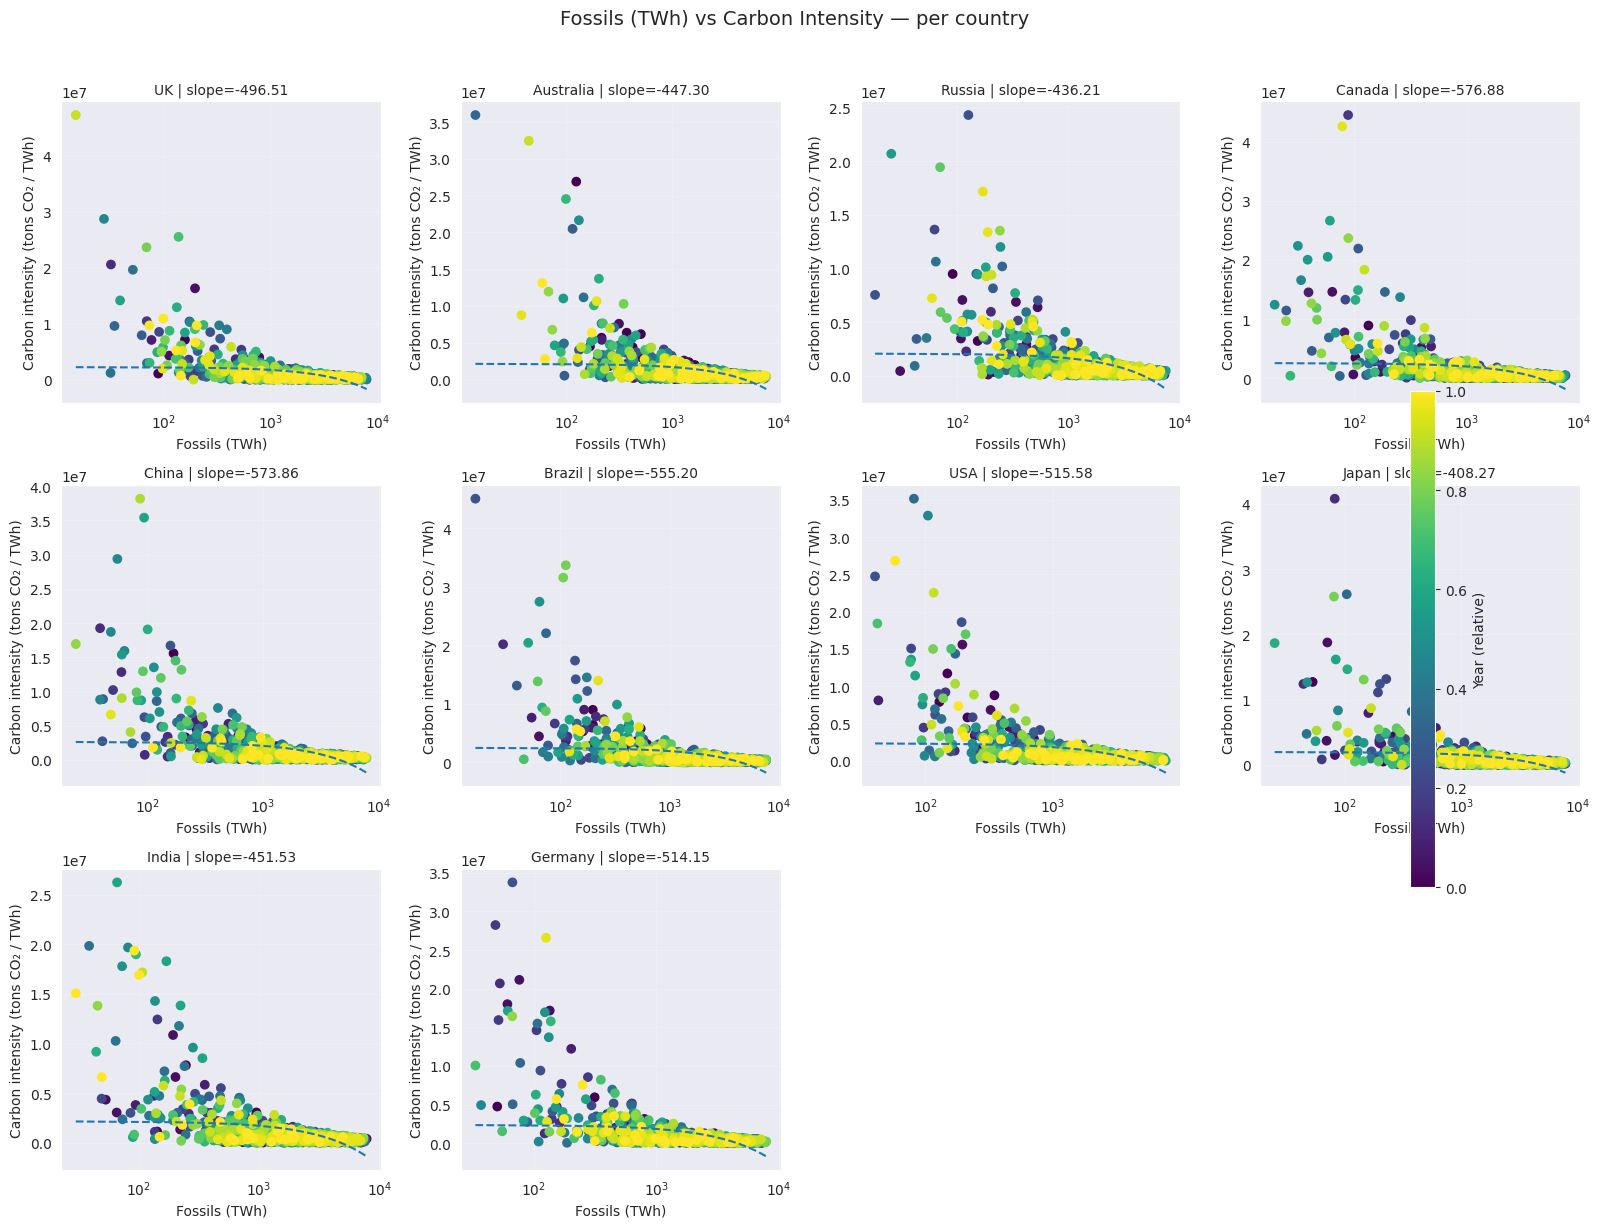

Saved figure: /content/energy_outputs/eda/panels_fossil_twh_vs_intensity.png

Per-country regression summary: intensity ~ X


country             x_var     n        slope     intercept  \
0          UK   renew_share_pct  1034 -7154.530963  1.450357e+06   
1       China   renew_share_pct   985  6963.007120  9.413570e+05   
2       India   renew_share_pct   996 -3910.594746  1.266990e+06   
3      Brazil   renew_share_pct   962  4802.040376  1.046940e+06   
4       Japan   renew_share_pct   994  3546.401626  8.467781e+05   
5     Germany   renew_share_pct   971  3583.156419  9.761580e+05   
6         USA   renew_share_pct  1053  3016.297632  9.854739e+05   
7      Canada   renew_share_pct  1017 -3125.368273  1.417829e+06   
8   Australia   renew_share_pct  1021 -1448.003881  1.162946e+06   
9      Russia   renew_share_pct   967     3.596930  1.072017e+06   
10        USA  fossil_share_pct  1053  8440.924857  7.506521e+05   
11         UK  fossil_share_pct  1034 -4743.619471  1.324525e+06   
12      Japan  fossil_share_pct   994  3505.141723  8.577278e+05   
13     Canada  fossil_share_pct  1017  3196.562402  1.127385e+06   
14      India  fossil_share_pct   996 -2295.987698  1.183937e+06   
15      China  fossil_share_pct   985 -2583.790468  1.387362e+06   
16  Australia  fossil_share_pct  1021  2109.267036  9.992792e+05   
17    Germany  fossil_share_pct   971  1024.892367  1.095697e+06   
18     Russia  fossil_share_pct   967  -709.740982  1.103993e+06   
19     Brazil  fossil_share_pct   962   384.651185  1.255230e+06   

              r2          rmse   p_slope  
0   4.314613e-03  2.705448e+06  0.034694  
1   3.338115e-03  2.891302e+06  0.069908  
2   1.682465e-03  2.343232e+06  0.195866  
3   1.520024e-03  3.038022e+06  0.226998  
4   1.229683e-03  2.430570e+06  0.269364  
5   1.048878e-03  2.695552e+06  0.313381  
6   7.517756e-04  2.740919e+06  0.374089  
7   5.953676e-04  3.188079e+06  0.436987  
8   2.129062e-04  2.505218e+06  0.641437  
9   1.833921e-09  2.051424e+06  0.998939  
10  3.879603e-03  2.736625e+06  0.043305  
11  1.289411e-03  2.709555e+06  0.248648  
12  8.506633e-04  2.431031e+06  0.358315  
13  4.180749e-04  3.188362e+06  0.514836  
14  3.850837e-04  2.344754e+06  0.536186  
15  3.245228e-04  2.895670e+06  0.572272  
16  2.897898e-04  2.505121e+06  0.586911  
17  5.717597e-05  2.696890e+06  0.813959  
18  4.954637e-05  2.051374e+06  0.826957  
19  6.425111e-06  3.040324e+06  0.937417

Saved regression summary to: /content/energy_outputs/eda/intensity_regression_summary.csv


In [13]:
# ============================================================
# EXTRA: Mix (TWh) vs Carbon Intensity Panels + Regression Summary
# - Adds renew_twh & fossil_twh panels (level-based, not just shares)
# - Provides a per-country regression summary: intensity ~ X
#   (works for X in: renew_share_pct, fossil_share_pct, renew_twh, fossil_twh)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

EDA_OUT = Path("/content/energy_outputs/eda")
EDA_OUT.mkdir(parents=True, exist_ok=True)

# ---------- 0) Ensure needed columns exist (derive if missing) ----------
need_base = {'country','year','total_twh'}
if not need_base.issubset(df.columns):
    raise ValueError(f"df is missing {need_base - set(df.columns)}")

# Carbon intensity (tons CO2 / TWh)
if 'carbon_intensity_tons_per_twh' not in df.columns:
    if {'co2_mtons','total_twh'}.issubset(df.columns):
        df['carbon_intensity_tons_per_twh'] = (df['co2_mtons'] * 1e6) / df['total_twh'].replace(0, np.nan)
    else:
        raise ValueError("Need 'co2_mtons' & 'total_twh' to compute carbon_intensity_tons_per_twh")

# Renewables/Fossils TWh levels
if {'renew_share_pct','total_twh'}.issubset(df.columns) and 'renew_twh' not in df.columns:
    df['renew_twh'] = df['total_twh'] * df['renew_share_pct'] / 100.0
if {'fossil_share_pct','total_twh'}.issubset(df.columns) and 'fossil_twh' not in df.columns:
    df['fossil_twh'] = df['total_twh'] * df['fossil_share_pct'] / 100.0

# ---------- 1) Utilities ----------
def top_k_countries_by_latest_total_twh(df_in, k=12):
    latest_year = int(df_in['year'].max())
    latest = df_in[df_in['year'] == latest_year]
    if latest.empty:
        by_avg = df_in.groupby('country', as_index=False)['total_twh'].mean().sort_values('total_twh', ascending=False)
        return by_avg['country'].head(k).tolist()
    picks = (latest.groupby('country', as_index=False)['total_twh']
                   .sum()
                   .sort_values('total_twh', ascending=False)['country']
                   .head(k).tolist())
    return picks

def panel_plot(df_in, countries=None, k=12, x_var='renew_twh', title_prefix='Renewables TWh',
               color_by_year=True, add_linear_fit=True, ncols=4, figsize=(16,12), log_x=False, log_y=False):
    """
    Make per-country panels: x_var vs carbon_intensity_tons_per_twh.
    x_var can be: 'renew_share_pct', 'fossil_share_pct', 'renew_twh', 'fossil_twh'
    """
    if countries is None:
        countries = top_k_countries_by_latest_total_twh(df_in, k=k)

    req = {'country','year','carbon_intensity_tons_per_twh', x_var}
    if not req.issubset(df_in.columns):
        raise ValueError(f"Missing required columns for panel: {req - set(df_in.columns)}")

    sub = (df_in[df_in['country'].isin(countries)]
           .dropna(subset=[x_var, 'carbon_intensity_tons_per_twh', 'year'])
           .sort_values(['country','year']))

    n = len(countries)
    ncols = min(ncols, max(1, n))
    nrows = int(np.ceil(n / ncols)) if n > 0 else 1

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes = axes.ravel()

    # Normalize years for coloring if needed
    if color_by_year and not sub.empty:
        years = sub['year'].astype(float).values
        year_min, year_max = float(np.nanmin(years)), float(np.nanmax(years))
        denom = (year_max - year_min) if year_max > year_min else 1.0

    sc_last = None
    for i, ctry in enumerate(countries):
        ax = axes[i]
        d = sub[sub['country'] == ctry]
        if d.empty:
            ax.set_title(f"{ctry} — no data")
            ax.axis('off')
            continue

        x = d[x_var].values
        y = d['carbon_intensity_tons_per_twh'].values

        if color_by_year:
            colors = (d['year'].astype(float) - year_min) / denom if denom != 0 else np.zeros_like(y)
            sc_last = ax.scatter(x, y, c=colors, cmap='viridis')
        else:
            sc_last = ax.scatter(x, y)

        # Optional log scales
        if log_x:
            ax.set_xscale('log')
        if log_y:
            ax.set_yscale('log')

        # Lightweight linear fit
        slope_text = ""
        if add_linear_fit and len(d) >= 3 and np.isfinite(x).sum() >= 3 and np.isfinite(y).sum() >= 3:
            try:
                m, b = np.polyfit(x, y, 1)
                xs = np.linspace(np.nanmin(x), np.nanmax(x), 50)
                ax.plot(xs, m*xs + b, linestyle='--')
                slope_text = f" | slope={m:.2f}"
            except Exception:
                pass

        # Labels/titles
        x_label = {
            'renew_share_pct': 'Renewable share (%)',
            'fossil_share_pct':'Fossil share (%)',
            'renew_twh':'Renewables (TWh)',
            'fossil_twh':'Fossils (TWh)'
        }.get(x_var, x_var)

        ax.set_xlabel(x_label)
        ax.set_ylabel("Carbon intensity (tons CO₂ / TWh)")
        ax.set_title(f"{ctry}{slope_text}", fontsize=10)
        ax.grid(True, alpha=0.2)

    # Hide extras
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    # Colorbar
    if color_by_year and sc_last is not None:
        cbar = fig.colorbar(sc_last, ax=axes[:n], orientation='vertical', fraction=0.02, pad=0.02)
        cbar.set_label("Year (relative)")

    fig.suptitle(f"{title_prefix} vs Carbon Intensity — per country", y=1.02, fontsize=14)
    fig.tight_layout()

    # Save
    fname = f"panels_{x_var}_vs_intensity.png"
    out_path = EDA_OUT / fname
    fig.savefig(out_path, bbox_inches='tight', dpi=150)
    plt.show()
    print("Saved figure:", out_path)
    return out_path

# ---------- 2) Regression summary per country ----------
# intensity ~ X (with intercept). Returns slope, intercept, R^2, RMSE, n, (optional p if scipy present)
try:
    from scipy.stats import t as tdist
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

def regress_intensity_on(df_in, x_var='renew_share_pct'):
    req = {'country','year','carbon_intensity_tons_per_twh', x_var}
    if not req.issubset(df_in.columns):
        raise ValueError(f"Missing columns for regression: {req - set(df_in.columns)}")
    rows = []
    for ctry, g in df_in.dropna(subset=[x_var, 'carbon_intensity_tons_per_twh']).groupby('country'):
        x = g[x_var].values.astype(float)
        y = g['carbon_intensity_tons_per_twh'].values.astype(float)
        if len(x) < 3 or np.nanstd(x) == 0 or np.nanstd(y) == 0:
            continue
        # OLS via polyfit
        m, b = np.polyfit(x, y, 1)
        yhat = m*x + b
        resid = y - yhat
        n = len(y)
        ss_res = np.sum(resid**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
        rmse = np.sqrt(ss_res / (n-2)) if n > 2 else np.nan

        # Optional p-value for slope (using classic simple linear regression formulas)
        p_val = np.nan
        if SCIPY_OK and n > 2:
            s2 = ss_res / (n - 2)
            x_centered = x - np.mean(x)
            se_m = np.sqrt(s2 / np.sum(x_centered**2)) if np.sum(x_centered**2) > 0 else np.inf
            t_stat = m / se_m if se_m not in [0, np.inf] else np.inf
            # two-sided p-value
            p_val = 2*(1 - tdist.cdf(abs(t_stat), df=n-2))

        rows.append({
            'country': ctry,
            'x_var': x_var,
            'n': n,
            'slope': m,
            'intercept': b,
            'r2': r2,
            'rmse': rmse,
            'p_slope' : p_val if SCIPY_OK else None
        })
    return pd.DataFrame(rows).sort_values(['x_var','r2'], ascending=[True, False])

# ---------- 3) RUN: Create the new panels ----------
# A) Renewables TWh vs Intensity
panel_plot(df, countries=None, k=12, x_var='renew_twh',
           title_prefix='Renewables (TWh)', color_by_year=True,
           add_linear_fit=True, ncols=4, figsize=(16,12), log_x=True, log_y=False)

# B) Fossils TWh vs Intensity
panel_plot(df, countries=None, k=12, x_var='fossil_twh',
           title_prefix='Fossils (TWh)', color_by_year=True,
           add_linear_fit=True, ncols=4, figsize=(16,12), log_x=True, log_y=False)

# ---------- 4) RUN: Regression summary tables ----------
# Choose any X variable(s) you want to summarize:
x_vars_to_analyze = [v for v in ['renew_share_pct','fossil_share_pct','renew_twh','fossil_twh'] if v in df.columns]

all_regs = []
for xv in x_vars_to_analyze:
    reg = regress_intensity_on(df, x_var=xv)
    all_regs.append(reg)
summary_regs = pd.concat(all_regs, ignore_index=True) if all_regs else pd.DataFrame()

print("\nPer-country regression summary: intensity ~ X")
display(summary_regs.head(20))

# Save summary to CSV
reg_path = EDA_OUT / "intensity_regression_summary.csv"
summary_regs.to_csv(reg_path, index=False)
print("Saved regression summary to:", reg_path)


In [14]:
# ============================================================
# Country Cards (2×2 charts + compact stats) — No forecasting
# - Creates one PNG per selected country
# - Robust to missing columns (auto-fallbacks)
# - Saves to /content/energy_outputs/country_cards/
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from textwrap import dedent

CARDS_OUT = Path("/content/energy_outputs/country_cards")
CARDS_OUT.mkdir(parents=True, exist_ok=True)

# ---------- Helpers ----------
def _cagr(series: pd.Series, years: int = 10):
    """CAGR over last `years` if we have a span; otherwise returns np.nan."""
    s = series.dropna().sort_index()
    if s.index.nunique() < 2:
        return np.nan
    end_year = int(s.index.max())
    start_year = end_year - years
    sub = s[s.index.to_series().between(start_year, end_year)]
    if sub.index.nunique() < 2:
        return np.nan
    start = sub.iloc[0]; end = sub.iloc[-1]
    if pd.isna(start) or pd.isna(end) or start <= 0:
        return np.nan
    n = sub.index.nunique() - 1
    return (end/start)**(1/n) - 1 if n > 0 else np.nan

def _fmt_pct(x):
    return f"{x*100:.1f}%" if pd.notna(x) else "—"

def _fmt_num(x, digits=1):
    return f"{x:,.{digits}f}" if pd.notna(x) else "—"

def _latest_val(s: pd.Series):
    s = s.dropna()
    return s.iloc[-1] if len(s) else np.nan

def _pick_four_series(country_df):
    """
    Choose up to 4 series to plot in order of priority:
    1) total_twh
    2) co2_mtons
    3) renew_share_pct
    4) price_usd_per_kwh or carbon_intensity_tons_per_twh or per_capita_kwh (fallbacks)
    Returns list of (column_name, ylabel, title).
    """
    options = []
    if 'total_twh' in country_df: options.append(('total_twh', 'TWh', 'Total energy (TWh)'))
    if 'co2_mtons' in country_df: options.append(('co2_mtons', 'Million tons CO₂', 'CO₂ emissions (Mt)'))
    if 'renew_share_pct' in country_df: options.append(('renew_share_pct', 'Percent', 'Renewable share (%)'))

    # Fourth slot: cascade
    if 'price_usd_per_kwh' in country_df:
        options.append(('price_usd_per_kwh', 'USD/kWh', 'Energy price (USD/kWh)'))
    elif 'carbon_intensity_tons_per_twh' in country_df:
        options.append(('carbon_intensity_tons_per_twh', 'tons CO₂ / TWh', 'Carbon intensity'))
    elif 'per_capita_kwh' in country_df:
        options.append(('per_capita_kwh', 'kWh/person', 'Per-capita energy (kWh)'))

    # Ensure unique & max 4
    seen, picked = set(), []
    for col, ylab, ttl in options:
        if col not in seen:
            picked.append((col, ylab, ttl))
            seen.add(col)
        if len(picked) == 4:
            break
    return picked

def make_country_card(df: pd.DataFrame, country: str):
    """
    Build a 2×2 chart grid + stats box for a single country.
    Saves a PNG to CARDS_OUT.
    """
    assert {'country','year'}.issubset(df.columns), "df must have 'country' and 'year'."

    g = df[df['country'] == country].copy()
    if g.empty:
        print(f"[skip] {country}: no data.")
        return None

    # Sort by year and set year as index for convenience
    g['year'] = pd.to_numeric(g['year'], errors='coerce')
    g = g.dropna(subset=['year']).sort_values('year')
    g = g.set_index('year')

    # Ensure intensity exists if possible
    if 'carbon_intensity_tons_per_twh' not in g.columns and {'co2_mtons','total_twh'}.issubset(g.columns):
        g['carbon_intensity_tons_per_twh'] = (g['co2_mtons']*1e6) / g['total_twh'].replace(0, np.nan)

    # Select series to plot
    series_meta = _pick_four_series(g.columns)

    # Layout: 2×2 chart grid + a slim stats panel to the right
    fig = plt.figure(figsize=(14, 7))
    # GridSpec: 2 rows × 3 cols (last col used for stats)
    gs = fig.add_gridspec(nrows=2, ncols=3, width_ratios=[1,1,0.8], wspace=0.3, hspace=0.35)

    # Axes for plots
    ax00 = fig.add_subplot(gs[0,0])
    ax01 = fig.add_subplot(gs[0,1])
    ax10 = fig.add_subplot(gs[1,0])
    ax11 = fig.add_subplot(gs[1,1])

    plot_axes = [ax00, ax01, ax10, ax11]

    # Plot up to 4 chosen series
    for ax, meta in zip(plot_axes, series_meta):
        col, ylab, ttl = meta
        y = g[col]
        ax.plot(y.index, y.values, marker='o', linewidth=1.8)
        ax.set_title(ttl, fontsize=11)
        ax.set_xlabel("Year")
        ax.set_ylabel(ylab)
        ax.grid(True, alpha=0.25)

    # Stats panel (right column spanning both rows)
    ax_stats = fig.add_subplot(gs[:, 2])
    ax_stats.axis('off')

    # Compute latest values and 10y CAGR for total/co2 if available
    latest_year = int(g.index.max())
    summ_lines = [f"{country}", f"Latest year: {latest_year}"]

    # Latest levels
    if 'total_twh' in g:
        summ_lines.append(f"Total (TWh): {_fmt_num(_latest_val(g['total_twh']))}")
    if 'co2_mtons' in g:
        summ_lines.append(f"CO₂ (Mt): {_fmt_num(_latest_val(g['co2_mtons']))}")
    if 'renew_share_pct' in g:
        summ_lines.append(f"Renewables (%): {_fmt_num(_latest_val(g['renew_share_pct']))}")
    if 'fossil_share_pct' in g:
        summ_lines.append(f"Fossils (%): {_fmt_num(_latest_val(g['fossil_share_pct']))}")
    if 'price_usd_per_kwh' in g:
        summ_lines.append(f"Price (USD/kWh): {_fmt_num(_latest_val(g['price_usd_per_kwh']), 3)}")
    if 'carbon_intensity_tons_per_twh' in g:
        summ_lines.append(f"Intensity (t CO₂/TWh): {_fmt_num(_latest_val(g['carbon_intensity_tons_per_twh']))}")

    # 10-year CAGRs
    if 'total_twh' in g:
        cagr_total = _cagr(g['total_twh'], years=10)
        summ_lines.append(f"10y CAGR — Total: {_fmt_pct(cagr_total) if pd.notna(cagr_total) else '—'}")
    if 'co2_mtons' in g:
        cagr_co2 = _cagr(g['co2_mtons'], years=10)
        summ_lines.append(f"10y CAGR — CO₂: {_fmt_pct(cagr_co2) if pd.notna(cagr_co2) else '—'}")

    # Mix-derived TWh if possible
    if {'total_twh','renew_share_pct'}.issubset(g.columns):
        renew_twh_latest = _latest_val(g['total_twh'] * g['renew_share_pct']/100.0)
        summ_lines.append(f"Renewables TWh (latest): {_fmt_num(renew_twh_latest)}")
    if {'total_twh','fossil_share_pct'}.issubset(g.columns):
        fossil_twh_latest = _latest_val(g['total_twh'] * g['fossil_share_pct']/100.0)
        summ_lines.append(f"Fossils TWh (latest): {_fmt_num(fossil_twh_latest)}")

    text = "\n".join(summ_lines)
    ax_stats.text(0.02, 0.98, text, va='top', ha='left', fontsize=10, family='monospace')

    fig.suptitle(f"{country} — Energy Profile", fontsize=14, y=0.99)
    out_path = CARDS_OUT / f"{country.replace(' ','_')}_country_card.png"
    fig.savefig(out_path, bbox_inches='tight', dpi=160)
    plt.show()
    print("Saved:", out_path)
    return out_path

def build_country_cards(df: pd.DataFrame, countries=None, top_k=12):
    """Create cards for a provided list of countries, else auto-pick top_k by latest total_twh."""
    if countries is None:
        # auto-pick by latest total_twh
        if 'total_twh' not in df.columns:
            raise ValueError("Need total_twh or provide explicit `countries`.")
        latest_year = int(pd.to_numeric(df['year'], errors='coerce').dropna().max())
        latest = df[df['year'] == latest_year]
        if latest.empty:
            picks = (df.groupby('country', as_index=False)['total_twh']
                       .mean()
                       .sort_values('total_twh', ascending=False)['country']
                       .head(top_k)
                       .tolist())
        else:
            picks = (latest.groupby('country', as_index=False)['total_twh']
                           .sum()
                           .sort_values('total_twh', ascending=False)['country']
                           .head(top_k)
                           .tolist())
        countries = picks

    generated = []
    for ctry in countries:
        try:
            path = make_country_card(df, ctry)
            if path is not None:
                generated.append(path)
        except Exception as e:
            print(f"[error] {ctry}: {e}")
    return generated

# ---------- Run: build cards ----------
# Option A) Provide your own list:
# my_countries = ["Nigeria","Tanzania","South Africa","Kenya","Ghana","Egypt","United Kingdom","United States","India","China","Brazil","Germany"]
# build_country_cards(df, countries=my_countries)

# Option B) Auto-pick top 12 by latest total_twh:
build_country_cards(df, countries=None, top_k=12)


Output hidden; open in https://colab.research.google.com to view.

GLOBAL correlations: renew_share_pct vs targets (level-level)


target   pearson  spearman
0  carbon_intensity_tons_per_twh  0.004436  0.016707
1                      co2_mtons  0.001108  0.001060
2                      total_twh -0.020622 -0.020855
3                 per_capita_kwh  0.008440  0.008409
4              price_usd_per_kwh -0.015640 -0.015595

WITHIN-COUNTRY correlations (demeaned): Δrenew vs Δtarget


target  pearson_within  spearman_within
0  carbon_intensity_tons_per_twh        0.004548         0.017823
1                      co2_mtons        0.001177         0.001180
2                      total_twh       -0.020920        -0.021085
3                 per_capita_kwh        0.008334         0.008271
4              price_usd_per_kwh       -0.015822        -0.015645

LEAD–LAG: renew_share_pct(t) vs targets(t+1)


target_next_year   pearson  spearman
0  carbon_intensity_tons_per_twh(t+1)  0.005170  0.004173
1                      co2_mtons(t+1)  0.005976  0.005830

Mean outcomes by renewables-share quintile (1=lowest, 5=highest):


renew_quintile  carbon_intensity_tons_per_twh    co2_mtons    total_twh  \
0              1                   1.063666e+06  2540.252270  5311.579395   
1              2                   1.209199e+06  2571.075532  5109.170865   
2              3                   1.144001e+06  2472.749190  5068.500400   
3              4                   1.201452e+06  2543.287480  5142.596775   
4              5                   1.108489e+06  2553.326400  5080.954355   

   per_capita_kwh  price_usd_per_kwh  
0    24682.996595           0.277960  
1    25016.075242           0.273198  
2    25158.277739           0.270840  
3    25168.209930           0.276880  
4    25174.264175           0.268450

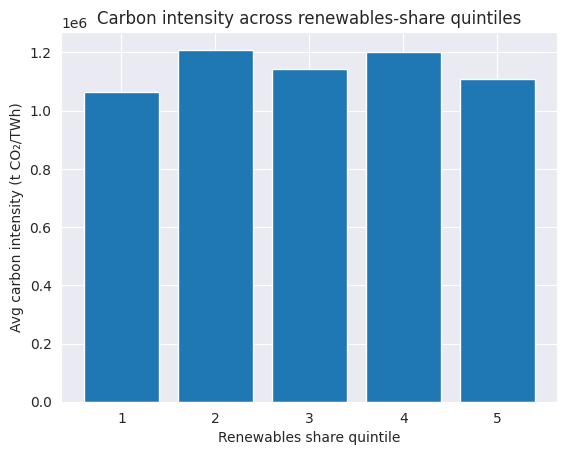

Threshold analysis around 30.0% renewables (Δ after minus before):


country  threshold  first_cross_year                         target  \
0   Australia       30.0              2000  carbon_intensity_tons_per_twh   
1   Australia       30.0              2000                      co2_mtons   
2      Brazil       30.0              2000  carbon_intensity_tons_per_twh   
3      Brazil       30.0              2000                      co2_mtons   
4      Canada       30.0              2000  carbon_intensity_tons_per_twh   
5      Canada       30.0              2000                      co2_mtons   
6       China       30.0              2000  carbon_intensity_tons_per_twh   
7       China       30.0              2000                      co2_mtons   
8     Germany       30.0              2000  carbon_intensity_tons_per_twh   
9     Germany       30.0              2000                      co2_mtons   
10      India       30.0              2000  carbon_intensity_tons_per_twh   
11      India       30.0              2000                      co2_mtons   
12      Japan       30.0              2000  carbon_intensity_tons_per_twh   
13      Japan       30.0              2000                      co2_mtons   
14     Russia       30.0              2000  carbon_intensity_tons_per_twh   
15     Russia       30.0              2000                      co2_mtons   
16         UK       30.0              2000  carbon_intensity_tons_per_twh   
17         UK       30.0              2000                      co2_mtons   
18        USA       30.0              2000  carbon_intensity_tons_per_twh   
19        USA       30.0              2000                      co2_mtons   

    before_mean    after_mean  delta_after_minus_before  
0           NaN  6.792403e+05                       NaN  
1           NaN  2.509965e+03                       NaN  
2           NaN  1.367064e+06                       NaN  
3           NaN  2.765770e+03                       NaN  
4           NaN  1.052532e+06                       NaN  
5           NaN  2.363011e+03                       NaN  
6           NaN  1.236994e+06                       NaN  
7           NaN  2.550697e+03                       NaN  
8           NaN  1.448514e+06                       NaN  
9           NaN  2.350243e+03                       NaN  
10          NaN  9.493911e+05                       NaN  
11          NaN  2.562945e+03                       NaN  
12          NaN  1.460512e+06                       NaN  
13          NaN  2.383990e+03                       NaN  
14          NaN  8.542312e+05                       NaN  
15          NaN  2.374013e+03                       NaN  
16          NaN  1.044556e+06                       NaN  
17          NaN  2.630959e+03                       NaN  
18          NaN  9.685340e+05                       NaN  
19          NaN  2.677770e+03                       NaN

Partial-correlation proxy: renew_share vs target | controls


target  pearson_partial_proxy  \
0  carbon_intensity_tons_per_twh              -0.005158   
1                      co2_mtons               0.001409   
2                      total_twh               0.001663   
3                 per_capita_kwh               0.000171   
4              price_usd_per_kwh              -0.015706   

   spearman_partial_proxy                  controls  
0               -0.007314  total_twh,per_capita_kwh  
1                0.001342  total_twh,per_capita_kwh  
2                0.001903  total_twh,per_capita_kwh  
3                0.000181  total_twh,per_capita_kwh  
4               -0.015652  total_twh,per_capita_kwh

In [15]:
# ============================================================
# Renewables Impact EDA Suite
# Goal: descriptive insight on how renewables relate to intensity, emissions, use & prices
# - Global correlations (Pearson + Spearman)
# - Within-country (fixed-effects style) correlations via demeaning
# - Lead–lag correlations: does renewables now relate to next year's intensity/emissions?
# - Quintile analysis: compare outcomes across renewables-share quintiles
# - Threshold analysis: what changes when countries cross 30% renewables?
# - Partial-correlation proxy: regress out scale (total_twh) & development (per_capita_kwh)
# Saves key tables to /content/energy_outputs/eda/
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

OUT = Path("/content/energy_outputs/eda")
OUT.mkdir(parents=True, exist_ok=True)

# ---------- 0) Preconditions / derive if needed ----------
need = {'country','year','renew_share_pct'}
if not need.issubset(df.columns):
    raise ValueError(f"Missing required columns: {need - set(df.columns)}")

# Carbon intensity if possible
if 'carbon_intensity_tons_per_twh' not in df.columns:
    if {'co2_mtons','total_twh'}.issubset(df.columns):
        df['carbon_intensity_tons_per_twh'] = (df['co2_mtons']*1e6) / df['total_twh'].replace(0, np.nan)

# Useful derived levels
if {'total_twh','renew_share_pct'}.issubset(df.columns) and 'renew_twh' not in df.columns:
    df['renew_twh'] = df['total_twh'] * df['renew_share_pct']/100.0
if {'total_twh','fossil_share_pct'}.issubset(df.columns) and 'fossil_twh' not in df.columns:
    df['fossil_twh'] = df['total_twh'] * df['fossil_share_pct']/100.0

# Keep a working copy with consistent types
w = df.copy()
w['year'] = pd.to_numeric(w['year'], errors='coerce')
w = w.dropna(subset=['country','year','renew_share_pct']).sort_values(['country','year'])

# Targets we’ll study against renewables share
targets = [c for c in ['carbon_intensity_tons_per_twh','co2_mtons','total_twh','per_capita_kwh','price_usd_per_kwh'] if c in w.columns]

# ---------- 1) GLOBAL correlations (level-on-level) ----------
def corr_2ways(x, y):
    xr, yr = x.dropna(), y.dropna()
    c = xr.index.intersection(yr.index)
    if len(c) < 5:
        return np.nan, np.nan
    x2, y2 = xr.loc[c], yr.loc[c]
    pear = np.corrcoef(x2, y2)[0,1]
    spear = pd.Series(x2).corr(pd.Series(y2), method='spearman')
    return float(pear), float(spear)

global_rows = []
for t in targets:
    p, s = corr_2ways(w['renew_share_pct'], w[t])
    global_rows.append({'target': t, 'pearson': p, 'spearman': s})
global_corr = pd.DataFrame(global_rows)
print("GLOBAL correlations: renew_share_pct vs targets (level-level)")
display(global_corr)

global_corr.to_csv(OUT / "renew_global_correlations.csv", index=False)

# ---------- 2) WITHIN-COUNTRY correlations (demeaned; FE-style descriptive) ----------
# Rationale: remove country-specific levels to focus on within-country comovement over time.
def demean_within_country(df_in, col):
    return df_in[col] - df_in.groupby('country')[col].transform('mean')

w_fe = w.copy()
w_fe['renew_fe'] = demean_within_country(w_fe, 'renew_share_pct')

fe_rows = []
for t in targets:
    if t not in w_fe:
        continue
    w_fe[f'{t}_fe'] = demean_within_country(w_fe, t)
    p, s = corr_2ways(w_fe['renew_fe'], w_fe[f'{t}_fe'])
    fe_rows.append({'target': t, 'pearson_within': p, 'spearman_within': s})
fe_corr = pd.DataFrame(fe_rows)
print("WITHIN-COUNTRY correlations (demeaned): Δrenew vs Δtarget")
display(fe_corr)

fe_corr.to_csv(OUT / "renew_within_country_correlations.csv", index=False)

# ---------- 3) LEAD–LAG: renewables now vs intensity/emissions next year ----------
lead_rows = []
w_lag = w.sort_values(['country','year']).copy()
for t in [x for x in ['carbon_intensity_tons_per_twh','co2_mtons'] if x in w_lag]:
    w_lag[f'{t}_lead1'] = w_lag.groupby('country')[t].shift(-1)  # t+1
    p, s = corr_2ways(w_lag['renew_share_pct'], w_lag[f'{t}_lead1'])
    lead_rows.append({'target_next_year': f'{t}(t+1)', 'pearson': p, 'spearman': s})
lead_corr = pd.DataFrame(lead_rows)
print("LEAD–LAG: renew_share_pct(t) vs targets(t+1)")
display(lead_corr)

lead_corr.to_csv(OUT / "renew_lead1_correlations.csv", index=False)

# ---------- 4) QUINTILE analysis: outcomes by renewables-share quintile ----------
if len(w) > 0:
    q = w.dropna(subset=['renew_share_pct']).copy()
    q['renew_quintile'] = pd.qcut(q['renew_share_pct'], q=5, labels=[1,2,3,4,5])
    means = q.groupby('renew_quintile')[targets].mean(numeric_only=True).reset_index()
    print("Mean outcomes by renewables-share quintile (1=lowest, 5=highest):")
    display(means)

    means.to_csv(OUT / "renew_quintile_means.csv", index=False)

    # Quick bar for carbon intensity, if present
    if 'carbon_intensity_tons_per_twh' in targets:
        plt.figure()
        means_ci = means[['renew_quintile','carbon_intensity_tons_per_twh']].dropna()
        plt.bar(means_ci['renew_quintile'].astype(str), means_ci['carbon_intensity_tons_per_twh'])
        plt.xlabel("Renewables share quintile")
        plt.ylabel("Avg carbon intensity (t CO₂/TWh)")
        plt.title("Carbon intensity across renewables-share quintiles")
        plt.show()

# ---------- 5) THRESHOLD analysis: change around 30% renewables ----------
# For each country, find the first year renew_share >= 30%. Compare avg outcome before (t-3..t-1) vs after (t+1..t+3).
thr_rows = []
THRESH = 30.0
for ctry, g in w.groupby('country'):
    g = g.dropna(subset=['renew_share_pct']).sort_values('year')
    hit = g[g['renew_share_pct'] >= THRESH]
    if hit.empty:
        continue
    t0 = int(hit['year'].iloc[0])  # first crossing
    win_before = g[(g['year'] >= t0-3) & (g['year'] <= t0-1)]
    win_after  = g[(g['year'] >= t0+1) & (g['year'] <= t0+3)]

    for t in [x for x in ['carbon_intensity_tons_per_twh','co2_mtons'] if x in g.columns]:
        before_mean = win_before[t].mean() if len(win_before) else np.nan
        after_mean = win_after[t].mean() if len(win_after) else np.nan
        delta = after_mean - before_mean if pd.notna(before_mean) and pd.notna(after_mean) else np.nan
        thr_rows.append({
            'country': ctry, 'threshold': THRESH, 'first_cross_year': t0,
            'target': t, 'before_mean': before_mean, 'after_mean': after_mean, 'delta_after_minus_before': delta
        })

thr_df = pd.DataFrame(thr_rows)
print(f"Threshold analysis around {THRESH}% renewables (Δ after minus before):")
display(thr_df.head(20))
thr_df.to_csv(OUT / "renew_threshold_30pct_changes.csv", index=False)

# Distribution plot for intensity deltas (if available)
if not thr_df.empty and 'carbon_intensity_tons_per_twh' in thr_df['target'].unique():
    d = thr_df[thr_df['target']=='carbon_intensity_tons_per_twh']['delta_after_minus_before'].dropna()
    if len(d) > 0:
        plt.figure()
        plt.hist(d, bins=20)
        plt.axvline(0, color='k', linestyle='--', linewidth=1)
        plt.title("Change in carbon intensity after crossing 30% renewables\n(positive=went up, negative=went down)")
        plt.xlabel("After minus before (t CO₂/TWh)"); plt.ylabel("Number of countries")
        plt.show()

# ---------- 6) Partial-correlation proxy (control for scale & development) ----------
# Idea: regress out 'total_twh' and 'per_capita_kwh' from both renew_share and target, then correlate residuals.
# This is a rough proxy for partial correlation without heavy deps.

def residualize(y, X_df):
    """Return residuals of y ~ X (OLS via numpy lstsq). Drops rows with NaNs."""
    data = pd.concat([y, X_df], axis=1).dropna()
    if data.shape[0] < X_df.shape[1] + 5:
        return pd.Series(dtype=float)  # not enough data
    yv = data.iloc[:,0].values.astype(float)
    X = data.iloc[:,1:].values.astype(float)
    # add intercept
    X = np.column_stack([np.ones(len(X)), X])
    beta, *_ = np.linalg.lstsq(X, yv, rcond=None)
    yhat = X @ beta
    resid = yv - yhat
    r = pd.Series(resid, index=data.index)
    return r

controls = [c for c in ['total_twh','per_capita_kwh'] if c in w.columns]
if controls:
    pc_rows = []
    for t in targets:
        if t not in w.columns:
            continue
        r_renew = residualize(w['renew_share_pct'], w[controls])  # renew | controls
        r_tgt   = residualize(w[t], w[controls])                  # target | controls
        # correlate residuals on common index
        idx = r_renew.index.intersection(r_tgt.index)
        if len(idx) >= 10:
            pear = np.corrcoef(r_renew.loc[idx], r_tgt.loc[idx])[0,1]
            spear = pd.Series(r_renew.loc[idx]).corr(pd.Series(r_tgt.loc[idx]), method='spearman')
        else:
            pear, spear = np.nan, np.nan
        pc_rows.append({'target': t, 'pearson_partial_proxy': pear, 'spearman_partial_proxy': spear, 'controls': ",".join(controls)})
    pcorr = pd.DataFrame(pc_rows)
    print("Partial-correlation proxy: renew_share vs target | controls")
    display(pcorr)
    pcorr.to_csv(OUT / "renew_partial_correlation_proxy.csv", index=False)
else:
    print("Partial-correlation proxy skipped (controls not available).")


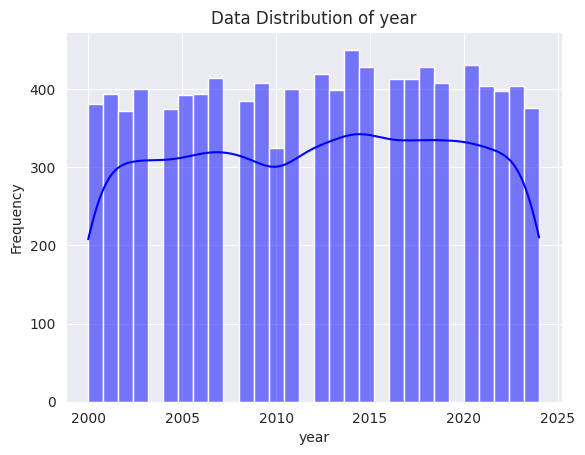

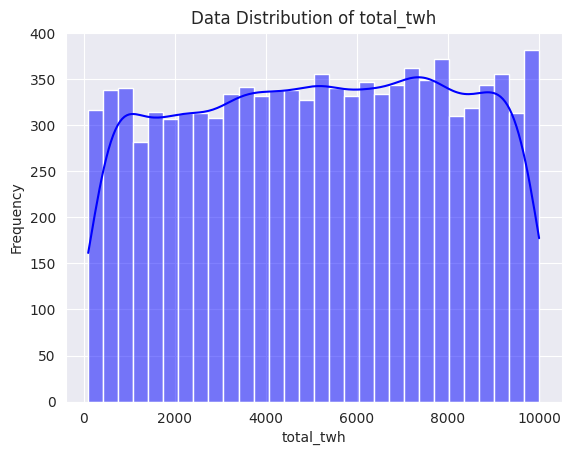

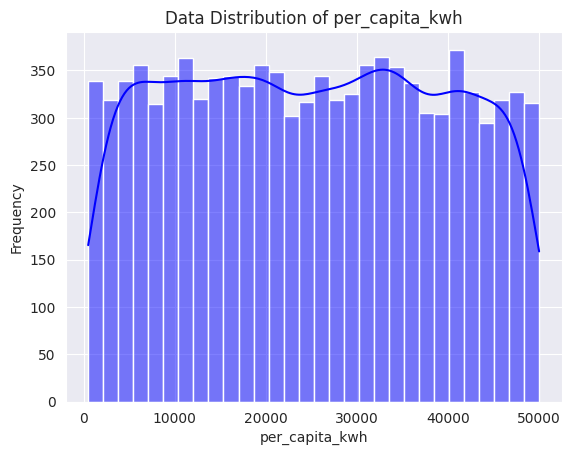

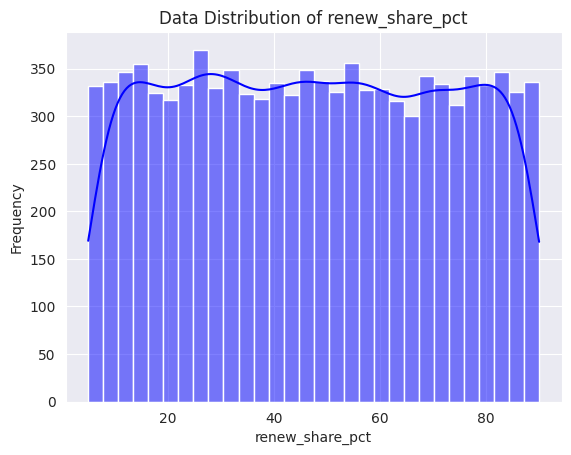

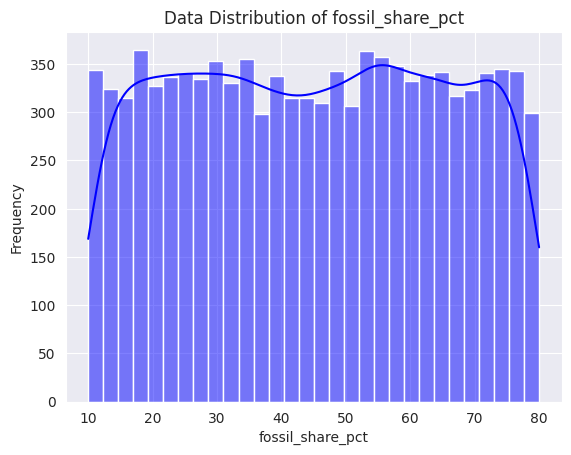

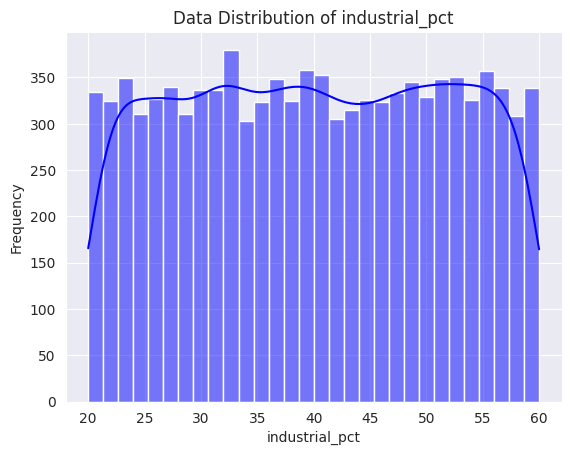

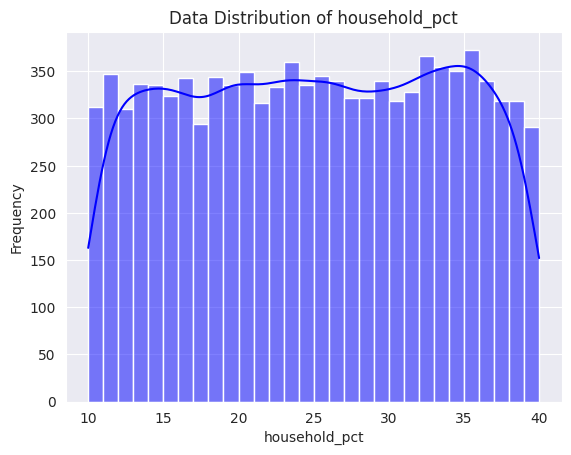

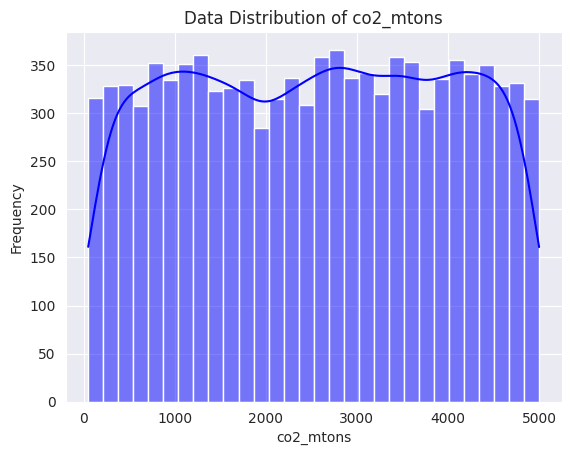

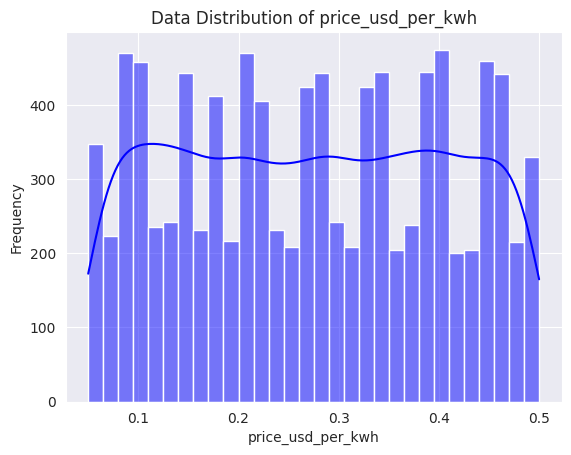

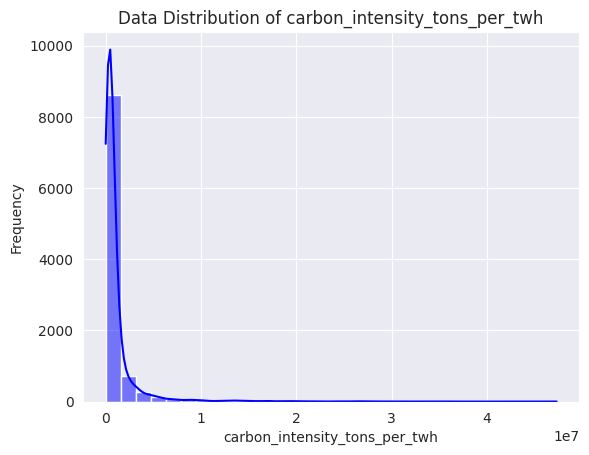

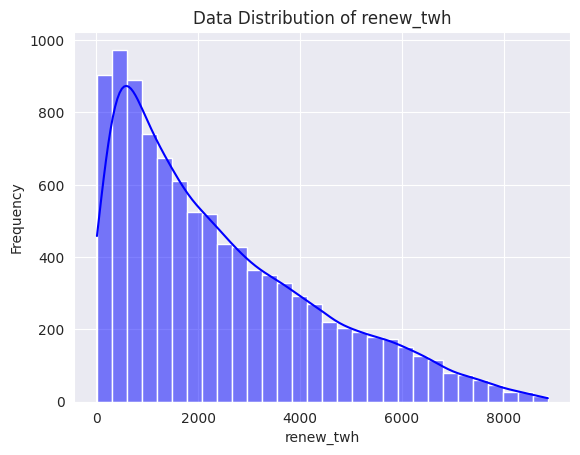

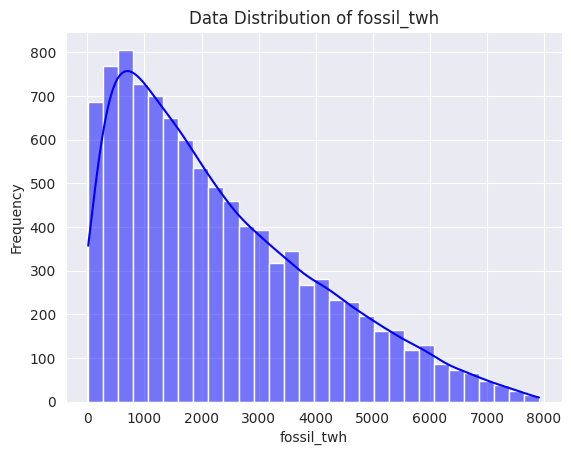

In [16]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f"Data Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

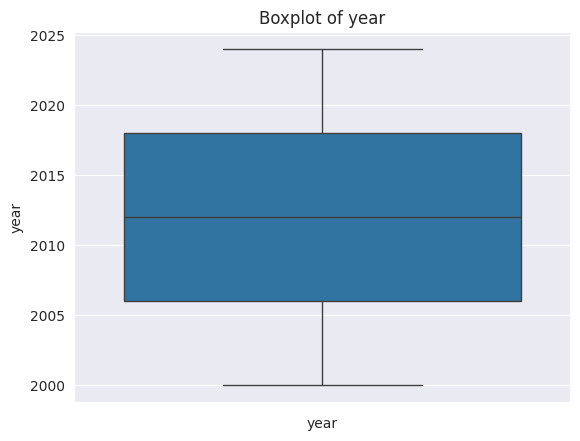

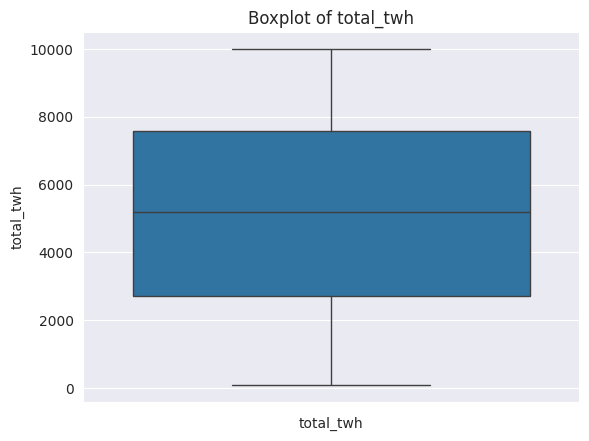

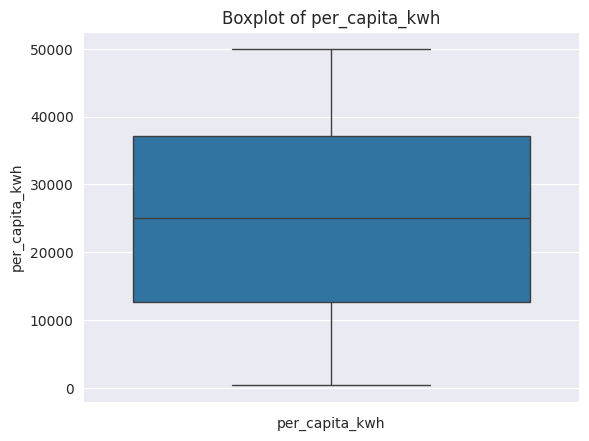

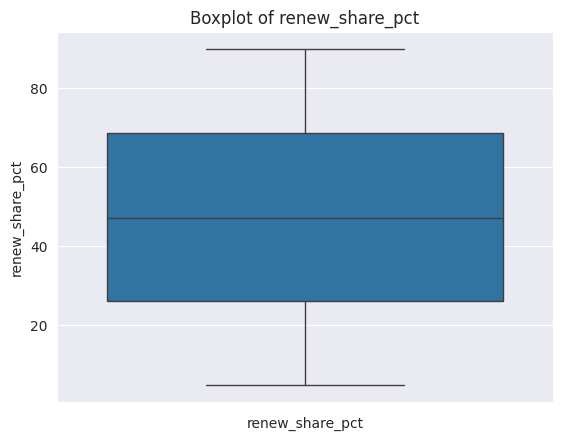

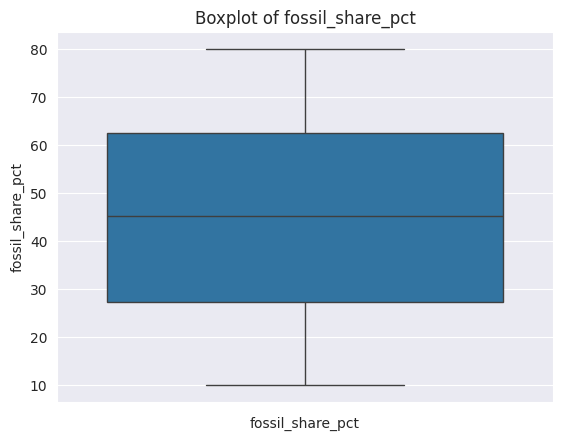

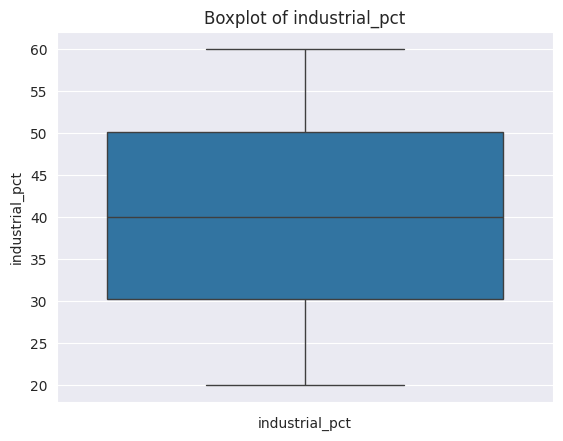

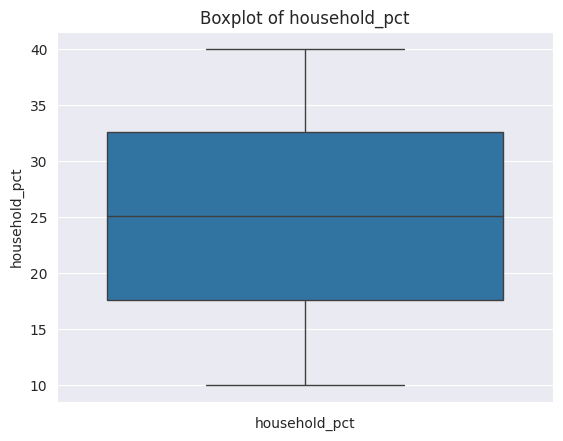

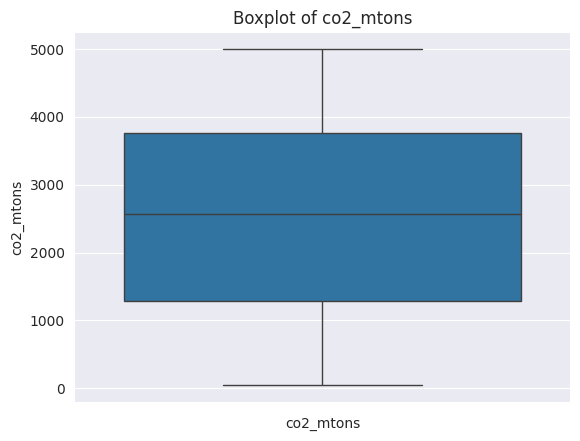

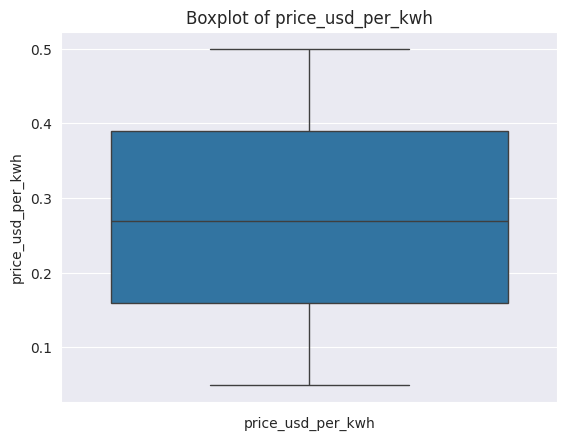

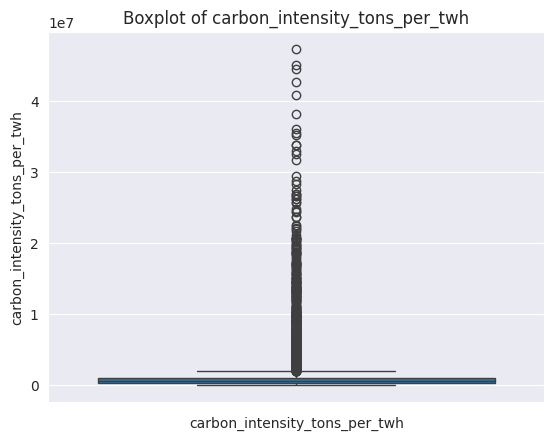

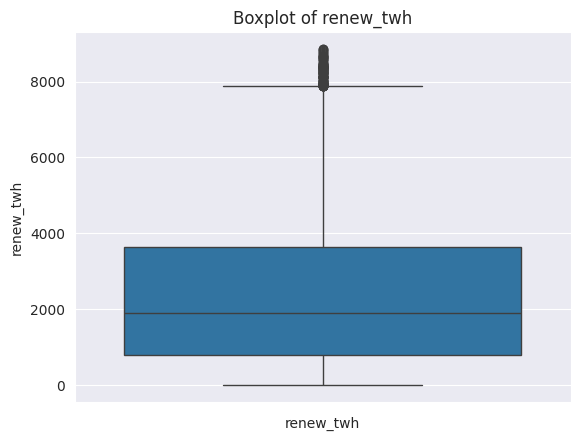

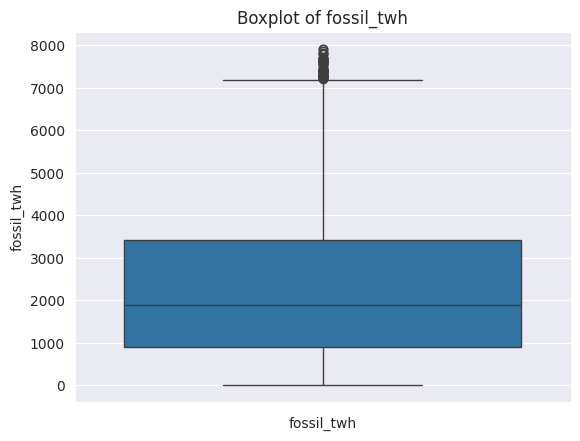

In [17]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    sns.boxplot(df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()


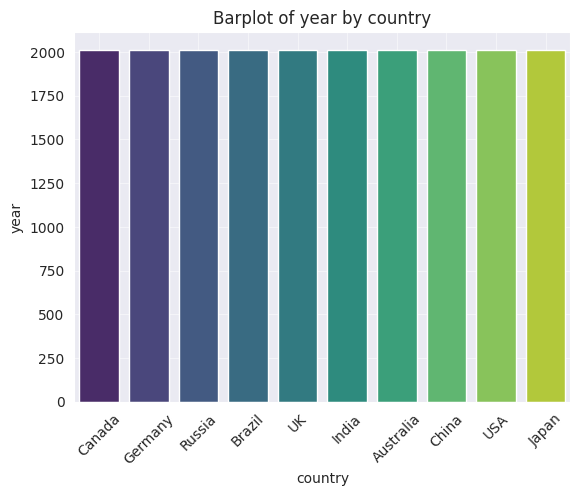

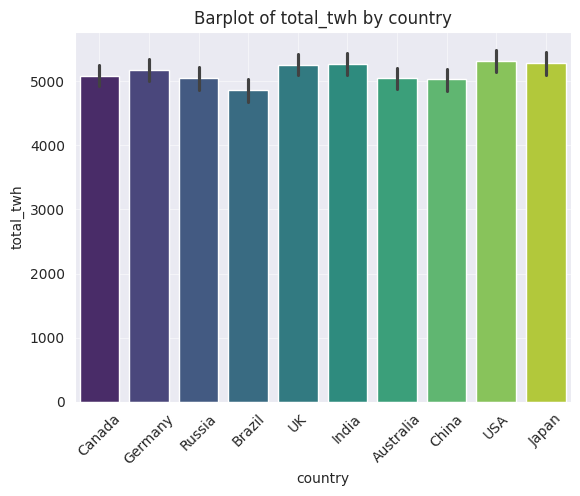

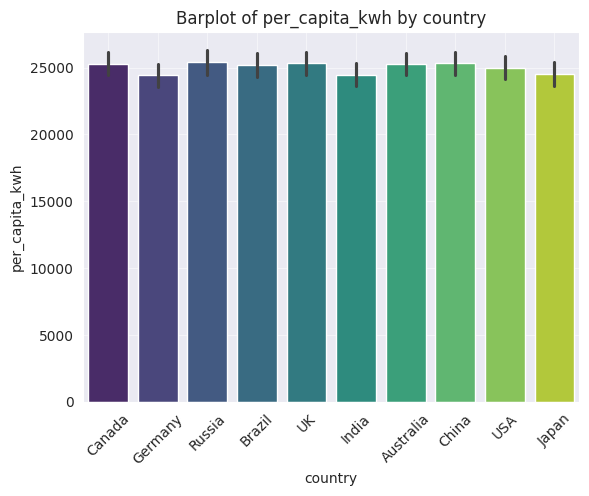

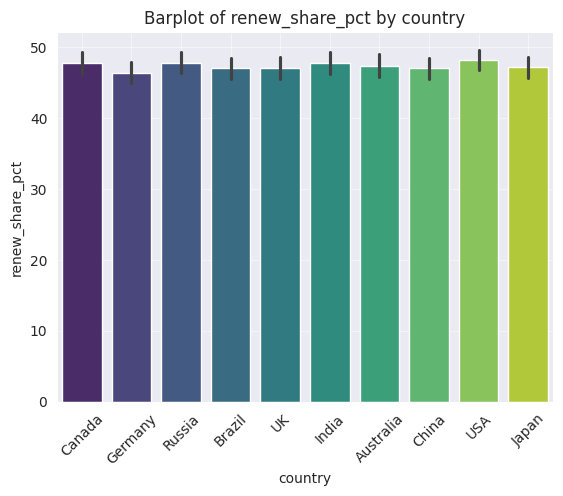

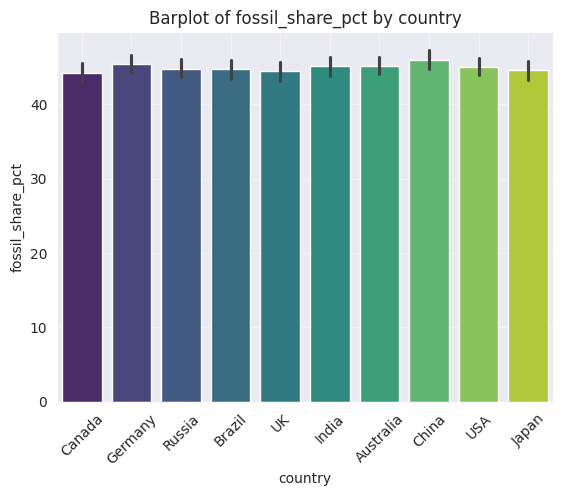

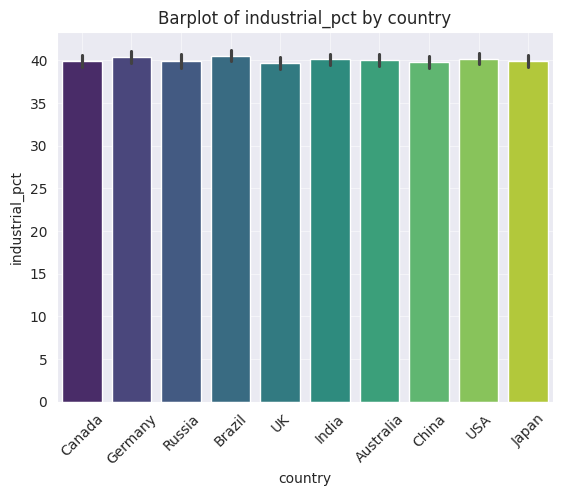

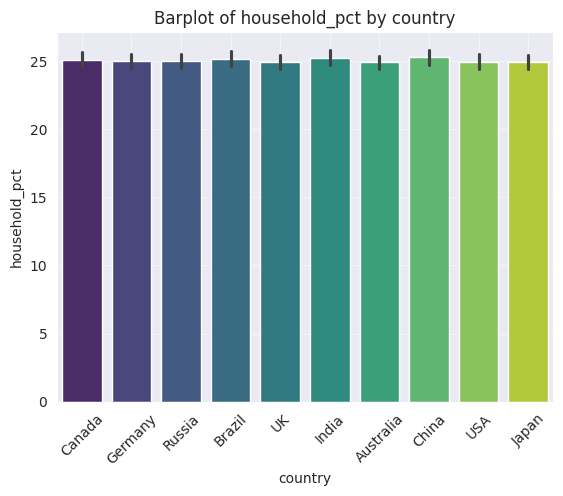

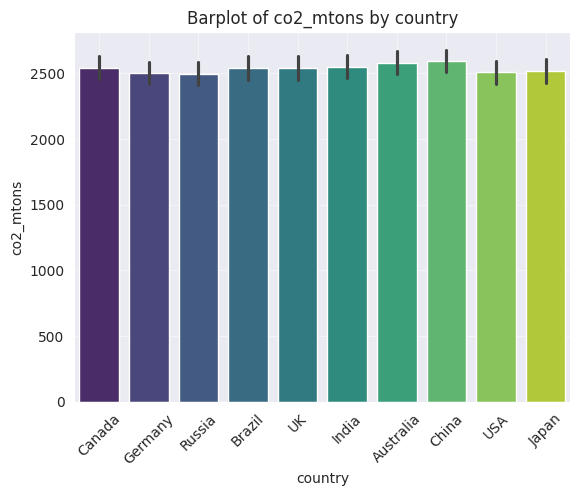

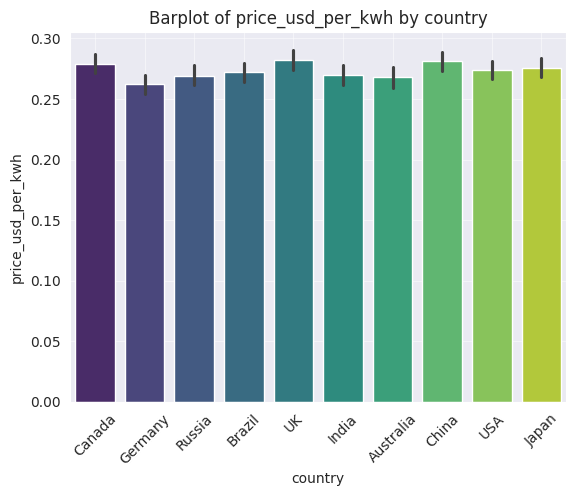

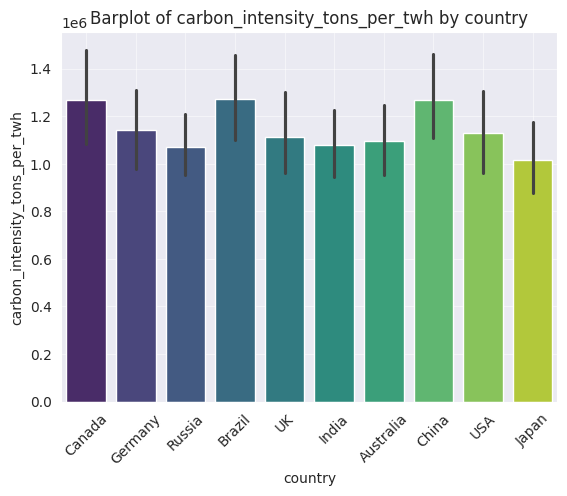

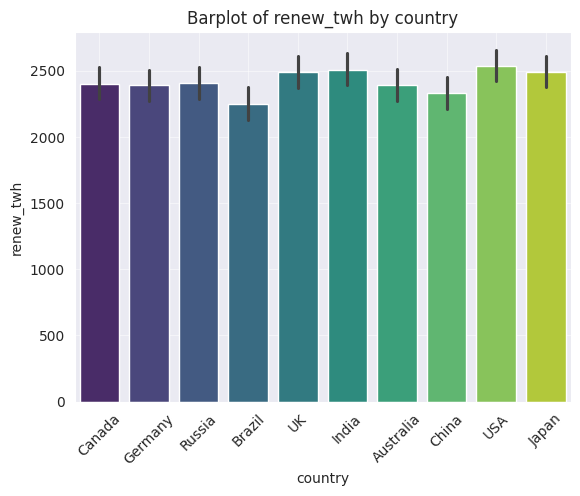

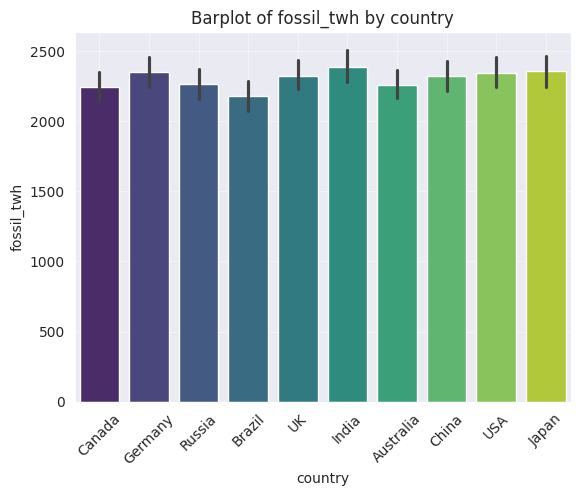

In [18]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    sns.barplot(x="country", y=col, data=df, palette='viridis')
    plt.title(f"Barplot of {col} by country")
    plt.xlabel("country")
    plt.xticks(rotation=45)
    plt.ylabel(col)
    plt.grid(alpha=0.5)
    plt.show()

In [19]:
# Statistical summary of the dataset
df.describe()

year     total_twh  per_capita_kwh  renew_share_pct  \
count  10000.000000  10000.000000    10000.000000     10000.000000   
mean    2012.151400   5142.564425    25039.950516        47.322925   
std        7.155236   2848.754040    14205.659284        24.603767   
min     2000.000000    100.480000      500.270000         5.000000   
25%     2006.000000   2713.882500    12683.220000        26.110000   
50%     2012.000000   5190.850000    25098.770000        47.150000   
75%     2018.000000   7579.977500    37113.282500        68.682500   
max     2024.000000   9999.260000    49989.570000        90.000000   

       fossil_share_pct  industrial_pct  household_pct     co2_mtons  \
count      10000.000000    10000.000000   10000.000000  10000.000000   
mean          44.932851       40.057585      25.043290   2536.148007   
std           20.202800       11.538756       8.597024   1424.105067   
min           10.010000       20.000000      10.000000     50.640000   
25%           27.337500       30.217500      17.610000   1293.330000   
50%           45.110000       39.980000      25.090000   2568.015000   
75%           62.430000       50.150000      32.570000   3766.182500   
max           80.000000       60.000000      40.000000   4999.340000   

       price_usd_per_kwh  carbon_intensity_tons_per_twh     renew_twh  \
count       10000.000000                   1.000000e+04  10000.000000   
mean            0.273466                   1.145368e+06   2419.159405   
std             0.130782                   2.680554e+06   1960.758599   
min             0.050000                   5.904008e+03      9.517547   
25%             0.160000                   2.532286e+05    802.719733   
50%             0.270000                   4.934807e+05   1896.023379   
75%             0.390000                   9.429938e+05   3630.767149   
max             0.500000                   4.731813e+07   8864.025008   

         fossil_twh  
count  10000.000000  
mean    2305.754712  
std     1736.449599  
min       13.865180  
25%      891.764640  
50%     1887.289070  
75%     3413.224662  
max     7914.316054

In [20]:
# Checking for missing values
missing_values = df.isnull().sum()
missing_values

country                          0
year                             0
total_twh                        0
per_capita_kwh                   0
renew_share_pct                  0
fossil_share_pct                 0
industrial_pct                   0
household_pct                    0
co2_mtons                        0
price_usd_per_kwh                0
carbon_intensity_tons_per_twh    0
renew_twh                        0
fossil_twh                       0
dtype: int64

In [21]:
# Checking data types
df.dtypes

country                           object
year                               int64
total_twh                        float64
per_capita_kwh                   float64
renew_share_pct                  float64
fossil_share_pct                 float64
industrial_pct                   float64
household_pct                    float64
co2_mtons                        float64
price_usd_per_kwh                float64
carbon_intensity_tons_per_twh    float64
renew_twh                        float64
fossil_twh                       float64
dtype: object

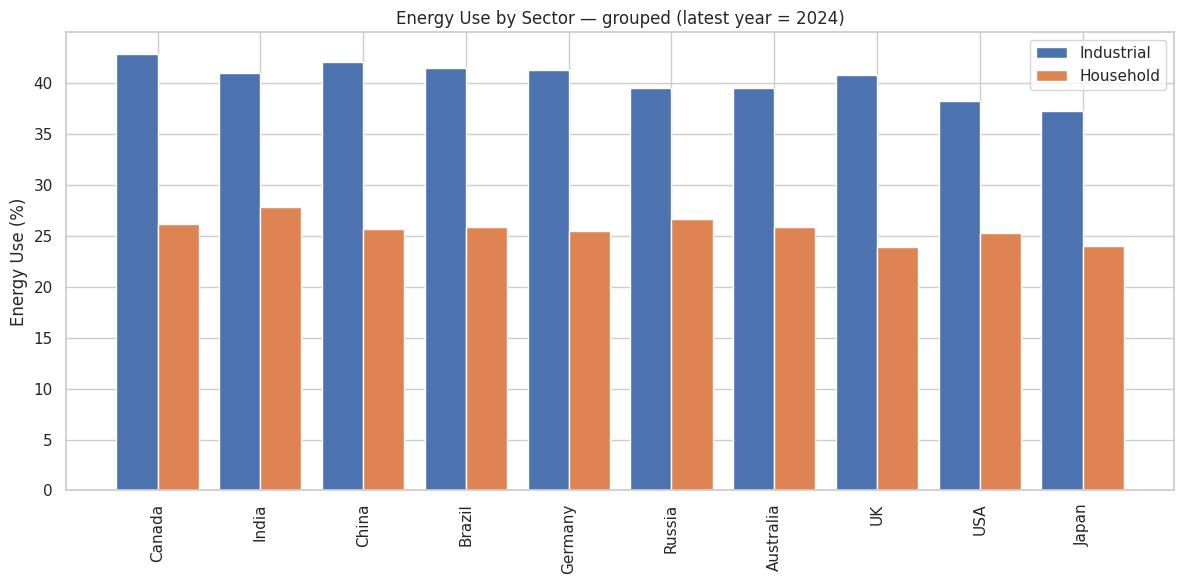

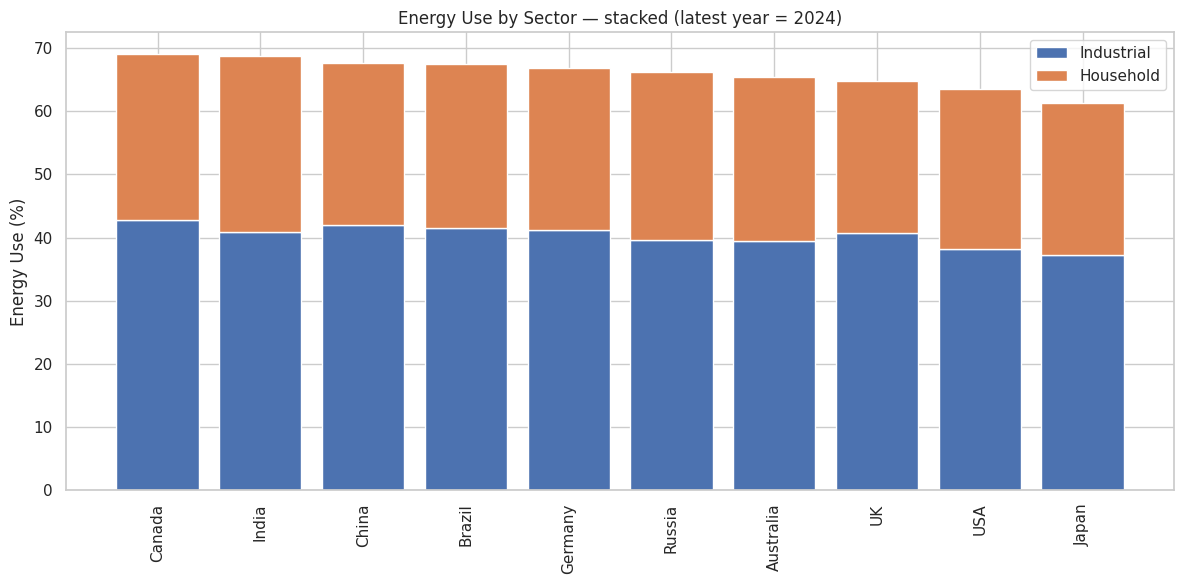

In [22]:
# ===== Sector mix by country: Industrial vs Household (robust) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 0) Pick the dataframe you’re actually using
D = None
if 'df' in globals() and isinstance(df, pd.DataFrame):
    D = df.copy()
elif 'data' in globals() and isinstance(data, pd.DataFrame):
    D = data.copy()
else:
    raise ValueError("Neither `df` nor `data` found. Make sure your DataFrame exists.")

# 1) Resolve column names
def pick_first(cols, options):
    for o in options:
        if o in cols: return o
    return None

country_col = pick_first(D.columns, ["country", "Country"])
year_col    = pick_first(D.columns, ["year", "Year"])
ind_col     = pick_first(D.columns, ["industrial_pct", "Industrial Energy Use (%)"])
house_col   = pick_first(D.columns, ["household_pct",  "Household Energy Use (%)"])

missing = [c for c in [country_col, ind_col, house_col] if c is None]
if missing:
    raise ValueError("Missing required columns. Check that your data has 'country/Country' and "
                     "'Industrial Energy Use (%)' / 'industrial_pct', 'Household Energy Use (%)' / 'household_pct'.")

# 2) Coerce to numeric
for c in [ind_col, house_col]:
    D[c] = pd.to_numeric(D[c], errors='coerce')

# 3) Choose snapshot (latest year) or average across years
USE_LATEST_YEAR = True  # set False to use mean across all years
TOP_N = 20              # limit countries for readability; set None to show all

if USE_LATEST_YEAR and year_col is not None:
    D[year_col] = pd.to_numeric(D[year_col], errors='coerce')
    latest_year = int(D[year_col].max())
    df_plot = (D[D[year_col] == latest_year]
               .groupby(country_col, as_index=True)[[ind_col, house_col]]
               .mean(numeric_only=True))
    subtitle = f"(latest year = {latest_year})"
else:
    df_plot = (D.groupby(country_col, as_index=True)[[ind_col, house_col]]
                 .mean(numeric_only=True))
    subtitle = "(mean across years)"

# 4) Optional: keep only top-N by total % (industrial + household)
df_plot["__total__"] = df_plot[ind_col].fillna(0) + df_plot[house_col].fillna(0)
df_plot = df_plot.sort_values("__total__", ascending=False)
if TOP_N:
    df_plot = df_plot.head(TOP_N)
df_plot = df_plot.drop(columns="__total__")

# 5A) Grouped bars (side-by-side)
plt.figure(figsize=(max(12, len(df_plot)*0.6), 6))
x = np.arange(len(df_plot))
width = 0.4

plt.bar(x - width/2, df_plot[ind_col].values, width, label='Industrial')
plt.bar(x + width/2, df_plot[house_col].values, width, label='Household')

plt.ylabel('Energy Use (%)')
plt.title(f'Energy Use by Sector — grouped {subtitle}')
plt.xticks(x, df_plot.index.tolist(), rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# 5B) Stacked bars (alternative view)
plt.figure(figsize=(max(12, len(df_plot)*0.6), 6))
plt.bar(df_plot.index, df_plot[ind_col].values, label='Industrial')
plt.bar(df_plot.index, df_plot[house_col].values, bottom=df_plot[ind_col].fillna(0).values, label='Household')

plt.ylabel('Energy Use (%)')
plt.title(f'Energy Use by Sector — stacked {subtitle}')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


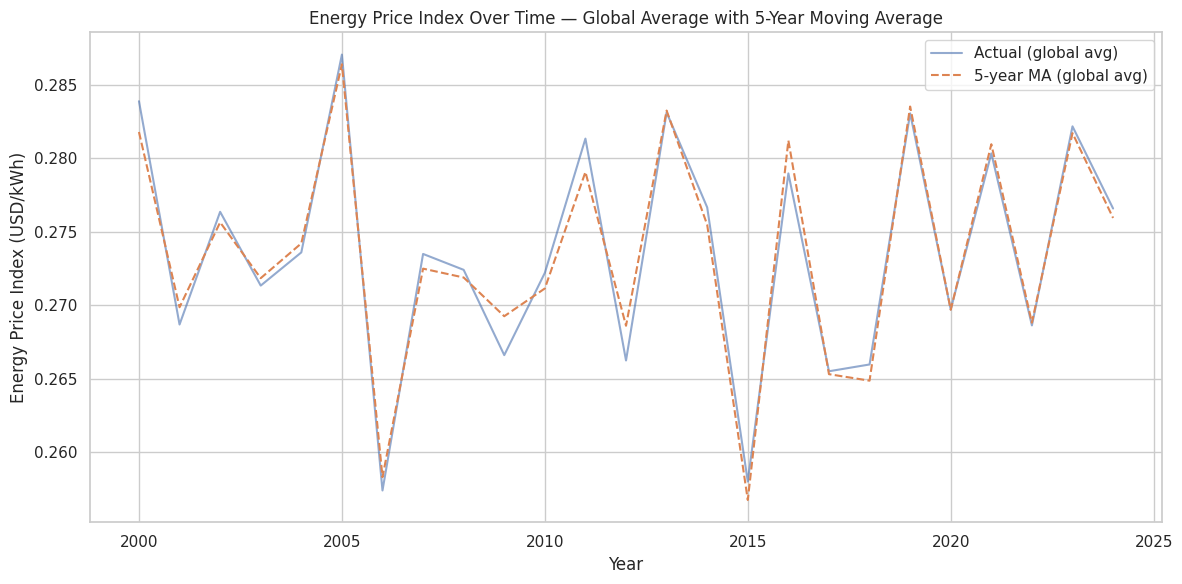

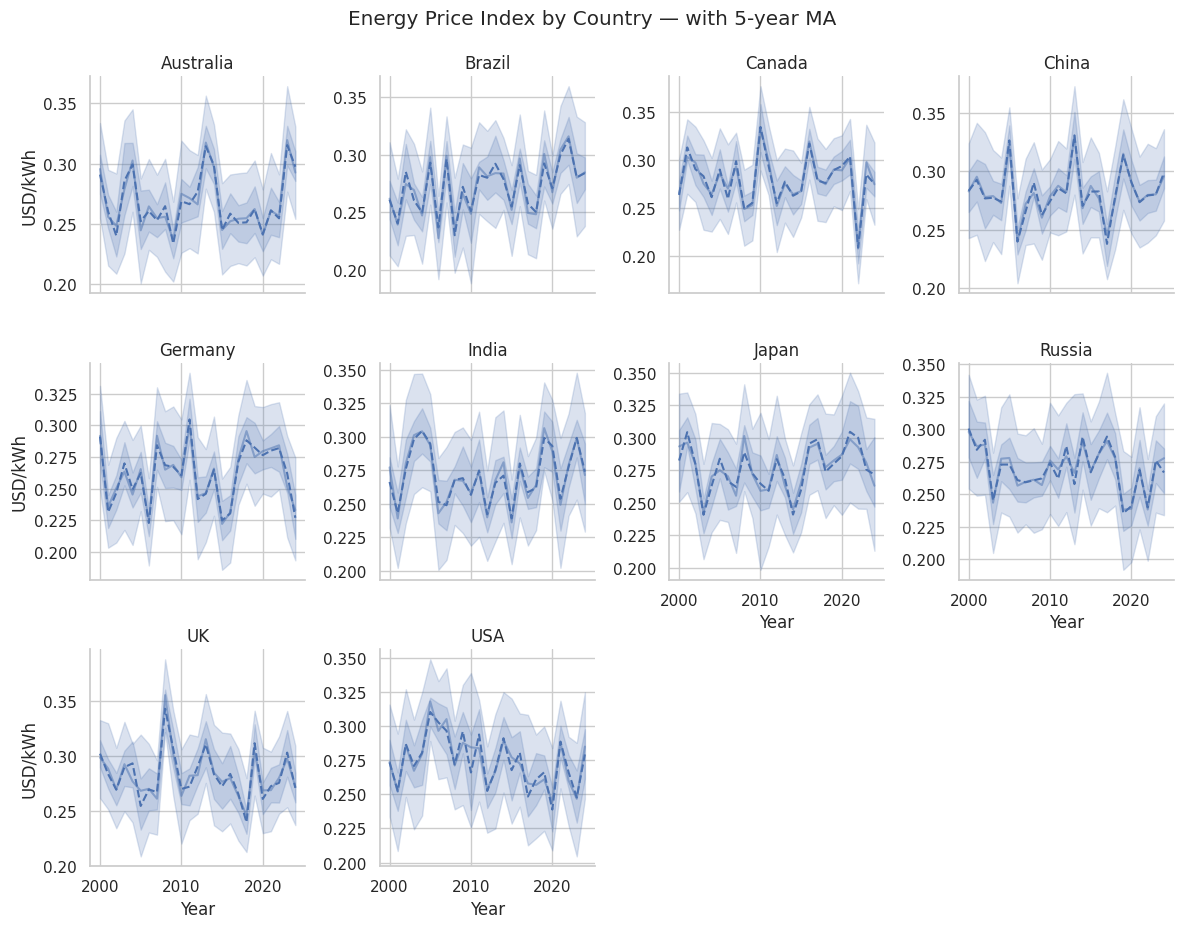

In [23]:
# ===== Energy Price Index with 5-year Moving Average (fixed & robust) =====
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# 0) Choose the working frame
D = df.copy()  # or data.copy()

# 1) Resolve columns (handles original or snake_case)
def pick(cols, options):
    for o in options:
        if o in cols: return o
    return None

year_col    = pick(D.columns, ["Year", "year"])
price_col   = pick(D.columns, ["Energy Price Index (USD/kWh)", "price_usd_per_kwh"])
country_col = pick(D.columns, ["Country", "country"])

if price_col is None or year_col is None:
    raise ValueError("Need Year/year and Energy Price Index (USD/kWh)/price_usd_per_kwh columns.")

# 2) Coerce types and sort
D[year_col]  = pd.to_numeric(D[year_col], errors="coerce")
D[price_col] = pd.to_numeric(D[price_col], errors="coerce")
if country_col:
    D = D.dropna(subset=[year_col, price_col, country_col]).sort_values([country_col, year_col])
else:
    D = D.dropna(subset=[year_col, price_col]).sort_values([year_col])

# 3) Compute 5-year rolling mean (vectorized, no .apply)
if country_col:
    D["MA_rolling"] = D.groupby(country_col, group_keys=False)[price_col]\
                       .transform(lambda s: s.rolling(window=5, min_periods=1).mean())
else:
    D["MA_rolling"] = D[price_col].rolling(window=5, min_periods=1).mean()

# 4) GLOBAL average over time with 5Y MA (use list for column subset)
if country_col:
    global_view = (D.groupby(year_col, as_index=False)[[price_col, "MA_rolling"]]
                     .mean(numeric_only=True))
else:
    global_view = D[[year_col, price_col, "MA_rolling"]].copy()

plt.figure(figsize=(12, 6))
sns.lineplot(data=global_view, x=year_col, y=price_col, label="Actual (global avg)", alpha=0.6)
sns.lineplot(data=global_view, x=year_col, y="MA_rolling", label="5-year MA (global avg)", linestyle="--")
plt.title("Energy Price Index Over Time — Global Average with 5-Year Moving Average")
plt.xlabel("Year"); plt.ylabel("Energy Price Index (USD/kWh)")
plt.legend(); plt.tight_layout(); plt.show()

# 5) (Optional) Facet: top countries by latest price
DO_FACET = True
TOP_N = 12

if DO_FACET and country_col:
    latest_year = int(D[year_col].max())
    top_ctys = (D[D[year_col] == latest_year]
                .groupby(country_col)[price_col]
                .mean()
                .sort_values(ascending=False)
                .head(TOP_N).index.tolist())
    F = D[D[country_col].isin(top_ctys)].copy()

    g = sns.FacetGrid(F, col=country_col, col_wrap=4, height=3.0, sharex=True, sharey=False)
    g.map_dataframe(sns.lineplot, x=year_col, y=price_col, alpha=0.5)
    g.map_dataframe(sns.lineplot, x=year_col, y="MA_rolling", linestyle="--")
    g.set_titles("{col_name}")
    g.set_xlabels("Year"); g.set_ylabels("USD/kWh")
    g.fig.suptitle("Energy Price Index by Country — with 5-year MA", y=1.03)
    plt.show()


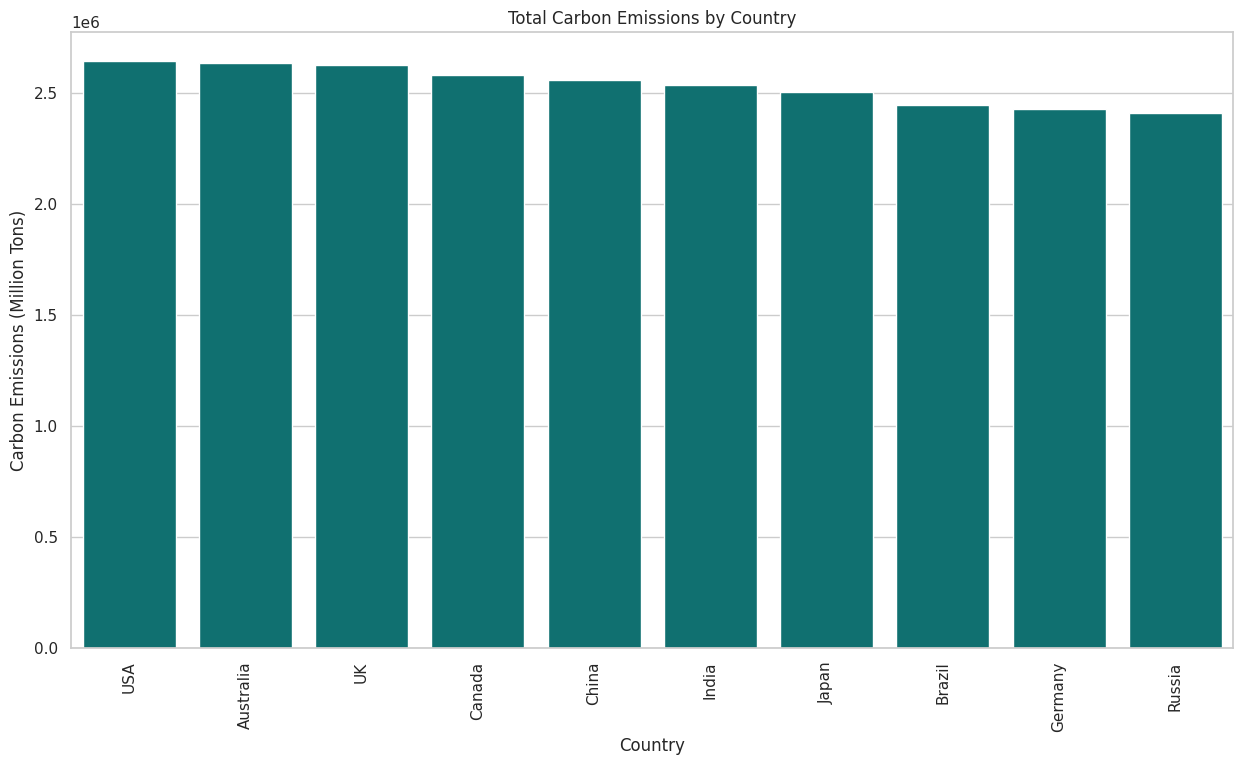

In [24]:
# ===== Carbon emissions by country (robust) =====
import seaborn as sns
import matplotlib.pyplot as plt

# Pick the actual column names
country_col = "Country" if "Country" in df.columns else "country"
co2_col = "Carbon Emissions (Million Tons)" if "Carbon Emissions (Million Tons)" in df.columns else "co2_mtons"

# Group and sort
TCE_Country = df.groupby(country_col)[co2_col].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(15,8))
sns.barplot(x=TCE_Country.index, y=TCE_Country.values, color="teal")
plt.title('Total Carbon Emissions by Country')
plt.xlabel("Country")
plt.ylabel("Carbon Emissions (Million Tons)")
plt.xticks(rotation=90)
plt.show()


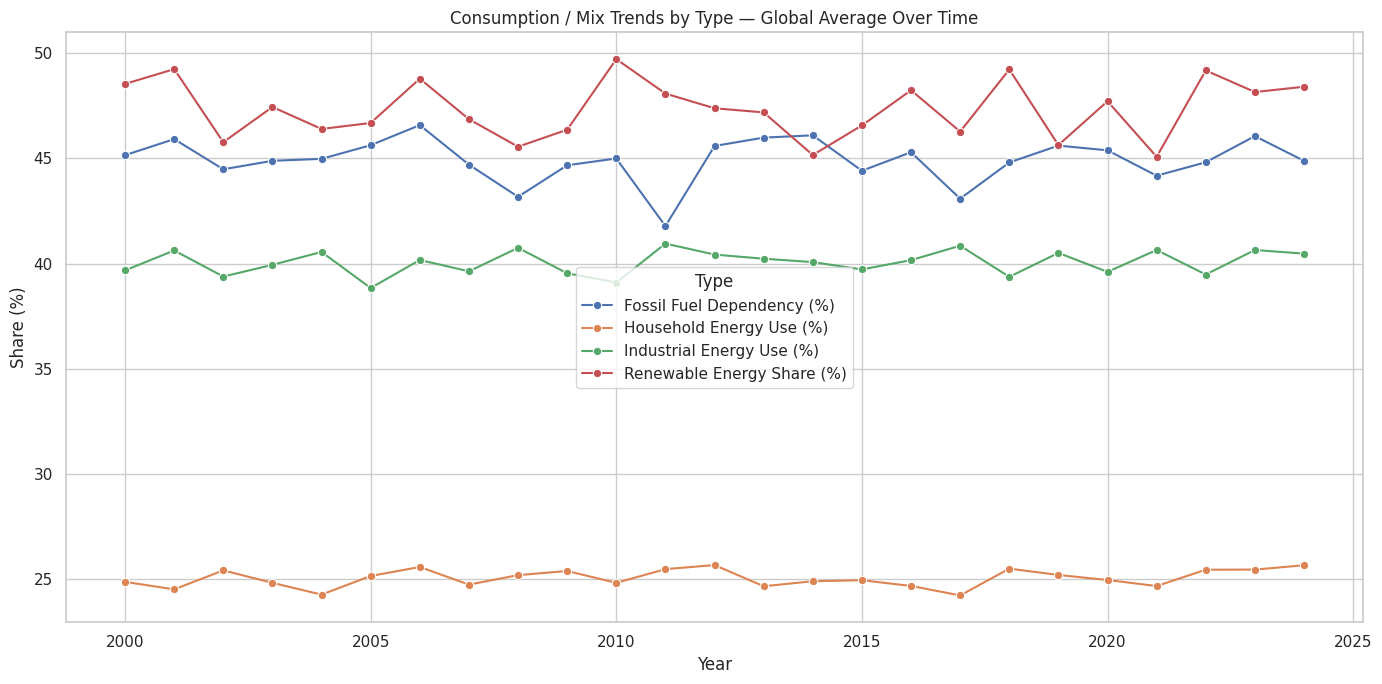

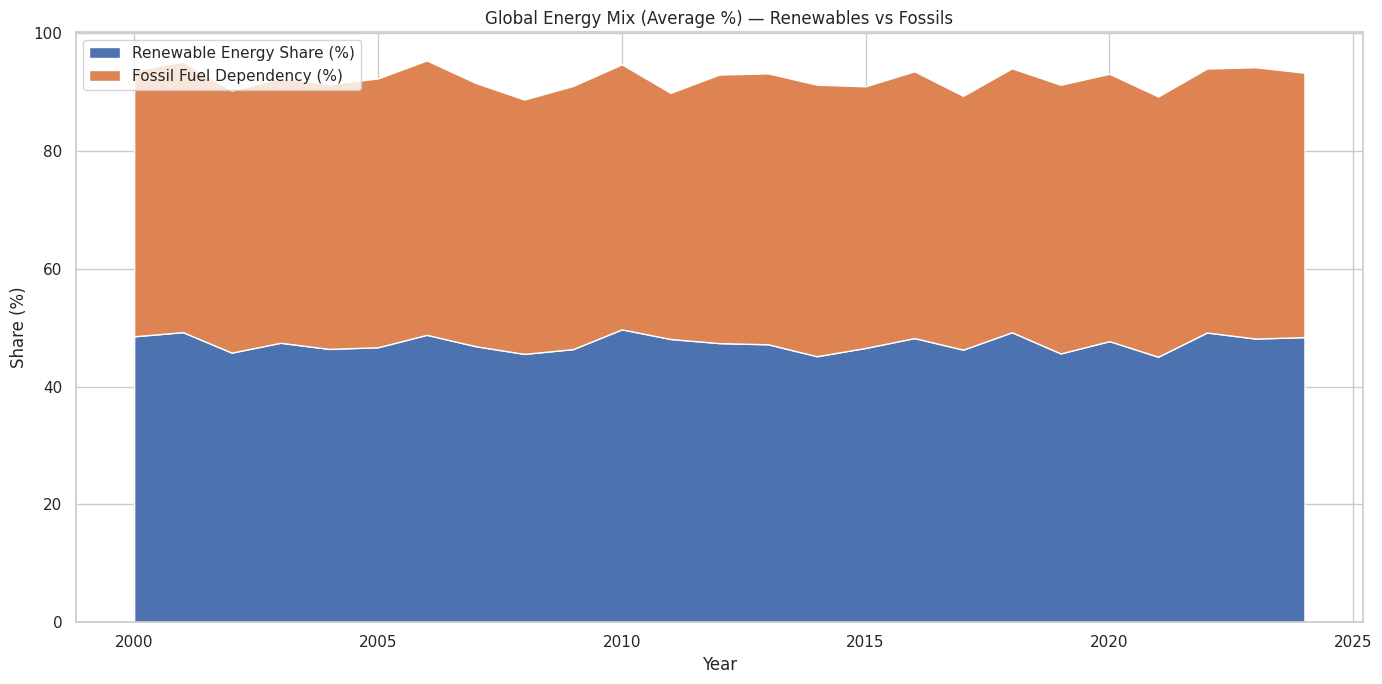

In [25]:
# ===== Robust melt for sector/mix trends =====
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

D = df.copy()  # or data.copy()

# 1) Resolve column names (Year/Country variants)
def pick(cols, options):
    for o in options:
        if o in cols: return o
    return None

year_col    = pick(D.columns, ["Year", "year"])
country_col = pick(D.columns, ["Country", "country"])

if year_col is None:
    raise KeyError("No 'Year' or 'year' column found in df.")
if country_col is None:
    # not strictly required for global averages, but useful for faceting
    print("Warning: no Country/country column; will compute global averages only.")

# 2) Candidate “use/mix” columns (original & snake_case variants)
candidates = {
    "Industrial Energy Use (%)": ["Industrial Energy Use (%)", "industrial_pct"],
    "Household Energy Use (%)":  ["Household Energy Use (%)",  "household_pct"],
    "Renewable Energy Share (%)":["Renewable Energy Share (%)","renew_share_pct"],
    "Fossil Fuel Dependency (%)":["Fossil Fuel Dependency (%)","fossil_share_pct"],
}

# Pick what actually exists in your frame
use_cols = {}
for canonical, opts in candidates.items():
    col = pick(D.columns, opts)
    if col is not None:
        use_cols[canonical] = col

if not use_cols:
    raise KeyError("None of the expected sector/mix columns were found in df.")

# 3) Keep only the columns we need and make numeric
keep_cols = [year_col] + ([country_col] if country_col else []) + list(use_cols.values())
W = D[keep_cols].copy()

for col in use_cols.values():
    W[col] = pd.to_numeric(W[col], errors="coerce")

W = W.dropna(subset=[year_col]).sort_values(year_col)

# 4) Melt into long format with clean labels
melt_map = {v:k for k,v in use_cols.items()}  # reverse: actual_name -> pretty label
W_long = W.melt(
    id_vars=[year_col] + ([country_col] if country_col else []),
    value_vars=list(use_cols.values()),
    var_name="Energy_type_raw",
    value_name="Value_pct"
)
W_long["Energy_type"] = W_long["Energy_type_raw"].map(melt_map)

# 5) Aggregate to global averages per year for smooth lines
global_trend = (W_long
                .groupby([year_col, "Energy_type"], as_index=False)["Value_pct"]
                .mean(numeric_only=True))

# 6) Line plot: global trends by use/mix type
plt.figure(figsize=(14,7))
sns.lineplot(data=global_trend, x=year_col, y="Value_pct", hue="Energy_type", marker="o")
plt.title("Consumption / Mix Trends by Type — Global Average Over Time")
plt.xlabel("Year")
plt.ylabel("Share (%)")
plt.legend(title="Type")
plt.tight_layout()
plt.show()

# 7) (Optional) Stacked area of the mix only (ren/fossil) if both exist
if {"Renewable Energy Share (%)","Fossil Fuel Dependency (%)"}.issubset(set(global_trend["Energy_type"].unique())):
    mix = global_trend.pivot(index=year_col, columns="Energy_type", values="Value_pct").fillna(0.0)
    mix = mix[["Renewable Energy Share (%)","Fossil Fuel Dependency (%)"]]
    plt.figure(figsize=(14,7))
    plt.stackplot(mix.index, mix.iloc[:,0], mix.iloc[:,1], labels=mix.columns)
    plt.title("Global Energy Mix (Average %) — Renewables vs Fossils")
    plt.xlabel("Year"); plt.ylabel("Share (%)")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

# 8) (Optional) Per-country facet (top N by latest total % available)
DO_FACET = False  # set True to enable small multiples
TOP_N = 12
if DO_FACET and country_col:
    # pick top countries by the total available “Value_pct” in the latest year (proxy for data density)
    latest_year = int(W[year_col].max())
    avail = (W_long[W_long[year_col]==latest_year]
             .groupby(country_col)["Value_pct"]
             .count().sort_values(ascending=False).head(TOP_N).index)
    facet = W_long[W_long[country_col].isin(avail)]
    g = sns.FacetGrid(facet, col=country_col, col_wrap=4, height=3.2, sharey=True)
    g.map_dataframe(sns.lineplot, x=year_col, y="Value_pct", hue="Energy_type", marker="o", legend=False)
    g.set_titles("{col_name}")
    g.set_xlabels("Year"); g.set_ylabels("Share (%)")
    g.fig.suptitle("Sector/Mix Trends by Country", y=1.02)
    # Add a separate legend
    handles, labels = g.axes.flat[0].get_legend_handles_labels()
    g.fig.legend(handles, labels, loc="upper right")
    plt.show()


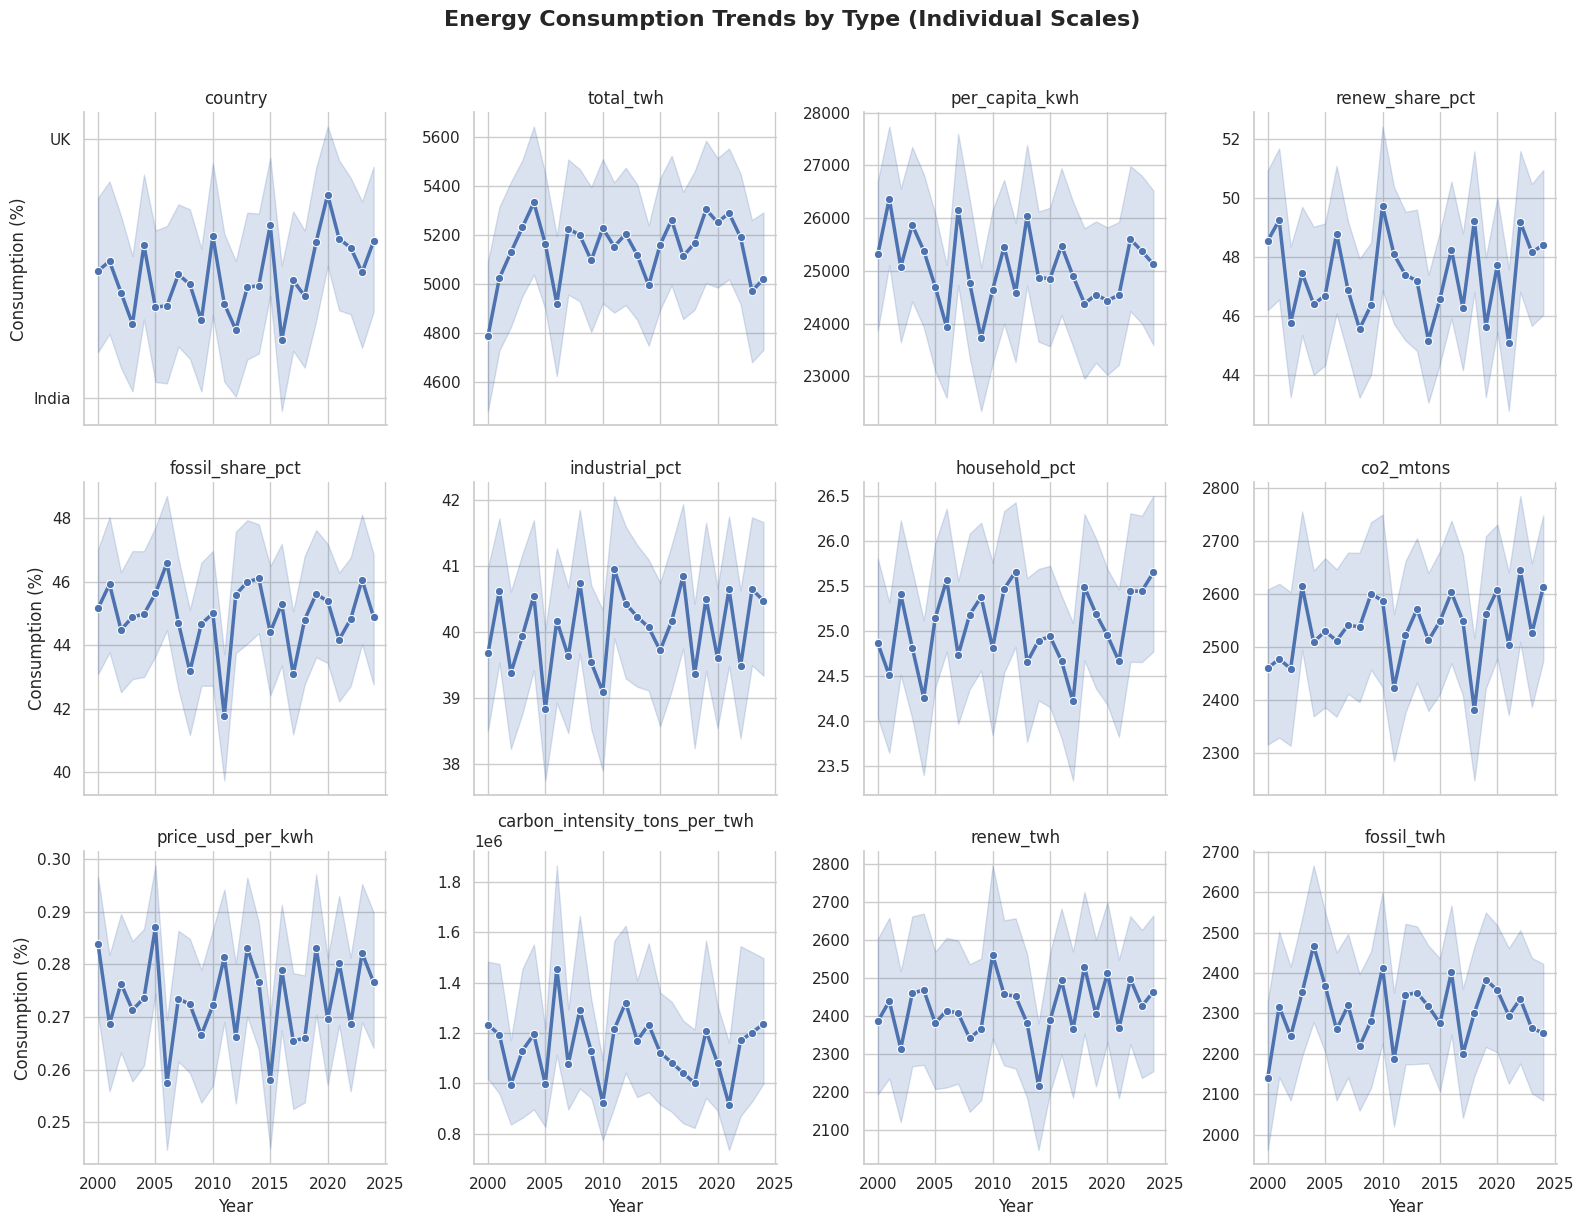

In [26]:
# ===== Faceted Subplots - Eliminates Scale Issues =====
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
D = df.copy()

# 1) Identify columns
def pick(cols, options):
    for o in options:
        if o in cols: return o
    return None

year_col = pick(D.columns, ["Year", "year"])
if year_col is None:
    print("Available columns:", D.columns.tolist())
    raise ValueError("No year column found.")

# 2) Define excluded columns
exclude_columns = [
    year_col,
    'Total Energy Consumption (TWh)',
    'Per Capita Energy Use (kWh)',
    'Carbon Emissions (Million Tons)',
    'Energy Price Index (USD/kWh)',
    'Renewable Energy Share (%)',
    'Fossil Fuel Dependency (%)'
]
exclude_columns = [col for col in exclude_columns if col in D.columns]

# 3) Get energy columns and melt data
energy_columns = [col for col in D.columns if col not in exclude_columns]
df_melted = D.melt(id_vars=[year_col], value_vars=energy_columns,
                   var_name='Energy_type', value_name='Consumption')

# 4) Create faceted subplots - each energy type gets its own scale
g = sns.FacetGrid(df_melted, col='Energy_type', col_wrap=4,
                  height=4, sharey=False, sharex=True)
g.map(sns.lineplot, year_col, 'Consumption', marker='o', linewidth=2.5)
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Consumption (%)")
g.fig.suptitle('Energy Consumption Trends by Type (Individual Scales)',
               y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

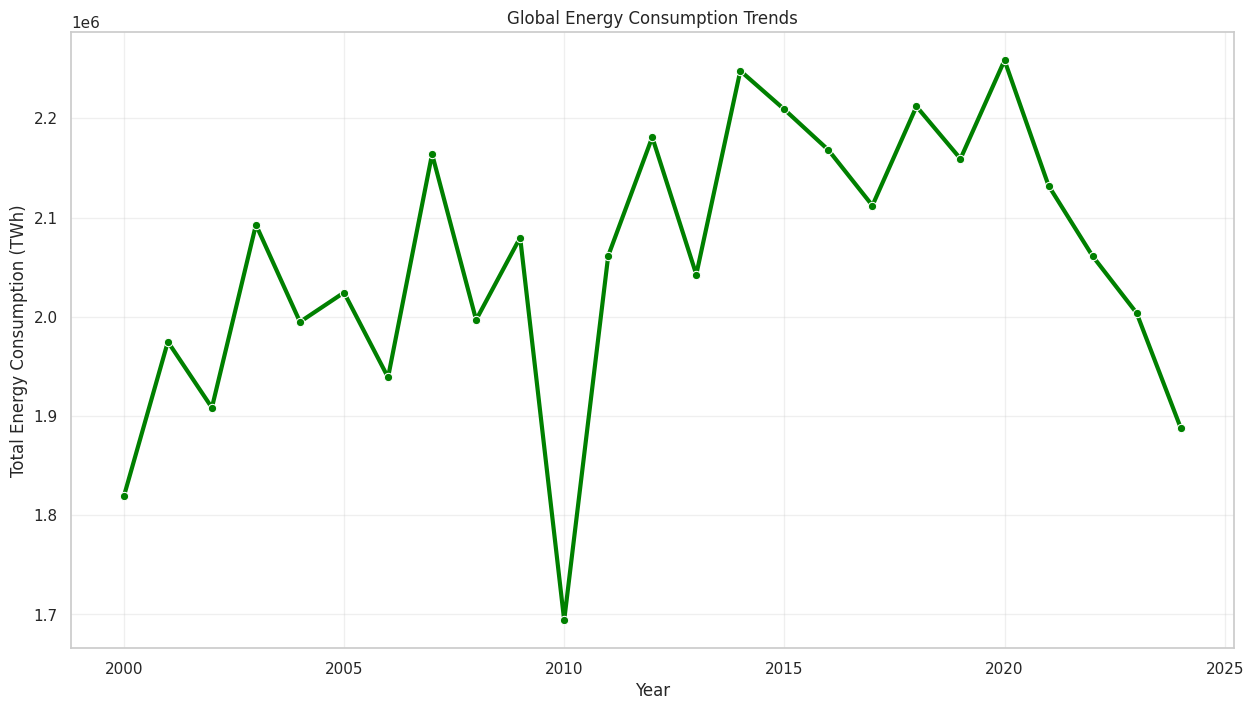

In [27]:
# ===== Global energy consumption trend (fixed) =====
import seaborn as sns
import matplotlib.pyplot as plt

# Detect correct column names
year_col = "Year" if "Year" in df.columns else "year"
total_col = "Total Energy Consumption (TWh)" if "Total Energy Consumption (TWh)" in df.columns else "total_twh"

# Group and sum across countries
TEC_Years = df.groupby(year_col, as_index=False)[total_col].sum()

# Plot
plt.figure(figsize=(15,8))
sns.lineplot(data=TEC_Years, x=year_col, y=total_col,
             color='green', linewidth=3, marker='o')
plt.title("Global Energy Consumption Trends")
plt.xlabel("Year")
plt.ylabel("Total Energy Consumption (TWh)")
plt.grid(alpha=0.3)
plt.show()


Global totals & coverage by year (first/last 10 rows):


year   total_TWh  n_countries  yoy_total  yoy_abs_TWh
0   2000  1818935.94           10        NaN          NaN
1   2001  1974854.60           10   0.085720    155918.66
2   2002  1908410.61           10  -0.033645    -66443.99
3   2003  2092794.51           10   0.096616    184383.90
4   2004  1994830.95           10  -0.046810    -97963.56
20  2020  2258586.61           10   0.045995     99315.51
21  2021  2132177.72           10  -0.055968   -126408.89
22  2022  2061189.12           10  -0.033294    -70988.60
23  2023  2003787.37           10  -0.027849    -57401.75
24  2024  1888162.22           10  -0.057703   -115625.15

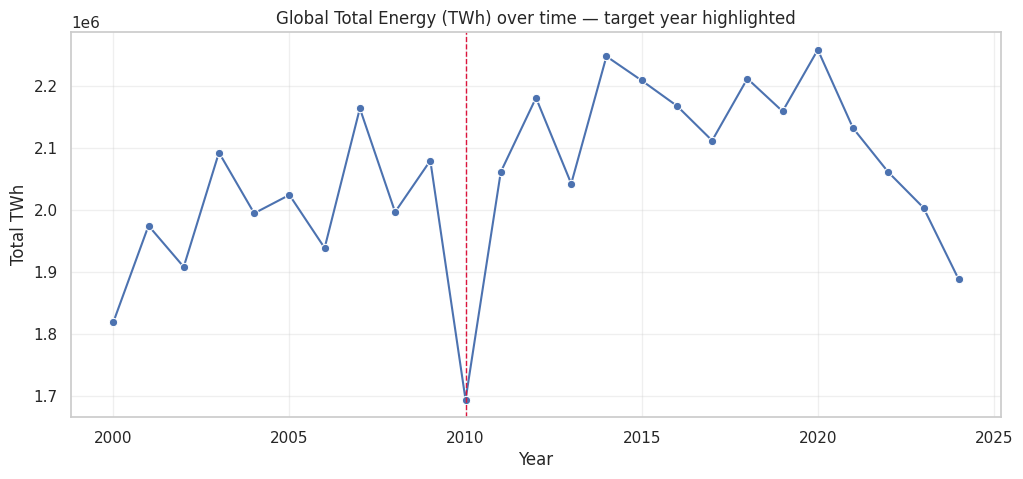

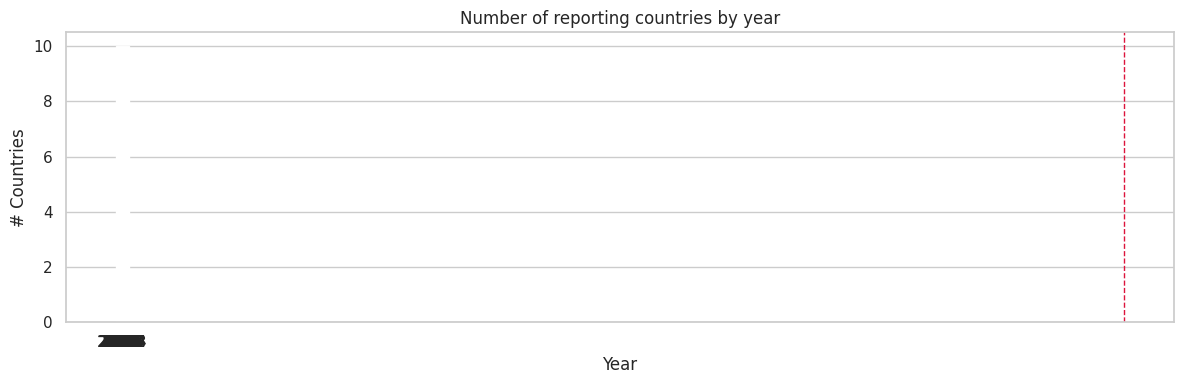

Top negative country contributions to ΔTWh (2009→2010):


country   TWh_prev   TWh_curr  Delta_TWh
6      Japan  285610.02  170889.42 -114720.60
3      China  247505.24  136447.78 -111057.46
7     Russia  258250.81  166171.57  -92079.24
9        USA  198262.36  114293.50  -83968.86
0  Australia  213888.55  162542.18  -51346.37
2     Canada  188287.97  161352.87  -26935.10
4    Germany  189361.62  189622.06     260.44
1     Brazil  140326.84  154191.81   13864.97
5      India  162323.00  189964.52   27641.52
8         UK  196016.26  248662.65   52646.39

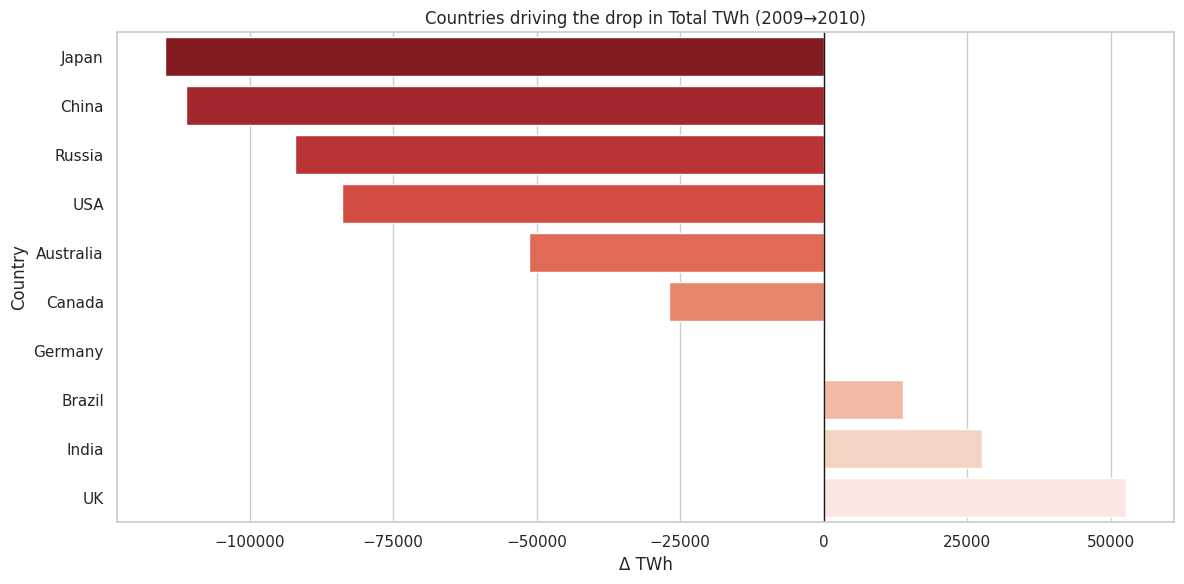

Global mix/sector change from 2009 to 2010:


metric       prev       curr     delta
0  Renewables avg %  46.364632  49.720525  3.355892
1     Fossils avg %  44.674093  44.997840  0.323746
2  Industrial avg %  39.539289  39.096605 -0.442684
3   Household avg %  25.381471  24.817037 -0.564434

year  price_usd_per_kwh       yoy
7   2007           0.273478  0.062523
8   2008           0.272396 -0.003958
9   2009           0.266593 -0.021302
10  2010           0.272191  0.020999
11  2011           0.281325  0.033556
12  2012           0.266229 -0.053660

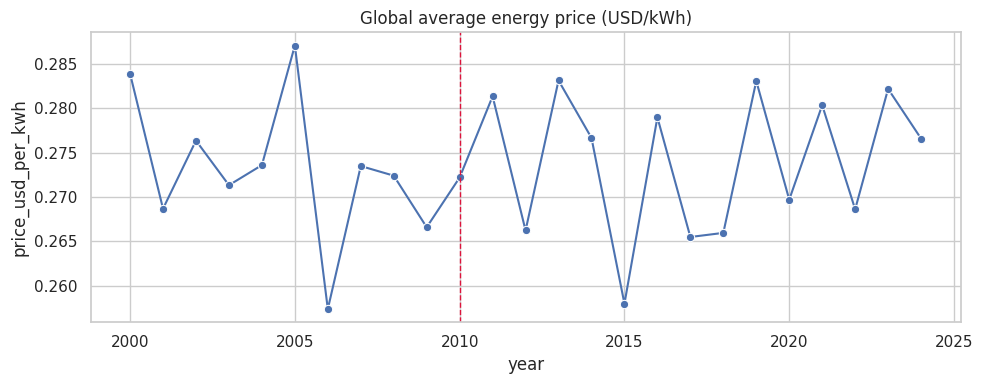

year   co2_mtons       yoy
7   2007  1052348.20  0.063042
8   2008   974748.77 -0.073739
9   2009  1061041.60  0.088528
10  2010   838600.61 -0.209644
11  2011   969451.67  0.156035
12  2012  1056834.36  0.090136

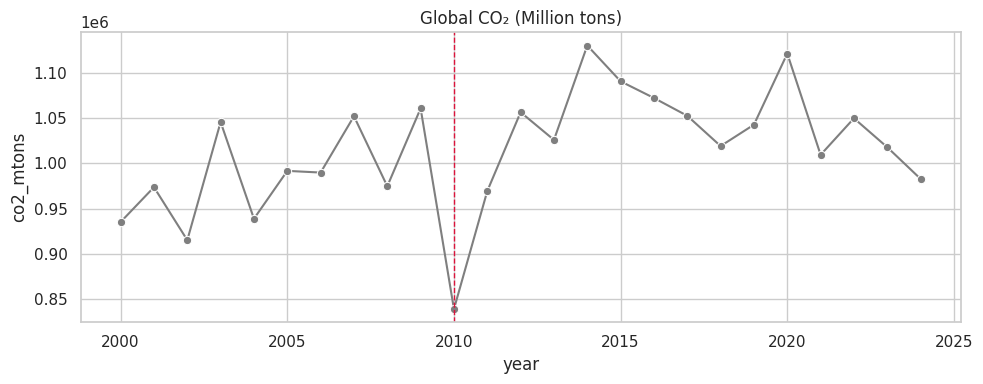

Potential duplicates found around target years:


country  year  total_twh  per_capita_kwh  renew_share_pct  \
18    Australia  2009    3115.34         1261.09            13.91   
703   Australia  2009    2473.47        13833.56            46.74   
1073  Australia  2009    7274.62        22385.47            19.50   
1201  Australia  2009    2272.21         4179.28             8.22   
1240  Australia  2009    3478.96         6738.88            12.74   
...         ...   ...        ...             ...              ...   
8574        USA  2010    6217.28        29730.56            20.97   
8598        USA  2010     714.58         1425.21            17.15   
9603        USA  2010    2180.99        31371.03            44.18   
9607        USA  2010     507.97         2606.36            37.53   
9732        USA  2010    2726.37        48684.35            85.34   

      fossil_share_pct  industrial_pct  household_pct  co2_mtons  \
18               55.84           37.58          25.35    1727.25   
703              17.34           36.00          19.59    1423.13   
1073             43.16           27.63          12.73    1876.75   
1201             46.48           50.24          26.98    2987.31   
1240             62.38           58.43          28.37    3268.58   
...                ...             ...            ...        ...   
8574             10.88           48.62          22.97    1059.00   
8598             65.86           47.66          12.99    3668.90   
9603             48.71           36.76          20.78    4562.38   
9607             23.41           40.15          28.90     296.39   
9732             62.21           48.65          33.74    3742.91   

      price_usd_per_kwh  carbon_intensity_tons_per_twh    renew_twh  \
18                 0.24                   5.544339e+05   433.343794   
703                0.22                   5.753577e+05  1156.099878   
1073               0.06                   2.579860e+05  1418.550900   
1201               0.16                   1.314716e+06   186.775662   
1240               0.37                   9.395279e+05   443.219504   
...                 ...                            ...          ...   
8574               0.27                   1.703317e+05  1303.763616   
8598               0.45                   5.134345e+06   122.550470   
9603               0.47                   2.091885e+06   963.561382   
9607               0.35                   5.834793e+05   190.641141   
9732               0.50                   1.372855e+06  2326.684158   

       fossil_twh  
18    1739.605856  
703    428.899698  
1073  3139.725992  
1201  1056.123208  
1240  2170.175248  
...           ...  
8574   676.440064  
8598   470.622388  
9603  1062.360229  
9607   118.915777  
9732  1696.074777  

[732 rows x 13 columns]

Countries present in 2009 but missing in 2010: 0
[]
Countries missing in 2009 but present in 2010: 0
[]
Extreme ΔTWh outliers (3×IQR):


Empty DataFrame
Columns: [country, TWh_prev, TWh_curr, Delta_TWh]
Index: []

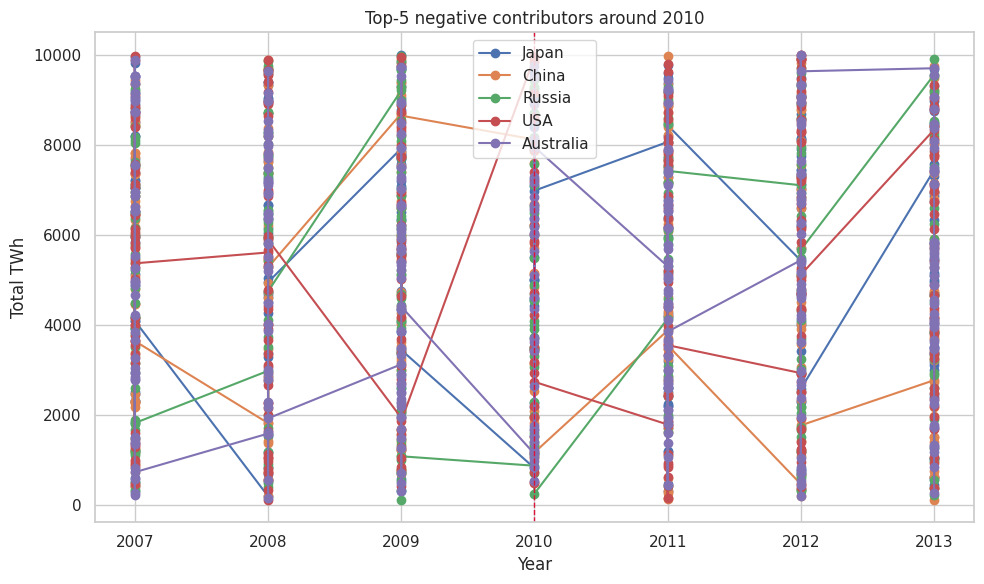

In [28]:
# ===== Why did energy consumption dip in YEAR? Diagnostic Suite =====
# Change the target year here:
TARGET_YEAR = 2010

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# --- 1) Resolve column names (works with raw or snake_case) ---
def pick(cols, options):
    for o in options:
        if o in cols: return o
    return None

D = df.copy()

year_col   = pick(D.columns, ["Year","year"])
ctry_col   = pick(D.columns, ["Country","country"])
total_col  = pick(D.columns, ["Total Energy Consumption (TWh)","total_twh"])
co2_col    = pick(D.columns, ["Carbon Emissions (Million Tons)","co2_mtons"])
price_col  = pick(D.columns, ["Energy Price Index (USD/kWh)","price_usd_per_kwh"])
renew_pct  = pick(D.columns, ["Renewable Energy Share (%)","renew_share_pct"])
fossil_pct = pick(D.columns, ["Fossil Fuel Dependency (%)","fossil_share_pct"])
ind_pct    = pick(D.columns, ["Industrial Energy Use (%)","industrial_pct"])
house_pct  = pick(D.columns, ["Household Energy Use (%)","household_pct"])

needed = [year_col, ctry_col, total_col]
if any(c is None for c in needed):
    raise ValueError("Need Year/year, Country/country, and Total Energy (TWh) in the dataframe.")

# types & sorting
for c in [year_col, total_col, co2_col, price_col, renew_pct, fossil_pct, ind_pct, house_pct]:
    if c in D.columns:
        D[c] = pd.to_numeric(D[c], errors="coerce")
D = D.dropna(subset=[year_col, ctry_col, total_col]).sort_values([year_col, ctry_col])

# --- 2) Global totals & coverage by year (sanity) ---
by_year = (D.groupby(year_col, as_index=False)
             .agg(total_TWh=(total_col,"sum"),
                  n_countries=(ctry_col,"nunique")))
by_year["yoy_total"] = by_year["total_TWh"].pct_change()
by_year["yoy_abs_TWh"] = by_year["total_TWh"].diff()

print("Global totals & coverage by year (first/last 10 rows):")
display(pd.concat([by_year.head(5), by_year.tail(5)]))

# plot with the target year highlighted
plt.figure(figsize=(12,5))
sns.lineplot(data=by_year, x=year_col, y="total_TWh", marker="o")
plt.axvline(TARGET_YEAR, color="crimson", ls="--", lw=1)
plt.title("Global Total Energy (TWh) over time — target year highlighted")
plt.xlabel("Year"); plt.ylabel("Total TWh"); plt.grid(alpha=0.3); plt.show()

plt.figure(figsize=(12,4))
sns.barplot(data=by_year, x=year_col, y="n_countries", color="tab:gray")
plt.axvline(TARGET_YEAR, color="crimson", ls="--", lw=1)
plt.title("Number of reporting countries by year")
plt.xlabel("Year"); plt.ylabel("# Countries"); plt.tight_layout(); plt.show()

# --- 3) Who moved? Country contributions to the change from (TARGET_YEAR-1) -> TARGET_YEAR ---
y_prev, y_curr = TARGET_YEAR - 1, TARGET_YEAR
prev = D[D[year_col] == y_prev].groupby(ctry_col, as_index=False)[total_col].sum().rename(columns={total_col:"TWh_prev"})
curr = D[D[year_col] == y_curr].groupby(ctry_col, as_index=False)[total_col].sum().rename(columns={total_col:"TWh_curr"})
chg  = prev.merge(curr, on=ctry_col, how="outer")
chg["TWh_prev"] = chg["TWh_prev"].fillna(0.0)
chg["TWh_curr"] = chg["TWh_curr"].fillna(0.0)
chg["Delta_TWh"] = chg["TWh_curr"] - chg["TWh_prev"]

# Top negative contributors (countries that explain the dip)
top_down = chg.sort_values("Delta_TWh").head(15)
print(f"Top negative country contributions to ΔTWh ({y_prev}→{y_curr}):")
display(top_down)

plt.figure(figsize=(12,6))
sns.barplot(data=top_down, x="Delta_TWh", y=ctry_col, palette="Reds_r")
plt.axvline(0, color="k", lw=1)
plt.title(f"Countries driving the drop in Total TWh ({y_prev}→{y_curr})")
plt.xlabel("Δ TWh"); plt.ylabel("Country"); plt.tight_layout(); plt.show()

# --- 4) Did the mix/sector change around TARGET_YEAR? (global view) ---
def safe_mean(col):
    return D[D[year_col].between(y_prev, y_curr)][col].mean() if col in D else np.nan

mix_prev = (D[D[year_col]==y_prev][[renew_pct, fossil_pct]].mean(numeric_only=True) if renew_pct and fossil_pct else pd.Series())
mix_curr = (D[D[year_col]==y_curr][[renew_pct, fossil_pct]].mean(numeric_only=True) if renew_pct and fossil_pct else pd.Series())

sect_prev = (D[D[year_col]==y_prev][[ind_pct, house_pct]].mean(numeric_only=True) if ind_pct and house_pct else pd.Series())
sect_curr = (D[D[year_col]==y_curr][[ind_pct, house_pct]].mean(numeric_only=True) if ind_pct and house_pct else pd.Series())

summary_rows = []
if not mix_prev.empty and not mix_curr.empty:
    summary_rows += [
        {"metric":"Renewables avg %", "prev":mix_prev[renew_pct], "curr":mix_curr[renew_pct], "delta":mix_curr[renew_pct]-mix_prev[renew_pct]},
        {"metric":"Fossils avg %",    "prev":mix_prev[fossil_pct], "curr":mix_curr[fossil_pct], "delta":mix_curr[fossil_pct]-mix_prev[fossil_pct]},
    ]
if not sect_prev.empty and not sect_curr.empty:
    summary_rows += [
        {"metric":"Industrial avg %", "prev":sect_prev[ind_pct], "curr":sect_curr[ind_pct], "delta":sect_curr[ind_pct]-sect_prev[ind_pct]},
        {"metric":"Household avg %",  "prev":sect_prev[house_pct], "curr":sect_curr[house_pct], "delta":sect_curr[house_pct]-sect_prev[house_pct]},
    ]
mix_sect_summary = pd.DataFrame(summary_rows)
print(f"Global mix/sector change from {y_prev} to {y_curr}:")
display(mix_sect_summary)

# --- 5) Did prices/CO2 move sharply? (global average) ---
price_tbl, co2_tbl = None, None
if price_col in D:
    price_tbl = (D.groupby(year_col, as_index=False)[price_col].mean(numeric_only=True)
                   .assign(yoy=lambda t: t[price_col].pct_change()))
    display(price_tbl[price_tbl[year_col].between(y_prev-2, y_curr+2)])

    plt.figure(figsize=(10,4))
    sns.lineplot(data=price_tbl, x=year_col, y=price_col, marker="o")
    plt.axvline(TARGET_YEAR, color="crimson", ls="--", lw=1)
    plt.title("Global average energy price (USD/kWh)")
    plt.tight_layout(); plt.show()

if co2_col in D:
    co2_tbl = (D.groupby(year_col, as_index=False)[co2_col].sum(numeric_only=True)
                 .assign(yoy=lambda t: t[co2_col].pct_change()))
    display(co2_tbl[co2_tbl[year_col].between(y_prev-2, y_curr+2)])

    plt.figure(figsize=(10,4))
    sns.lineplot(data=co2_tbl, x=year_col, y=co2_col, marker="o", color="tab:gray")
    plt.axvline(TARGET_YEAR, color="crimson", ls="--", lw=1)
    plt.title("Global CO₂ (Million tons)")
    plt.tight_layout(); plt.show()

# --- 6) Data quality checks around TARGET_YEAR ---
# (a) Country-year duplicates
dups = D[D.duplicated(subset=[ctry_col, year_col], keep=False)].sort_values([ctry_col, year_col])
if not dups.empty:
    print("Potential duplicates found around target years:")
    display(dups[dups[year_col].between(y_prev, y_curr)])

# (b) Coverage changes: which countries disappeared in TARGET_YEAR?
prev_ctys = set(prev[ctry_col].unique())
curr_ctys = set(curr[ctry_col].unique())
lost = sorted(list(prev_ctys - curr_ctys))
gained = sorted(list(curr_ctys - prev_ctys))
print(f"Countries present in {y_prev} but missing in {y_curr}: {len(lost)}")
print(lost[:25])
print(f"Countries missing in {y_prev} but present in {y_curr}: {len(gained)}")
print(gained[:25])

# (c) Extreme outliers in ΔTWh (possible unit issues)
q1, q3 = chg["Delta_TWh"].quantile(0.25), chg["Delta_TWh"].quantile(0.75)
iqr = q3 - q1
lo, hi = q1 - 3*iqr, q3 + 3*iqr
sus = chg[(chg["Delta_TWh"] < lo) | (chg["Delta_TWh"] > hi)]
print("Extreme ΔTWh outliers (3×IQR):")
display(sus.sort_values("Delta_TWh").head(15))

# --- 7) Optional: show the top 5 countries’ time series around TARGET_YEAR (T-3..T+3) ---
top5 = (chg.sort_values("Delta_TWh").head(5)[ctry_col].tolist())
window = list(range(TARGET_YEAR-3, TARGET_YEAR+4))
if top5:
    sub = D[(D[ctry_col].isin(top5)) & (D[year_col].isin(window))][[ctry_col, year_col, total_col]]
    plt.figure(figsize=(10,6))
    for c in top5:
        s = sub[sub[ctry_col]==c].sort_values(year_col)
        plt.plot(s[year_col], s[total_col], marker="o", label=c)
    plt.axvline(TARGET_YEAR, color="crimson", ls="--", lw=1)
    plt.title(f"Top-5 negative contributors around {TARGET_YEAR}")
    plt.xlabel("Year"); plt.ylabel("Total TWh")
    plt.legend(); plt.tight_layout(); plt.show()


In [29]:
# ============================================
# Year Drilldown Diagnostics (reusable)
# Usage:
#   results = diagnose_year(df, 2010, top_k=15, window=3)
# ============================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

def diagnose_year(D_in: pd.DataFrame, target_year: int, top_k: int = 15, window: int = 3,
                  limit_countries_plot: int = 5, figsize_base=(12,5)):
    """
    Diagnose a dip/spike in total energy around `target_year`.
    - Works with either original column names or snake_case.
    - Prints plots + tables and returns a dict of key DataFrames.

    Parameters
    ----------
    D_in : pd.DataFrame  Your dataset (df or data)
    target_year : int    Year to analyze (e.g., 2010)
    top_k : int          How many top negative contributors to show
    window : int         Years before/after to show in time-window plots
    limit_countries_plot : int  How many top negative contributors to plot as lines
    figsize_base : tuple Base figure size for the main plots

    Returns
    -------
    dict with:
      - by_year, change_by_country, mix_sector_summary, price_tbl, co2_tbl,
        coverage_changes, extreme_deltas
    """

    # -------- 0) Resolve columns (robust to naming) --------
    def pick(cols, options):
        for o in options:
            if o in cols: return o
        return None

    D = D_in.copy()

    year_col   = pick(D.columns, ["Year","year"])
    ctry_col   = pick(D.columns, ["Country","country"])
    total_col  = pick(D.columns, ["Total Energy Consumption (TWh)","total_twh"])
    co2_col    = pick(D.columns, ["Carbon Emissions (Million Tons)","co2_mtons"])
    price_col  = pick(D.columns, ["Energy Price Index (USD/kWh)","price_usd_per_kwh"])
    renew_pct  = pick(D.columns, ["Renewable Energy Share (%)","renew_share_pct"])
    fossil_pct = pick(D.columns, ["Fossil Fuel Dependency (%)","fossil_share_pct"])
    ind_pct    = pick(D.columns, ["Industrial Energy Use (%)","industrial_pct"])
    house_pct  = pick(D.columns, ["Household Energy Use (%)","household_pct"])

    needed = [year_col, ctry_col, total_col]
    if any(c is None for c in needed):
        raise ValueError("Need Year/year, Country/country, and Total Energy (TWh) present in the dataframe.")

    # Types & clean
    for c in [year_col, total_col, co2_col, price_col, renew_pct, fossil_pct, ind_pct, house_pct]:
        if c in D.columns:
            D[c] = pd.to_numeric(D[c], errors="coerce")
    D = D.dropna(subset=[year_col, ctry_col, total_col]).sort_values([year_col, ctry_col])

    y_prev, y_curr = target_year - 1, target_year

    # -------- 1) Global totals & coverage by year --------
    by_year = (D.groupby(year_col, as_index=False)
                 .agg(total_TWh=(total_col,"sum"),
                      n_countries=(ctry_col,"nunique")))
    by_year["yoy_total"] = by_year["total_TWh"].pct_change()
    by_year["yoy_abs_TWh"] = by_year["total_TWh"].diff()

    # Plots
    plt.figure(figsize=figsize_base)
    sns.lineplot(data=by_year, x=year_col, y="total_TWh", marker="o")
    plt.axvline(target_year, color="crimson", ls="--", lw=1)
    plt.title("Global Total Energy (TWh) — target year highlighted")
    plt.xlabel("Year"); plt.ylabel("Total TWh"); plt.grid(alpha=0.3); plt.show()

    plt.figure(figsize=(figsize_base[0], 4))
    sns.barplot(data=by_year, x=year_col, y="n_countries", color="tab:gray")
    plt.axvline(target_year, color="crimson", ls="--", lw=1)
    plt.title("Number of reporting countries by year")
    plt.xlabel("Year"); plt.ylabel("# Countries"); plt.tight_layout(); plt.show()

    # -------- 2) Country-level contributions to ΔTWh --------
    prev = (D[D[year_col] == y_prev]
              .groupby(ctry_col, as_index=False)[total_col].sum()
              .rename(columns={total_col:"TWh_prev"}))
    curr = (D[D[year_col] == y_curr]
              .groupby(ctry_col, as_index=False)[total_col].sum()
              .rename(columns={total_col:"TWh_curr"}))
    chg  = prev.merge(curr, on=ctry_col, how="outer")
    chg["TWh_prev"] = chg["TWh_prev"].fillna(0.0)
    chg["TWh_curr"] = chg["TWh_curr"].fillna(0.0)
    chg["Delta_TWh"] = chg["TWh_curr"] - chg["TWh_prev"]

    top_down = chg.sort_values("Delta_TWh").head(top_k)
    plt.figure(figsize=(12, max(5, 0.4*len(top_down))))
    sns.barplot(data=top_down, x="Delta_TWh", y=ctry_col, palette="Reds_r")
    plt.axvline(0, color="k", lw=1)
    plt.title(f"Top negative contributors to ΔTWh ({y_prev}→{y_curr})")
    plt.xlabel("Δ TWh"); plt.ylabel("Country"); plt.tight_layout(); plt.show()

    # -------- 3) Mix/Sector average changes (global) --------
    rows = []
    if renew_pct and fossil_pct:
        mix_prev = D[D[year_col]==y_prev][[renew_pct, fossil_pct]].mean(numeric_only=True)
        mix_curr = D[D[year_col]==y_curr][[renew_pct, fossil_pct]].mean(numeric_only=True)
        if not mix_prev.empty and not mix_curr.empty:
            rows += [
                {"metric":"Renewables avg %", "prev":mix_prev.get(renew_pct, np.nan),
                 "curr":mix_curr.get(renew_pct, np.nan),
                 "delta":mix_curr.get(renew_pct, np.nan) - mix_prev.get(renew_pct, np.nan)},
                {"metric":"Fossils avg %",    "prev":mix_prev.get(fossil_pct, np.nan),
                 "curr":mix_curr.get(fossil_pct, np.nan),
                 "delta":mix_curr.get(fossil_pct, np.nan) - mix_prev.get(fossil_pct, np.nan)},
            ]
    if ind_pct and house_pct:
        sect_prev = D[D[year_col]==y_prev][[ind_pct, house_pct]].mean(numeric_only=True)
        sect_curr = D[D[year_col]==y_curr][[ind_pct, house_pct]].mean(numeric_only=True)
        if not sect_prev.empty and not sect_curr.empty:
            rows += [
                {"metric":"Industrial avg %", "prev":sect_prev.get(ind_pct, np.nan),
                 "curr":sect_curr.get(ind_pct, np.nan),
                 "delta":sect_curr.get(ind_pct, np.nan) - sect_prev.get(ind_pct, np.nan)},
                {"metric":"Household avg %",  "prev":sect_prev.get(house_pct, np.nan),
                 "curr":sect_curr.get(house_pct, np.nan),
                 "delta":sect_curr.get(house_pct, np.nan) - sect_prev.get(house_pct, np.nan)},
            ]
    mix_sector_summary = pd.DataFrame(rows)

    if not mix_sector_summary.empty:
        display(mix_sector_summary)

    # -------- 4) Price & CO2 context (global) --------
    price_tbl, co2_tbl = None, None
    if price_col and price_col in D:
        price_tbl = (D.groupby(year_col, as_index=False)[price_col]
                       .mean(numeric_only=True)
                       .assign(yoy=lambda t: t[price_col].pct_change()))
        # narrow view around target
        pad = max(2, window)
        display(price_tbl[price_tbl[year_col].between(y_prev-pad, y_curr+pad)])

        plt.figure(figsize=(10,4))
        sns.lineplot(data=price_tbl, x=year_col, y=price_col, marker="o")
        plt.axvline(target_year, color="crimson", ls="--", lw=1)
        plt.title("Global average energy price (USD/kWh)")
        plt.tight_layout(); plt.show()

    if co2_col and co2_col in D:
        co2_tbl = (D.groupby(year_col, as_index=False)[co2_col]
                     .sum(numeric_only=True)
                     .assign(yoy=lambda t: t[co2_col].pct_change()))
        pad = max(2, window)
        display(co2_tbl[co2_col][co2_tbl[year_col].between(y_prev-pad, y_curr+pad)])

        plt.figure(figsize=(10,4))
        sns.lineplot(data=co2_tbl, x=year_col, y=co2_col, marker="o", color="tab:gray")
        plt.axvline(target_year, color="crimson", ls="--", lw=1)
        plt.title("Global CO₂ (Million tons)")
        plt.tight_layout(); plt.show()

    # -------- 5) Data quality checks --------
    # (a) Country-year duplicates
    dups = D[D.duplicated(subset=[ctry_col, year_col], keep=False)].sort_values([ctry_col, year_col])
    if not dups.empty:
        print("Potential duplicates (country-year):")
        display(dups[dups[year_col].between(y_prev, y_curr)])

    # (b) Coverage changes between years
    prev_ctys = set(prev[ctry_col].unique())
    curr_ctys = set(curr[ctry_col].unique())
    lost   = sorted(list(prev_ctys - curr_ctys))
    gained = sorted(list(curr_ctys - prev_ctys))
    coverage_changes = {
        "lost_count": len(lost),
        "lost_example": lost[:25],
        "gained_count": len(gained),
        "gained_example": gained[:25],
    }
    print(f"Countries present in {y_prev} but missing in {y_curr}: {coverage_changes['lost_count']}")
    print(coverage_changes["lost_example"])
    print(f"Countries missing in {y_prev} but present in {y_curr}: {coverage_changes['gained_count']}")
    print(coverage_changes["gained_example"])

    # (c) Extreme ΔTWh outliers (3×IQR)
    q1, q3 = chg["Delta_TWh"].quantile(0.25), chg["Delta_TWh"].quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 3*iqr, q3 + 3*iqr
    extreme = chg[(chg["Delta_TWh"] < lo) | (chg["Delta_TWh"] > hi)].copy()
    extreme = extreme.sort_values("Delta_TWh")
    if not extreme.empty:
        print("Extreme ΔTWh outliers (3×IQR):")
        display(extreme.head(15))

    # -------- 6) Top negative contributors: time-window lines --------
    top5 = top_down[ctry_col].head(limit_countries_plot).tolist()
    if top5:
        years_window = list(range(target_year - window, target_year + window + 1))
        sub = D[(D[ctry_col].isin(top5)) & (D[year_col].isin(years_window))][[ctry_col, year_col, total_col]]
        plt.figure(figsize=(10, 6))
        for c in top5:
            s = sub[sub[ctry_col]==c].sort_values(year_col)
            plt.plot(s[year_col], s[total_col], marker="o", label=c)
        plt.axvline(target_year, color="crimson", ls="--", lw=1)
        plt.title(f"Top contributors around {target_year} (±{window} years)")
        plt.xlabel("Year"); plt.ylabel("Total TWh")
        plt.legend(); plt.tight_layout(); plt.show()

    # -------- Return useful tables --------
    return {
        "by_year": by_year,
        "change_by_country": chg.sort_values("Delta_TWh"),
        "mix_sector_summary": mix_sector_summary,
        "price_tbl": price_tbl,
        "co2_tbl": co2_tbl,
        "coverage_changes": coverage_changes,
        "extreme_deltas": extreme
    }

# ---- Example call ----
# results_2010 = diagnose_year(df, 2010, top_k=15, window=3)


In [30]:
# =============================
# Renewable Adoption Forecasting
# Step 1: Setup & column mapping
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep learning (Colab usually has TF preinstalled)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
except Exception as e:
    raise RuntimeError("TensorFlow not available. In Colab run: !pip -q install tensorflow") from e

np.random.seed(42)
tf.random.set_seed(42)

OUT = Path("/content/energy_outputs/models")
OUT.mkdir(parents=True, exist_ok=True)

# ---- Resolve column names (works with raw/or snake_case) ----
def pick(cols, options):
    for o in options:
        if o in cols: return o
    return None

def make_working_df(df):
    """Return a tidy frame with unified names + numeric types."""
    m = {
        'country': pick(df.columns, ['country','Country']),
        'year': pick(df.columns, ['year','Year']),
        'renew_share_pct': pick(df.columns, ['renew_share_pct','Renewable Energy Share (%)']),
        'fossil_share_pct': pick(df.columns, ['fossil_share_pct','Fossil Fuel Dependency (%)']),
        'total_twh': pick(df.columns, ['total_twh','Total Energy Consumption (TWh)']),
        'per_capita_kwh': pick(df.columns, ['per_capita_kwh','Per Capita Energy Use (kWh)']),
        'price_usd_per_kwh': pick(df.columns, ['price_usd_per_kwh','Energy Price Index (USD/kWh)']),
        'co2_mtons': pick(df.columns, ['co2_mtons','Carbon Emissions (Million Tons)']),
        'industrial_pct': pick(df.columns, ['industrial_pct','Industrial Energy Use (%)']),
        'household_pct': pick(df.columns, ['household_pct','Household Energy Use (%)']),
    }
    if any(m[k] is None for k in ['country','year','renew_share_pct']):
        raise ValueError("Need country/year/renewables columns present in df.")
    W = df[[c for c in m.values() if c is not None]].copy()
    # Rename to unified names
    inv = {v:k for k,v in m.items() if v is not None}
    W = W.rename(columns=inv)
    # Numeric coercion
    for c in W.columns:
        if c not in ['country']:
            W[c] = pd.to_numeric(W[c], errors='coerce')
    W = W.dropna(subset=['country','year','renew_share_pct']).sort_values(['country','year'])
    return W

W = make_working_df(df)
print("Working frame:", W.shape, "| years:", int(W.year.min()), "→", int(W.year.max()), "| countries:", W.country.nunique())
W.head()



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



RuntimeError: TensorFlow not available. In Colab run: !pip -q install tensorflow

In [ ]:
# =============================
# Renewable Adoption Forecasting
# Step 1: Setup & column mapping
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fix TensorFlow installation
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("Installing TensorFlow...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    print(f"TensorFlow version: {tf.__version__}")

np.random.seed(42)
tf.random.set_seed(42)

# Create output directory
from pathlib import Path
OUT = Path("./energy_outputs/models")
OUT.mkdir(parents=True, exist_ok=True)

# ---- Resolve column names (works with raw/or snake_case) ----
def pick(cols, options):
    for o in options:
        if o in cols: return o
    return None

def make_working_df(df):
    """Return a tidy frame with unified names + numeric types."""
    m = {
        'country': pick(df.columns, ['country','Country']),
        'year': pick(df.columns, ['year','Year']),
        'renew_share_pct': pick(df.columns, ['renew_share_pct','Renewable Energy Share (%)']),
        'fossil_share_pct': pick(df.columns, ['fossil_share_pct','Fossil Fuel Dependency (%)']),
        'total_twh': pick(df.columns, ['total_twh','Total Energy Consumption (TWh)']),
        'per_capita_kwh': pick(df.columns, ['per_capita_kwh','Per Capita Energy Use (kWh)']),
        'price_usd_per_kwh': pick(df.columns, ['price_usd_per_kwh','Energy Price Index (USD/kWh)']),
        'co2_mtons': pick(df.columns, ['co2_mtons','Carbon Emissions (Million Tons)']),
        'industrial_pct': pick(df.columns, ['industrial_pct','Industrial Energy Use (%)']),
        'household_pct': pick(df.columns, ['household_pct','Household Energy Use (%)']),
    }

    # Check required columns
    required = ['country', 'year', 'renew_share_pct']
    missing = [k for k in required if m[k] is None]
    if missing:
        print("Available columns:", df.columns.tolist())
        raise ValueError(f"Missing required columns: {missing}")

    # Select available columns
    available_cols = [c for c in m.values() if c is not None]
    W = df[available_cols].copy()

    # Rename to unified names
    inv = {v:k for k,v in m.items() if v is not None}
    W = W.rename(columns=inv)

    # Numeric coercion
    for c in W.columns:
        if c not in ['country']:
            W[c] = pd.to_numeric(W[c], errors='coerce')

    W = W.dropna(subset=['country','year','renew_share_pct']).sort_values(['country','year'])
    return W

# Create working dataframe
W = make_working_df(df)
print("Working frame:", W.shape, "| years:", int(W.year.min()), "→", int(W.year.max()), "| countries:", W.country.nunique())
print("\nAvailable features:", [col for col in W.columns if col not in ['country', 'year']])
W.head()

In [ ]:
# --- Install a Python 3.12–compatible TF and a compatible NumPy ---
!pip -q install -U pip setuptools wheel
# Pin numpy below 2.0 (avoids the docstring conflict) and install TF 2.17 (Py3.12-compatible)
!pip -q install "numpy<2.0" "tensorflow==2.17.1" "keras==3.4.1"

# Optional: remove any nightly/legacy packages that can cause conflicts
!pip -q uninstall -y keras-nightly tf-keras-nightly tf-keras keras-tuner || true

# Sanity check: import should succeed after restart
print(">> Installed. Please restart the runtime (Runtime > Restart runtime) before proceeding.")


In [ ]:
# =============================
# Renewable Adoption Forecasting
# Step 1: Setup & column mapping
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep learning (Colab usually has TF preinstalled)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
except Exception as e:
    raise RuntimeError("TensorFlow not available. In Colab run: !pip -q install tensorflow") from e

np.random.seed(42)
tf.random.set_seed(42)

OUT = Path("/content/energy_outputs/models")
OUT.mkdir(parents=True, exist_ok=True)

# ---- Resolve column names (works with raw/or snake_case) ----
def pick(cols, options):
    for o in options:
        if o in cols: return o
    return None

def make_working_df(df):
    """Return a tidy frame with unified names + numeric types."""
    m = {
        'country': pick(df.columns, ['country','Country']),
        'year': pick(df.columns, ['year','Year']),
        'renew_share_pct': pick(df.columns, ['renew_share_pct','Renewable Energy Share (%)']),
        'fossil_share_pct': pick(df.columns, ['fossil_share_pct','Fossil Fuel Dependency (%)']),
        'total_twh': pick(df.columns, ['total_twh','Total Energy Consumption (TWh)']),
        'per_capita_kwh': pick(df.columns, ['per_capita_kwh','Per Capita Energy Use (kWh)']),
        'price_usd_per_kwh': pick(df.columns, ['price_usd_per_kwh','Energy Price Index (USD/kWh)']),
        'co2_mtons': pick(df.columns, ['co2_mtons','Carbon Emissions (Million Tons)']),
        'industrial_pct': pick(df.columns, ['industrial_pct','Industrial Energy Use (%)']),
        'household_pct': pick(df.columns, ['household_pct','Household Energy Use (%)']),
    }
    if any(m[k] is None for k in ['country','year','renew_share_pct']):
        raise ValueError("Need country/year/renewables columns present in df.")
    W = df[[c for c in m.values() if c is not None]].copy()
    # Rename to unified names
    inv = {v:k for k,v in m.items() if v is not None}
    W = W.rename(columns=inv)
    # Numeric coercion
    for c in W.columns:
        if c not in ['country']:
            W[c] = pd.to_numeric(W[c], errors='coerce')
    W = W.dropna(subset=['country','year','renew_share_pct']).sort_values(['country','year'])
    return W

W = make_working_df(df)
print("Working frame:", W.shape, "| years:", int(W.year.min()), "→", int(W.year.max()), "| countries:", W.country.nunique())
W.head()


In [ ]:
# Reinstall sklearn compatible with Py3.12 / NumPy <2.0
!pip install --upgrade --force-reinstall "scikit-learn==1.4.2"


In [ ]:
# ============================================================
# CLEAN BOOTSTRAP (Colab, Python 3.12)
# Pins a compatible ML stack and removes conflicting packages.
# After it finishes: Runtime → Restart runtime
# ============================================================

# 1) Core tooling fresh
!pip -q install -U pip setuptools wheel

# 2) Remove conflicting/nightly packages if present (ignore errors)
!pip -q uninstall -y keras-nightly tf-keras-nightly tf-keras keras-tuner || true

# 3) Install a compatible stack
#    - numpy < 2.0 (avoids TF docstring conflict)
#    - scikit-learn 1.4.2 (works well with Py3.12 / NumPy<2)
#    - tensorflow 2.17.1 + keras 3.4.1 (Py3.12-compatible)
#    - pandas/seaborn/matplotlib (ensure recent, stable)
!pip -q install "numpy<2.0" \
                "scikit-learn==1.4.2" \
                "tensorflow==2.17.1" \
                "keras==3.4.1" \
                "pandas>=2.0.0" \
                "seaborn>=0.13.0" \
                "matplotlib>=3.8.0"

# (Optional) If you prefer PyTorch for the RNN, uncomment the next line instead of TensorFlow:
# !pip -q install "torch==2.3.1" "torchvision==0.18.1" "torchaudio==2.3.1"

# 4) Show what we got so you can verify
import sys, importlib
print("Python:", sys.version)
for mod in ["numpy","pandas","sklearn","tensorflow","keras","seaborn","matplotlib"]:
    try:
        m = importlib.import_module(mod if mod!="sklearn" else "sklearn")
        print(f"{mod:11s}", getattr(m, "__version__", "ok"))
    except Exception as e:
        print(f"{mod:11s}", "NOT INSTALLED", e)

print("\n✅ Installed. Now go to: Runtime → Restart runtime, then re-run your notebook cells.")


In [ ]:
# =============================
# Renewable Adoption Forecasting
# Step 1: Setup & column mapping (no TF import here)
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(42)

OUT = Path("/content/energy_outputs/models")
OUT.mkdir(parents=True, exist_ok=True)

# ---- Resolve column names (works with raw/or snake_case) ----
def pick(cols, options):
    for o in options:
        if o in cols: return o
    return None

def make_working_df(df):
    """Return a tidy frame with unified names + numeric types."""
    m = {
        'country': pick(df.columns, ['country','Country']),
        'year': pick(df.columns, ['year','Year']),
        'renew_share_pct': pick(df.columns, ['renew_share_pct','Renewable Energy Share (%)']),
        'fossil_share_pct': pick(df.columns, ['fossil_share_pct','Fossil Fuel Dependency (%)']),
        'total_twh': pick(df.columns, ['total_twh','Total Energy Consumption (TWh)']),
        'per_capita_kwh': pick(df.columns, ['per_capita_kwh','Per Capita Energy Use (kWh)']),
        'price_usd_per_kwh': pick(df.columns, ['price_usd_per_kwh','Energy Price Index (USD/kWh)']),
        'co2_mtons': pick(df.columns, ['co2_mtons','Carbon Emissions (Million Tons)']),
        'industrial_pct': pick(df.columns, ['industrial_pct','Industrial Energy Use (%)']),
        'household_pct': pick(df.columns, ['household_pct','Household Energy Use (%)']),
    }
    if any(m[k] is None for k in ['country','year','renew_share_pct']):
        raise ValueError("Need country/year/renewables columns present in df.")
    W = df[[c for c in m.values() if c is not None]].copy()
    # Rename to unified names
    inv = {v:k for k,v in m.items() if v is not None}
    W = W.rename(columns=inv)
    # Numeric coercion
    for c in W.columns:
        if c not in ['country']:
            W[c] = pd.to_numeric(W[c], errors='coerce')
    W = W.dropna(subset=['country','year','renew_share_pct']).sort_values(['country','year'])
    return W

W = make_working_df(df)
print("Working frame:", W.shape, "| years:", int(W.year.min()), "→", int(W.year.max()), "| countries:", W.country.nunique())
W.head()


In [ ]:
# =======================================================
# Step 2: Construct label y(t+1) and leakage-safe features
# =======================================================

W = W.sort_values(['country','year']).copy()
W['y_next_renew'] = W.groupby('country')['renew_share_pct'].shift(-1)

min_hist = 5
valid_countries = W.groupby('country')['year'].nunique()
keep_countries = valid_countries[valid_countries >= min_hist].index
W = W[W['country'].isin(keep_countries)].copy()

base_feats = ['renew_share_pct','fossil_share_pct','total_twh','per_capita_kwh',
              'price_usd_per_kwh','co2_mtons','industrial_pct','household_pct']

lag_sources = ['renew_share_pct','price_usd_per_kwh','total_twh','co2_mtons']
for c in lag_sources:
    if c in W.columns:
        for L in [1,2,3]:
            W[f'{c}_lag{L}'] = W.groupby('country')[c].shift(L)

if 'renew_share_pct' in W:
    W['renew_ma3'] = W.groupby('country')['renew_share_pct'].transform(lambda s: s.rolling(3, min_periods=1).mean())
if 'price_usd_per_kwh' in W:
    W['price_ma3'] = W.groupby('country')['price_usd_per_kwh'].transform(lambda s: s.rolling(3, min_periods=1).mean())

tabular_feats = [c for c in (
    base_feats +
    [f'{c}_lag{L}' for c in lag_sources for L in [1,2,3] if f'{c}_lag{L}' in W.columns] +
    ['renew_ma3','price_ma3']
) if c in W.columns]

D = W.dropna(subset=['y_next_renew']).copy()

last_year = int(D['year'].max())
T0 = last_year - 2
train = D[D['year'] <= T0]
val   = D[D['year'] == T0 + 1]
test  = D[D['year'] == last_year]

print(f"Split years — train ≤ {T0}, val = {T0+1}, test = {last_year}")
print("Rows:", len(train), len(val), len(test))


In [ ]:
# === Naïve baseline: predict next year's renew as this year's renew ===
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

naive_pred = test['renew_share_pct'].values  # y_hat_{t+1} := renew_share_pct(t)
y_test = test['y_next_renew'].values

naive_mae  = mean_absolute_error(y_test, naive_pred)
naive_rmse = mean_squared_error(y_test, naive_pred, squared=False)
naive_r2   = r2_score(y_test, naive_pred)

print({"NAIVE Test MAE": round(naive_mae,3),
       "RMSE": round(naive_rmse,3),
       "R2": round(naive_r2,3)})


In [ ]:
# === Rebuild target to be delta: Δrenew = renew(t+1) - renew(t) ===
W_delta = W.copy()
W_delta['y_next_delta'] = W_delta['y_next_renew'] - W_delta['renew_share_pct']

D = W_delta.dropna(subset=['y_next_delta']).copy()
last_year = int(D['year'].max())
T0 = last_year - 2
train_d = D[D['year'] <= T0]
val_d   = D[D['year'] == T0 + 1]
test_d  = D[D['year'] == last_year]

# Use the same tabular_feats from Step 2
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Drop very sparse or all-NaN features (70% threshold)
MISS_THRESH = 0.70
miss_train = train_d[tabular_feats].isna().mean()
feats_used = [f for f in tabular_feats if train_d[f].notna().any() and miss_train.get(f,0) <= MISS_THRESH]

Xtr, ytr = train_d[feats_used], train_d['y_next_delta']
Xv,  yv  = val_d[feats_used],   val_d['y_next_delta']
Xt,  yt  = test_d[feats_used],  test_d['y_next_delta']

def knn_pipe(k):
    return Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('sc',  StandardScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=k, weights='distance'))
    ])

best, best_k, best_mae = None, None, 1e9
for k in [3,5,7,9,11,15]:
    m = knn_pipe(k).fit(Xtr, ytr)
    pv = m.predict(Xv)
    mae = mean_absolute_error(yv, pv)
    if mae < best_mae:
        best, best_k, best_mae = m, k, mae

print("Δ KNN best k:", best_k, "val MAE:", round(best_mae,3))

# Convert predicted Δ back to level for TEST
pred_delta = best.predict(Xt)
pred_level = np.clip(test_d['renew_share_pct'].values + pred_delta, 0, 100)

y_true_level = test_d['y_next_renew'].values
print({
    "ΔKNN->Level Test MAE": round(mean_absolute_error(y_true_level, pred_level),3),
    "RMSE": round(mean_squared_error(y_true_level, pred_level, squared=False),3),
    "R2": round(r2_score(y_true_level, pred_level),3)
})


In [ ]:
# === Gradient Boosting on Δ (often a big jump over KNN) ===
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer

# Pipeline: Impute -> (optional scale for linear models; trees don't need scaling)
gb_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('gb',  GradientBoostingRegressor(
        n_estimators=600, learning_rate=0.03, max_depth=3, subsample=0.8, random_state=42
    ))
])
gb_pipe.fit(Xtr, ytr)

# Validate, then Test
pred_delta_val = gb_pipe.predict(Xv)
print("GB Δ Val MAE:", round(mean_absolute_error(yv, pred_delta_val),3))

pred_delta_test = gb_pipe.predict(Xt)
pred_level_test = np.clip(test_d['renew_share_pct'].values + pred_delta_test, 0, 100)

mae  = mean_absolute_error(y_true_level, pred_level_test)
rmse = mean_squared_error(y_true_level, pred_level_test, squared=False)
r2   = r2_score(y_true_level, pred_level_test)
print({"GB Δ→Level Test MAE": round(mae,3), "RMSE": round(rmse,3), "R2": round(r2,3)})

# Quick feature importance
imp = gb_pipe.named_steps['gb'].feature_importances_
fi = (pd.Series(imp, index=feats_used)
        .sort_values(ascending=False)
        .head(20))
print("\nTop features (GB):")
print(fi.round(3))


In [ ]:
# === Optional: demean some “level” features by country before modeling Δ ===
norm_cols = [c for c in ['renew_share_pct','price_usd_per_kwh','total_twh','co2_mtons','per_capita_kwh'] if c in W.columns]
Wn = W.copy()
for c in norm_cols:
    Wn[c+'_cnorm'] = Wn[c] - Wn.groupby('country')[c].transform('mean')

# Rebuild Δ labels quickly using Wn and rerun 2) or 3) with cnorm features added to feats_used.


In [ ]:
# === Gradient Boosting on Δ (often a big jump over KNN) ===
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer

# Pipeline: Impute -> (optional scale for linear models; trees don't need scaling)
gb_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('gb',  GradientBoostingRegressor(
        n_estimators=600, learning_rate=0.03, max_depth=3, subsample=0.8, random_state=42
    ))
])
gb_pipe.fit(Xtr, ytr)

# Validate, then Test
pred_delta_val = gb_pipe.predict(Xv)
print("GB Δ Val MAE:", round(mean_absolute_error(yv, pred_delta_val),3))

pred_delta_test = gb_pipe.predict(Xt)
pred_level_test = np.clip(test_d['renew_share_pct'].values + pred_delta_test, 0, 100)

mae  = mean_absolute_error(y_true_level, pred_level_test)
rmse = mean_squared_error(y_true_level, pred_level_test, squared=False)
r2   = r2_score(y_true_level, pred_level_test)
print({"GB Δ→Level Test MAE": round(mae,3), "RMSE": round(rmse,3), "R2": round(r2,3)})

# Quick feature importance
imp = gb_pipe.named_steps['gb'].feature_importances_
fi = (pd.Series(imp, index=feats_used)
        .sort_values(ascending=False)
        .head(20))
print("\nTop features (GB):")
print(fi.round(3))


In [ ]:
# ======================================================
# A) Rebuild Δ dataset (y_next_delta) and leakage-safe splits
# ======================================================
import numpy as np
import pandas as pd

# Starting point: W from your earlier Step 1 (unified columns) and tabular_feats from Step 2
# y_next_renew already created in Step 2; recreate if needed:
if 'y_next_renew' not in W.columns:
    W = W.sort_values(['country','year']).copy()
    W['y_next_renew'] = W.groupby('country')['renew_share_pct'].shift(-1)

# Δ target
W_delta = W.copy()
W_delta['y_next_delta'] = W_delta['y_next_renew'] - W_delta['renew_share_pct']

# Keep rows with target
D = W_delta.dropna(subset=['y_next_delta']).copy()

# Train / Val / Test by time (no leakage)
last_year = int(D['year'].max())
T0 = last_year - 2         # train ≤ T0, val = T0+1, test = last_year
train_d = D[D['year'] <= T0]
val_d   = D[D['year'] == T0 + 1]
test_d  = D[D['year'] == last_year]

print(f"Years → train ≤ {T0}, val = {T0+1}, test = {last_year}")
print("Rows:", len(train_d), len(val_d), len(test_d))

# Feature list from Step 2, but filter for sparsity (70%) on TRAIN
from sklearn.impute import SimpleImputer
MISS_THRESH = 0.70
miss_train = train_d[tabular_feats].isna().mean()
feats_used = [f for f in tabular_feats if train_d[f].notna().any() and miss_train.get(f,0) <= MISS_THRESH]
assert len(feats_used) > 0, "No usable features after filtering; lower MISS_THRESH or revisit Step 2."

Xtr, ytr = train_d[feats_used], train_d['y_next_delta']
Xv,  yv  = val_d[feats_used],   val_d['y_next_delta']
Xt,  yt  = test_d[feats_used],  test_d['y_next_delta']

# Also keep level y for reporting
y_true_level_test = test_d['y_next_renew'].values
y_level_base_test = test_d['renew_share_pct'].values  # current-year level, to add Δ back later

print("Features used (len={}):".format(len(feats_used)))
print(sorted(feats_used)[:20], "...")


In [ ]:
# ======================================================
# B) Naïve baseline + GradientBoosting + LightGBM on Δ
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

# ---- Helper to evaluate Δ→level ----
def eval_delta_to_level(delta_pred, y_level_base, y_level_true, label="model"):
    yhat_level = np.clip(y_level_base + delta_pred, 0, 100)
    mae  = mean_absolute_error(y_level_true, yhat_level)
    rmse = mean_squared_error(y_level_true, yhat_level, squared=False)
    r2   = r2_score(y_level_true, yhat_level)
    print({f"{label} Test MAE": round(mae,3), "RMSE": round(rmse,3), "R2": round(r2,3)})
    return yhat_level, {"MAE": mae, "RMSE": rmse, "R2": r2}

# =========================
# 1) Naïve baseline on level
# =========================
naive_pred_level = np.clip(y_level_base_test, 0, 100)
print({"NAIVE Test MAE": round(mean_absolute_error(y_true_level_test, naive_pred_level),3),
       "RMSE": round(mean_squared_error(y_true_level_test, naive_pred_level, squared=False),3),
       "R2":   round(r2_score(y_true_level_test, naive_pred_level),3)})

# =========================
# 2) GradientBoosting on Δ
# =========================
gb_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('gb',  GradientBoostingRegressor(
        n_estimators=800,     # a bit larger for smoother fits
        learning_rate=0.025,  # small LR
        max_depth=3,
        subsample=0.9,
        random_state=42
    ))
])
gb_pipe.fit(Xtr, ytr)

# Validate, then Test
delta_val_gb  = gb_pipe.predict(Xv)
print("GB Δ Val MAE:", round(mean_absolute_error(yv, delta_val_gb),3))

delta_test_gb = gb_pipe.predict(Xt)
yhat_level_gb, gb_metrics = eval_delta_to_level(delta_test_gb, y_level_base_test, y_true_level_test, label="GB Δ→Level")

# Feature importances (top 20)
imp = gb_pipe.named_steps['gb'].feature_importances_
fi = (pd.Series(imp, index=feats_used).sort_values(ascending=False).head(20))
print("\nTop features (GB):")
print(fi.round(3))

# =========================
# 3) LightGBM on Δ (often stronger)
# =========================
# If not installed: !pip -q install lightgbm
try:
    from lightgbm import LGBMRegressor
    lgb = LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.03,
        max_depth=-1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=0.0,
        random_state=42
    )
    lgb_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('lgb', lgb)
    ])
    lgb_pipe.fit(Xtr, ytr)
    delta_val_lgb  = lgb_pipe.predict(Xv)
    print("LGB Δ Val MAE:", round(mean_absolute_error(yv, delta_val_lgb),3))
    delta_test_lgb = lgb_pipe.predict(Xt)
    yhat_level_lgb, lgb_metrics = eval_delta_to_level(delta_test_lgb, y_level_base_test, y_true_level_test, label="LGB Δ→Level")
except Exception as e:
    print("LightGBM not available. Install with: !pip -q install lightgbm")
    yhat_level_lgb, lgb_metrics = None, None

# =========================
# 4) Test scatter (best of GB/LGB vs Actual)
# =========================
best_name, yhat_best = ("GB", yhat_level_gb)
if yhat_level_lgb is not None:
    # pick the one with lower MAE
    if lgb_metrics["MAE"] < gb_metrics["MAE"]:
        best_name, yhat_best = ("LGB", yhat_level_lgb)

plt.figure(figsize=(6,6))
plt.scatter(y_true_level_test, yhat_best, alpha=0.6)
m = [min(y_true_level_test.min(), yhat_best.min()), max(y_true_level_test.max(), yhat_best.max())]
plt.plot(m, m, 'k--', lw=1)
plt.xlabel("Actual renew_share_pct (t+1)")
plt.ylabel(f"Predicted ({best_name} Δ→Level)")
plt.title(f"{best_name} — Predicted vs Actual (test)")
plt.tight_layout(); plt.show()

# =========================
# 5) Per-country error (best model)
# =========================
test_eval = test_d[['country','year']].copy()
test_eval['target_year'] = test_eval['year'] + 1
test_eval['y_true'] = y_true_level_test
test_eval['yhat']  = yhat_best

per_country_mae = (test_eval.groupby('country')
                   .apply(lambda g: mean_absolute_error(g['y_true'], g['yhat']))
                   .sort_values())
print("\nPer-country MAE (best model) — 10 best & 10 worst:")
print(pd.concat([per_country_mae.head(10), per_country_mae.tail(10)]))

# Optionally save
pred_path = OUT / f"renew_next_best_{best_name}.csv"
test_eval.to_csv(pred_path, index=False)
print("Saved per-country predictions:", pred_path)


In [ ]:
# ===== CatBoost on Δ (robust with categorical) =====
!pip -q install catboost

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool

# Build CatBoost datasets (include 'country' if available)
cb_feats = feats_used.copy()
if 'country' in train_d.columns:
    cb_feats = ['country'] + cb_feats  # country first as categorical
cat_idx = [0] if cb_feats and cb_feats[0] == 'country' else []

Xtr_cb = train_d[cb_feats].copy()
Xv_cb  = val_d[cb_feats].copy()
Xt_cb  = test_d[cb_feats].copy()

# CatBoost handles NaNs; set simple params + early stopping
cb = CatBoostRegressor(
    depth=6, learning_rate=0.05, n_estimators=5000,
    loss_function='MAE',           # robust to outliers for Δ
    random_seed=42,
    verbose=False
)

train_pool = Pool(Xtr_cb, ytr, cat_features=cat_idx)
val_pool   = Pool(Xv_cb,  yv,  cat_features=cat_idx)
test_pool  = Pool(Xt_cb,  yt,  cat_features=cat_idx)

cb.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=200)

delta_test_cb = cb.predict(test_pool)
yhat_level_cb = np.clip(y_level_base_test + delta_test_cb, 0, 100)

mae  = mean_absolute_error(y_true_level_test, yhat_level_cb)
rmse = mean_squared_error(y_true_level_test, yhat_level_cb, squared=False)
r2   = r2_score(y_true_level_test, yhat_level_cb)
print({"CatBoost Δ→Level Test MAE": round(mae,3), "RMSE": round(rmse,3), "R2": round(r2,3)})

# Feature importance (CatBoost)
imp = cb.get_feature_importance(train_pool)
fi = pd.Series(imp, index=cb_feats).sort_values(ascending=False).head(25)
print("\nTop features (CatBoost):")
print(fi.round(3))


In [ ]:
# --- Residual diagnostics on TEST ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

test_eval = test_d[['country','year']].copy()
test_eval['target_year'] = test_eval['year'] + 1
test_eval['y_true'] = y_true_level_test
test_eval['yhat']  = yhat_level_cb
test_eval['resid'] = test_eval['y_true'] - test_eval['yhat']

print("Test MAE:", round(mean_absolute_error(test_eval['y_true'], test_eval['yhat']),3))

# Residual histogram
plt.figure(figsize=(7,4))
plt.hist(test_eval['resid'], bins=40, alpha=0.8)
plt.axvline(0, color='k', lw=1)
plt.title("Residuals (y_true - y_pred) — CatBoost")
plt.xlabel("pp"); plt.ylabel("count"); plt.tight_layout(); plt.show()

# Per-country MAE (who's hard vs easy)
pc_mae = (test_eval.groupby('country')
          .apply(lambda g: mean_absolute_error(g['y_true'], g['yhat']))
          .sort_values())
print("\nPer-country MAE — best/worst 10:")
print(pd.concat([pc_mae.head(10), pc_mae.tail(10)]))


In [ ]:
# ===== CatBoost tuning on Δ (VAL selection) =====
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Build features again (including 'country' as categorical if available)
cb_feats = feats_used.copy()
if 'country' in train_d.columns:
    cb_feats = ['country'] + cb_feats
cat_idx = [0] if cb_feats and cb_feats[0] == 'country' else []

Xtr_cb = train_d[cb_feats].copy()
Xv_cb  = val_d[cb_feats].copy()
Xt_cb  = test_d[cb_feats].copy()

train_pool = Pool(Xtr_cb, ytr, cat_features=cat_idx)
val_pool   = Pool(Xv_cb,  yv,  cat_features=cat_idx)
test_pool  = Pool(Xt_cb,  yt,  cat_features=cat_idx)

grid = [
    {"depth": 6, "learning_rate": 0.05, "l2_leaf_reg": 3.0},
    {"depth": 6, "learning_rate": 0.03, "l2_leaf_reg": 3.0},
    {"depth": 8, "learning_rate": 0.05, "l2_leaf_reg": 3.0},
    {"depth": 8, "learning_rate": 0.03, "l2_leaf_reg": 5.0},
    {"depth": 10,"learning_rate": 0.03, "l2_leaf_reg": 5.0},
]

best_cb, best_cfg, best_val = None, None, 1e9

for cfg in grid:
    cb = CatBoostRegressor(
        loss_function='MAE',         # robust for Δ
        depth=cfg["depth"],
        learning_rate=cfg["learning_rate"],
        l2_leaf_reg=cfg["l2_leaf_reg"],
        n_estimators=8000,           # large; rely on early stopping
        random_seed=42,
        verbose=False
    )
    cb.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=300, verbose=False)
    val_pred = cb.predict(val_pool)
    val_mae  = mean_absolute_error(yv, val_pred)
    print(f"cfg={cfg} | Δ Val MAE={val_mae:.3f}")
    if val_mae < best_val:
        best_val, best_cb, best_cfg = val_mae, cb, cfg

print("\nBest config:", best_cfg, "| Δ Val MAE:", round(best_val,3))

# Retrain on train+val with best config (to use more data)
Xtrv_cb = pd.concat([Xtr_cb, Xv_cb], axis=0)
ytrv    = np.concatenate([ytr, yv])
trv_pool= Pool(Xtrv_cb, ytrv, cat_features=cat_idx)

final_cb = CatBoostRegressor(
    loss_function='MAE',
    depth=best_cfg["depth"],
    learning_rate=best_cfg["learning_rate"],
    l2_leaf_reg=best_cfg["l2_leaf_reg"],
    n_estimators=best_cb.tree_count_,  # use the best iteration found
    random_seed=42,
    verbose=False
)
final_cb.fit(trv_pool, verbose=False)

# Test
delta_test_cb = final_cb.predict(test_pool)
yhat_level_cb_tuned = np.clip(y_level_base_test + delta_test_cb, 0, 100)

mae  = mean_absolute_error(y_true_level_test, yhat_level_cb_tuned)
rmse = mean_squared_error(y_true_level_test, yhat_level_cb_tuned, squared=False)
r2   = r2_score(y_true_level_test, yhat_level_cb_tuned)
print({"CatBoost (tuned) Δ→Level Test MAE": round(mae,3), "RMSE": round(rmse,3), "R2": round(r2,3)})


In [ ]:
# ===== CatBoost quantile intervals on Δ =====
from catboost import CatBoostRegressor, Pool
import numpy as np
from sklearn.metrics import mean_absolute_error

q_models = {}
for alpha in [0.1, 0.9]:
    m = CatBoostRegressor(
        loss_function='Quantile:alpha={}'.format(alpha),
        depth=best_cfg["depth"],
        learning_rate=best_cfg["learning_rate"],
        l2_leaf_reg=best_cfg["l2_leaf_reg"],
        n_estimators=best_cb.tree_count_,
        random_seed=42,
        verbose=False
    )
    m.fit(trv_pool, verbose=False)
    q_models[alpha] = m

delta_lo = q_models[0.1].predict(test_pool)
delta_hi = q_models[0.9].predict(test_pool)

yhat_lo = np.clip(y_level_base_test + delta_lo, 0, 100)
yhat_hi = np.clip(y_level_base_test + delta_hi, 0, 100)

# Example: coverage rate (not perfect but indicative)
coverage = np.mean((y_true_level_test >= yhat_lo) & (y_true_level_test <= yhat_hi))
print(f"Approx. 80% interval coverage on TEST: {coverage:.3f}")


In [ ]:
# What-if function: adjust last observed year features, predict next-year renew level (+ interval)
import numpy as np, pandas as pd

def what_if_next_year(df_last_year: pd.DataFrame,
                      delta_pp_renew: float = 0.0,
                      price_multiplier: float = 1.0):
    """
    df_last_year: rows for the last observed year per country (i.e., test_d but without targets)
    Returns: DataFrame with yhat (level), lo/hi intervals, and deltas vs baseline.
    """
    # Copy and tweak features
    sim = df_last_year.copy()
    if 'renew_share_pct' in sim.columns:
        sim['renew_share_pct'] = np.clip(sim['renew_share_pct'] + delta_pp_renew, 0, 100)
    if 'price_usd_per_kwh' in sim.columns:
        sim['price_usd_per_kwh'] = sim['price_usd_per_kwh'] * price_multiplier

    # Build features for the model (cb_feats)
    sim_cb = sim[cb_feats].copy()
    pool_sim = Pool(sim_cb, cat_features=cat_idx)

    # Predict Δ point & quantiles, convert to level
    delta_pt = final_cb.predict(pool_sim)
    yhat_pt  = np.clip(sim['renew_share_pct'].values + delta_pt, 0, 100)

    delta_lo = q_models[0.1].predict(pool_sim)
    delta_hi = q_models[0.9].predict(pool_sim)
    yhat_lo  = np.clip(sim['renew_share_pct'].values + delta_lo, 0, 100)
    yhat_hi  = np.clip(sim['renew_share_pct'].values + delta_hi, 0, 100)

    # Package result
    out = sim[['country','year']].copy()
    out['target_year'] = out['year'] + 1
    out['policy_renew_delta_pp'] = delta_pp_renew
    out['policy_price_mult'] = price_multiplier
    out['yhat_level'] = yhat_pt
    out['yhat_lo'] = yhat_lo
    out['yhat_hi'] = yhat_hi
    return out

# Example: +3 pp renewables push, +0% price
last_rows = test_d.copy()   # last observed year rows per country
scenario = what_if_next_year(last_rows, delta_pp_renew=3.0, price_multiplier=1.0)
scenario_path = OUT / "scenario_plus3pp_renew.csv"
scenario.to_csv(scenario_path, index=False)
print("Saved scenario results:", scenario_path)

# Rank impact vs baseline prediction
baseline = pd.DataFrame({
    'country': test_d['country'].values,
    'target_year': test_d['year'].values + 1,
    'yhat_base': yhat_level_cb_tuned
})
impact = scenario.merge(baseline, on=['country','target_year'], how='left')
impact['delta_yhat_pp'] = impact['yhat_level'] - impact['yhat_base']
print("\nTop 15 countries by projected gain (pp) with +3pp renew policy:")
print(impact.sort_values('delta_yhat_pp', ascending=False).head(15)[['country','delta_yhat_pp']].round(2))


In [ ]:
# ===========================================
# Fast/Slow Adopter Classification Pipeline
# ===========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

# =============================
# Step 1: Define Adoption Speed Metric
# =============================

def calculate_adoption_speed(df, min_years=5):
    """
    Calculate renewable energy adoption speed for each country
    Based on compound annual growth rate (CAGR) of renewable share
    """
    speed_metrics = []

    for country in df['country'].unique():
        country_data = df[df['country'] == country].sort_values('year')

        if len(country_data) < min_years:
            continue

        # Get first and last renewable share values
        first_year = country_data['renew_share_pct'].iloc[0]
        last_year = country_data['renew_share_pct'].iloc[-1]
        n_years = country_data['year'].iloc[-1] - country_data['year'].iloc[0]

        # Calculate CAGR
        if first_year > 0 and n_years > 0:
            cagr = ((last_year / first_year) ** (1/n_years) - 1) * 100
        else:
            cagr = 0

        # Additional metrics
        total_growth = last_year - first_year
        avg_annual_growth = total_growth / n_years if n_years > 0 else 0

        # Latest values for context
        latest_renewable = last_year
        latest_year = country_data['year'].iloc[-1]

        speed_metrics.append({
            'country': country,
            'cagr': cagr,
            'total_growth': total_growth,
            'avg_annual_growth': avg_annual_growth,
            'latest_renewable': latest_renewable,
            'latest_year': latest_year,
            'n_years': n_years,
            'first_year_value': first_year
        })

    speed_df = pd.DataFrame(speed_metrics)
    return speed_df

print("Calculating adoption speeds...")
speed_df = calculate_adoption_speed(train)

# =============================
# Step 2: Define Adoption Categories
# =============================

def categorize_adoption_speed(speed_df):
    """
    Categorize countries into adoption speed classes
    """
    # Use multiple criteria for robust classification
    speed_df = speed_df.copy()

    # Criteria 1: CAGR quartiles
    speed_df['cagr_quartile'] = pd.qcut(speed_df['cagr'], 4, labels=['Very Slow', 'Slow', 'Fast', 'Very Fast'])

    # Criteria 2: Absolute growth quartiles
    speed_df['growth_quartile'] = pd.qcut(speed_df['total_growth'], 4, labels=['Very Slow', 'Slow', 'Fast', 'Very Fast'])

    # Criteria 3: Combined score (weighted average)
    speed_df['combined_score'] = (
        speed_df['cagr'] * 0.6 +  # Emphasize growth rate
        speed_df['avg_annual_growth'] * 0.4  # Consider absolute growth
    )

    # Final classification based on combined score
    speed_df['adoption_speed'] = pd.qcut(
        speed_df['combined_score'],
        3,
        labels=['Slow Adopter', 'Moderate Adopter', 'Fast Adopter']
    )

    # For binary classification (Fast vs Slow)
    speed_df['is_fast_adopter'] = speed_df['adoption_speed'] == 'Fast Adopter'

    return speed_df

speed_df = categorize_adoption_speed(speed_df)

print("\n=== ADOPTION SPEED DISTRIBUTION ===")
print(speed_df['adoption_speed'].value_counts())
print(f"\nFast adopters: {speed_df['is_fast_adopter'].sum()} / {len(speed_df)}")

# =============================
# Step 3: Visualize Adoption Patterns
# =============================

plt.figure(figsize=(18, 12))

# Plot 1: Adoption speed distribution
plt.subplot(2, 3, 1)
speed_counts = speed_df['adoption_speed'].value_counts()
plt.pie(speed_counts.values, labels=speed_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Adoption Speed Distribution')

# Plot 2: CAGR by adoption speed
plt.subplot(2, 3, 2)
sns.boxplot(data=speed_df, x='adoption_speed', y='cagr')
plt.title('CAGR by Adoption Speed')
plt.xticks(rotation=45)

# Plot 3: Starting vs Ending renewable share
plt.subplot(2, 3, 3)
colors = {'Slow Adopter': 'red', 'Moderate Adopter': 'orange', 'Fast Adopter': 'green'}
for speed, color in colors.items():
    subset = speed_df[speed_df['adoption_speed'] == speed]
    plt.scatter(subset['first_year_value'], subset['latest_renewable'],
                c=color, label=speed, alpha=0.6)
plt.plot([0, 100], [0, 100], 'k--', alpha=0.3)
plt.xlabel('Initial Renewable Share (%)')
plt.ylabel('Final Renewable Share (%)')
plt.title('Adoption Trajectories')
plt.legend()

# Plot 4: Top fast adopters
plt.subplot(2, 3, 4)
top_fast = speed_df.nlargest(10, 'combined_score')
sns.barplot(data=top_fast, y='country', x='cagr')
plt.title('Top 10 Fastest Adopters by CAGR')
plt.xlabel('CAGR (%)')

# Plot 5: Feature correlations with adoption speed
plt.subplot(2, 3, 5)
# We'll add this after feature engineering

plt.subplot(2, 3, 6)
# Relationship between starting point and growth
plt.scatter(speed_df['first_year_value'], speed_df['cagr'],
            c=speed_df['combined_score'], alpha=0.6, cmap='viridis')
plt.colorbar(label='Combined Score')
plt.xlabel('Initial Renewable Share (%)')
plt.ylabel('CAGR (%)')
plt.title('Starting Position vs Growth Rate')

plt.tight_layout()
plt.show()

# =============================
# Step 4: Merge Adoption Labels with Original Data
# =============================

# Create country-level dataset for classification
def create_country_level_dataset(df, speed_df):
    """
    Create country-level features for adoption speed classification
    """
    country_features = []

    for country in speed_df['country']:
        country_data = df[df['country'] == country]

        if len(country_data) == 0:
            continue

        # Basic statistics
        features = {
            'country': country,
            'mean_renewable': country_data['renew_share_pct'].mean(),
            'std_renewable': country_data['renew_share_pct'].std(),
            'max_renewable': country_data['renew_share_pct'].max(),
            'min_renewable': country_data['renew_share_pct'].min(),
            'latest_renewable': country_data['renew_share_pct'].iloc[-1],
        }

        # Economic features (averages)
        economic_features = ['fossil_share_pct', 'total_twh', 'per_capita_kwh',
                           'price_usd_per_kwh', 'co2_mtons', 'industrial_pct', 'household_pct']

        for feat in economic_features:
            if feat in country_data.columns:
                features[f'mean_{feat}'] = country_data[feat].mean()
                features[f'trend_{feat}'] = country_data[feat].iloc[-1] - country_data[feat].iloc[0]

        # Volatility metrics
        features['renewable_volatility'] = country_data['renew_share_pct'].std()

        # Growth momentum (last 3 years vs first 3 years)
        if len(country_data) >= 6:
            early_growth = country_data['renew_share_pct'].iloc[3] - country_data['renew_share_pct'].iloc[0]
            late_growth = country_data['renew_share_pct'].iloc[-1] - country_data['renew_share_pct'].iloc[-4]
            features['growth_acceleration'] = late_growth - early_growth
        else:
            features['growth_acceleration'] = 0

        country_features.append(features)

    country_df = pd.DataFrame(country_features)

    # Merge with adoption speed labels
    country_df = country_df.merge(
        speed_df[['country', 'adoption_speed', 'is_fast_adopter', 'cagr', 'combined_score']],
        on='country',
        how='inner'
    )

    return country_df

print("Creating country-level dataset...")
country_df = create_country_level_dataset(train, speed_df)
print(f"Country-level dataset: {country_df.shape}")

# =============================
# Step 5: Feature Engineering & Selection
# =============================

# Select features for classification
feature_columns = [col for col in country_df.columns
                  if col not in ['country', 'adoption_speed', 'is_fast_adopter', 'cagr', 'combined_score']]

print(f"\nAvailable features: {len(feature_columns)}")
print(feature_columns)

# Check for missing values
missing = country_df[feature_columns].isnull().sum()
if missing.sum() > 0:
    print(f"\nMissing values: {missing[missing > 0].to_dict()}")
    # Simple imputation for missing values
    for col in feature_columns:
        if country_df[col].isnull().sum() > 0:
            country_df[col].fillna(country_df[col].median(), inplace=True)

# =============================
# Step 6: Build Classification Pipeline
# =============================

# Prepare data
X = country_df[feature_columns]
y_binary = country_df['is_fast_adopter']  # Binary classification
y_multi = country_df['adoption_speed']    # Multi-class classification

print(f"\nDataset for classification: {X.shape}")
print(f"Binary target distribution: {y_binary.value_counts().to_dict()}")
print(f"Multi-class target distribution: {y_multi.value_counts().to_dict()}")

# Define classifiers
classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced')
}

# Create pipelines
pipelines = {}
for name, classifier in classifiers.items():
    pipelines[name] = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])

# =============================
# Step 7: Train & Evaluate Models
# =============================

from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

X_train, X_test, y_train_multi, y_test_multi = train_test_split(
    X, y_multi, test_size=0.3, random_state=42, stratify=y_multi
)

print("\n=== BINARY CLASSIFICATION RESULTS (Fast vs Slow) ===")
binary_results = {}

for name, pipeline in pipelines.items():
    # Train
    pipeline.fit(X_train, y_train_binary)

    # Predict
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test_binary, y_pred)
    auc = roc_auc_score(y_test_binary, y_pred_proba)

    binary_results[name] = {
        'pipeline': pipeline,
        'accuracy': accuracy,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"\n{name}:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"AUC: {auc:.3f}")
    print(classification_report(y_test_binary, y_pred))

print("\n=== MULTI-CLASS CLASSIFICATION RESULTS ===")
multi_results = {}

for name, pipeline in pipelines.items():
    # Train
    pipeline.fit(X_train, y_train_multi)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test_multi, y_pred)

    multi_results[name] = {
        'pipeline': pipeline,
        'accuracy': accuracy,
        'predictions': y_pred
    }

    print(f"\n{name}:")
    print(f"Accuracy: {accuracy:.3f}")
    print(classification_report(y_test_multi, y_pred))

# =============================
# Step 8: Select Best Model & Deep Analysis
# =============================

# Find best binary classifier
best_binary_name = max(binary_results.keys(), key=lambda x: binary_results[x]['auc'])
best_binary = binary_results[best_binary_name]

# Find best multi-class classifier
best_multi_name = max(multi_results.keys(), key=lambda x: multi_results[x]['accuracy'])
best_multi = multi_results[best_multi_name]

print(f"\n🎯 BEST BINARY CLASSIFIER: {best_binary_name} (AUC: {best_binary['auc']:.3f})")
print(f"🎯 BEST MULTI-CLASS CLASSIFIER: {best_multi_name} (Accuracy: {best_multi['accuracy']:.3f})")

# =============================
# Step 9: Feature Importance & Insights
# =============================

plt.figure(figsize=(20, 10))

# Feature importance from best model
if hasattr(best_binary['pipeline'].named_steps['classifier'], 'feature_importances_'):
    plt.subplot(2, 4, 1)
    importances = best_binary['pipeline'].named_steps['classifier'].feature_importances_
    feature_imp_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': importances
    }).sort_values('importance', ascending=True).tail(15)

    plt.barh(feature_imp_df['feature'], feature_imp_df['importance'])
    plt.title(f'Feature Importance - {best_binary_name}')
    plt.xlabel('Importance')

# Confusion Matrix
plt.subplot(2, 4, 2)
cm = confusion_matrix(y_test_binary, best_binary['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_binary_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Curve
plt.subplot(2, 4, 3)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_binary, best_binary['probabilities'])
plt.plot(fpr, tpr, label=f'{best_binary_name} (AUC = {best_binary["auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Probability distribution
plt.subplot(2, 4, 4)
plt.hist(best_binary['probabilities'][y_test_binary == 0], alpha=0.7, label='Slow Adopters', bins=20)
plt.hist(best_binary['probabilities'][y_test_binary == 1], alpha=0.7, label='Fast Adopters', bins=20)
plt.xlabel('Predicted Probability of Fast Adoption')
plt.ylabel('Frequency')
plt.title('Probability Distribution')
plt.legend()

# Multi-class confusion matrix
plt.subplot(2, 4, 5)
cm_multi = confusion_matrix(y_test_multi, best_multi['predictions'])
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_multi['pipeline'].classes_,
            yticklabels=best_multi['pipeline'].classes_)
plt.title(f'Multi-class Confusion Matrix - {best_multi_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Feature correlations with adoption speed
plt.subplot(2, 4, 6)
corr_with_target = country_df[feature_columns + ['combined_score']].corr()['combined_score'].sort_values(ascending=False)
corr_with_target.drop('combined_score', inplace=True)
plt.barh(range(len(corr_with_target.head(10))), corr_with_target.head(10).values)
plt.yticks(range(len(corr_with_target.head(10))), corr_with_target.head(10).index)
plt.xlabel('Correlation with Adoption Speed')
plt.title('Top Feature Correlations')

# Adoption speed by starting renewable share
plt.subplot(2, 4, 7)
sns.boxplot(data=country_df, x='adoption_speed', y='mean_renewable')
plt.title('Average Renewable Share by Adoption Speed')
plt.xticks(rotation=45)

# Economic factors vs adoption speed
plt.subplot(2, 4, 8)
if 'mean_price_usd_per_kwh' in country_df.columns:
    sns.boxplot(data=country_df, x='adoption_speed', y='mean_price_usd_per_kwh')
    plt.title('Energy Price by Adoption Speed')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# =============================
# Step 10: Business Insights & Recommendations
# =============================

print("\n" + "="*60)
print("BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*60)

# Characteristics of fast vs slow adopters
fast_adopters = country_df[country_df['is_fast_adopter'] == True]
slow_adopters = country_df[country_df['is_fast_adopter'] == False]

print("\n📊 CHARACTERISTICS OF FAST ADOPTERS:")
print(f"- Average renewable share: {fast_adopters['mean_renewable'].mean():.1f}%")
print(f"- Renewable volatility: {fast_adopters['renewable_volatility'].mean():.1f}%")
if 'mean_price_usd_per_kwh' in fast_adopters.columns:
    print(f"- Average energy price: ${fast_adopters['mean_price_usd_per_kwh'].mean():.3f}/kWh")
if 'mean_co2_mtons' in fast_adopters.columns:
    print(f"- Average CO2 emissions: {fast_adopters['mean_co2_mtons'].mean():.0f} million tons")

print("\n📊 CHARACTERISTICS OF SLOW ADOPTERS:")
print(f"- Average renewable share: {slow_adopters['mean_renewable'].mean():.1f}%")
print(f"- Renewable volatility: {slow_adopters['renewable_volatility'].mean():.1f}%")
if 'mean_price_usd_per_kwh' in slow_adopters.columns:
    print(f"- Average energy price: ${slow_adopters['mean_price_usd_per_kwh'].mean():.3f}/kWh")
if 'mean_co2_mtons' in slow_adopters.columns:
    print(f"- Average CO2 emissions: {slow_adopters['mean_co2_mtons'].mean():.0f} million tons")

# Key drivers of fast adoption
print("\n🔑 KEY DRIVERS OF FAST ADOPTION:")
top_drivers = feature_imp_df.nlargest(5, 'importance')
for _, row in top_drivers.iterrows():
    print(f"- {row['feature']}: {row['importance']:.3f}")

# =============================
# Step 11: Prediction Function for New Countries
# =============================

def predict_adoption_speed(new_country_data, model, feature_columns, country_history):
    """
    Predict adoption speed for a new country
    """
    # Calculate country-level features
    country_features = {}

    for feat in feature_columns:
        if feat.startswith('mean_'):
            base_feat = feat[5:]  # Remove 'mean_' prefix
            if base_feat in country_history.columns:
                country_features[feat] = country_history[base_feat].mean()
        elif feat.startswith('trend_'):
            base_feat = feat[6:]  # Remove 'trend_' prefix
            if base_feat in country_history.columns and len(country_history) > 1:
                country_features[feat] = country_history[base_feat].iloc[-1] - country_history[base_feat].iloc[0]
        elif feat in country_history.columns:
            country_features[feat] = country_history[feat].mean()

    # Create feature vector
    feature_vector = pd.DataFrame([country_features])[feature_columns]

    # Predict
    prediction = model.predict(feature_vector)[0]
    probability = model.predict_proba(feature_vector)[0]

    return {
        'predicted_speed': 'Fast Adopter' if prediction else 'Slow Adopter',
        'probability_fast': probability[1],
        'confidence': 'High' if max(probability) > 0.7 else 'Medium' if max(probability) > 0.6 else 'Low'
    }

print("\n✅ ADOPTION SPEED CLASSIFICATION PIPELINE COMPLETE!")
print(f"Recommended model: {best_binary_name} for binary classification")
print(f"Model AUC: {best_binary['auc']:.3f}")